In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
task = "eraser"
out = r"C:\Users\Maciek\Documents\Studia\Magisterka\Images"

In [3]:
measure_dict = {
    "acc": "Accuracy",
    "auc": "AUC",
    "mcc": "Matthews correlation coefficient",
    "spearman": "Spearman",
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1- score"
}

In [4]:
df_simple = pd.read_csv(r"C:\Users\Maciek\Documents\Studia\Magisterka\GitHub\BalancingMethodsNLP\Results\nlpaug_SVM.csv")
df = pd.concat([pd.read_csv(r"C:\Users\Maciek\Documents\Studia\Magisterka\GitHub\BalancingMethodsNLP\Results\nlpaug_lstm.csv")[df_simple.columns], df_simple])
df = pd.concat([pd.read_csv(r"C:\Users\Maciek\Documents\Studia\Magisterka\GitHub\BalancingMethodsNLP\Results\nlpaug_distilbert.csv")[df_simple.columns], df])

df.reset_index(inplace=True, drop=True)
df = df.drop([df.columns[0],df.columns[1]], axis=1).drop_duplicates()
df["Imbalance %"] = df["Imbalance %"].fillna(100.0)
df["Balancing method"] = df["Balancing method"].apply(lambda x: x if x!="eraser_movie" else "Original")
display(df.head(10).style.format(precision=3))

df_tmp = df[df["Model name"]=="SVM"]
n = len(df_tmp)
n1 = len(df_tmp[df_tmp['Balancing method']=='original'])
n2 = len(df_tmp[df_tmp['Balancing method']=='imbalanced'])
print(f"We have {n} datasets: {n1} original, {n2} imbalanced, and {n-n1-n2} balanced using {len(np.unique(df['Balancing method']))-2} balancing methods")

We have 141 datasets: 1 original, 15 imbalanced, and 125 balanced using 9 balancing methods


In [5]:
df_tmp.groupby('Balancing method').size()

Balancing method
Contextual_word_embedding    15
LLama                        15
LLama_complex                15
ROS                          15
Spelling_mistake             15
Summarization                15
Synonym replacement          15
Translation                   5
imbalanced                   15
original                      1
paraphrase                   15
dtype: int64

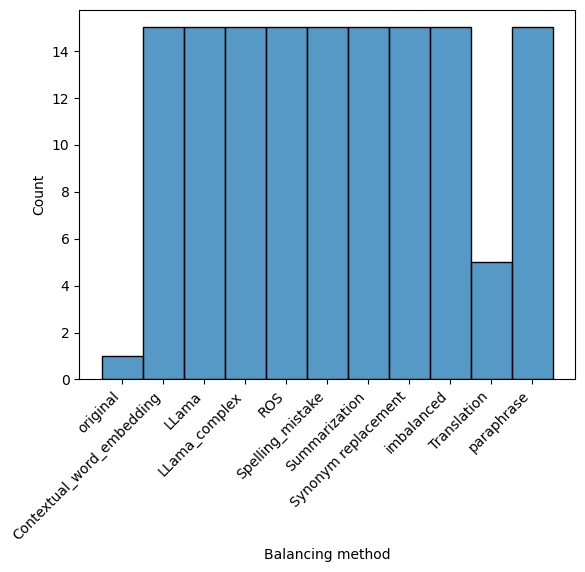

In [6]:
sns.histplot(df_tmp["Balancing method"],)
plt.xticks(rotation=45, ha="right")
plt.show()


In [7]:
# df = pd.concat([pd.read_csv("nlpaug_distilbert_models.csv")[df_simple.columns], df_simple])

In [8]:
caption = "Format of table with results of discriminatory power and calibration analysis"
label = "tab:res1"
l = df[df["Balancing method"]!="Contextual_word_embedding"]
l = l[l["Balancing method"]!="Synonym replacement"].reset_index().round(2).astype(str).loc[[np.random.randint(0,300) for _ in range(10)]].iloc[:,2:-1].to_latex(index=False)
l = l.replace("_", "\_").replace("%", "\%").replace("\n\\bottomrule","\hline").replace("\n\\midrule","\hline").replace("\n\\toprule","\hline").replace(r"begin{tabular}{",r"begin{tabular}{|").replace("}\\hline\n","|}\\hline\n")
l = r"\begin{table}[H]% Koniecznie label po caption, inaczej jest zła numeracja"+"\n\caption[Short caption]{"+caption+"}\n\label{"+label+"}\n\centering\n"+l+"\end{table}"
print(l)

\begin{table}[H]% Koniecznie label po caption, inaczej jest zła numeracja
\caption[Short caption]{Format of table with results of discriminatory power and calibration analysis}
\label{tab:res1}
\centering
\begin{tabular}{|llllllllll|}\hline
Imbalance \% & Model name & Model ID & acc & f1 & precision & recall & mcc & auc & spearman \\\hline
10 & SVM & 2 & 0.51 & 0.04 & 1.0 & 0.02 & 0.1 & 0.83 & 0.94 \\
20 & SVM & 2 & 0.54 & 0.19 & 0.73 & 0.11 & 0.13 & 0.74 & 0.82 \\
10 & SVM & 1 & 0.5 & 0.02 & 1.0 & 0.01 & 0.07 & 0.68 & 0.79 \\
50 & DistilBERT & 0 & 0.82 & 0.81 & 0.9 & 0.73 & 0.66 & 0.92 & 0.98 \\
20 & DistilBERT & 0 & 0.62 & 0.4 & 0.9 & 0.26 & 0.33 & 0.76 & 0.98 \\
20 & DistilBERT & 4 & 0.7 & 0.6 & 0.87 & 0.46 & 0.44 & 0.84 & 0.99 \\
50 & SVM & 1 & 0.83 & 0.82 & 0.89 & 0.75 & 0.67 & 0.91 & 0.99 \\
20 & LSTM & 4 & 0.57 & 0.36 & 0.71 & 0.24 & 0.19 & 0.7 & 0.91 \\
10 & LSTM & 3 & 0.5 & 0.0 & 0.0 & 0.0 & 0.0 & 0.59 & 0.69 \\
50 & DistilBERT & 1 & 0.84 & 0.81 & 0.96 & 0.7 & 0.7 & 0.94 & 0.9

# Discriminatory power

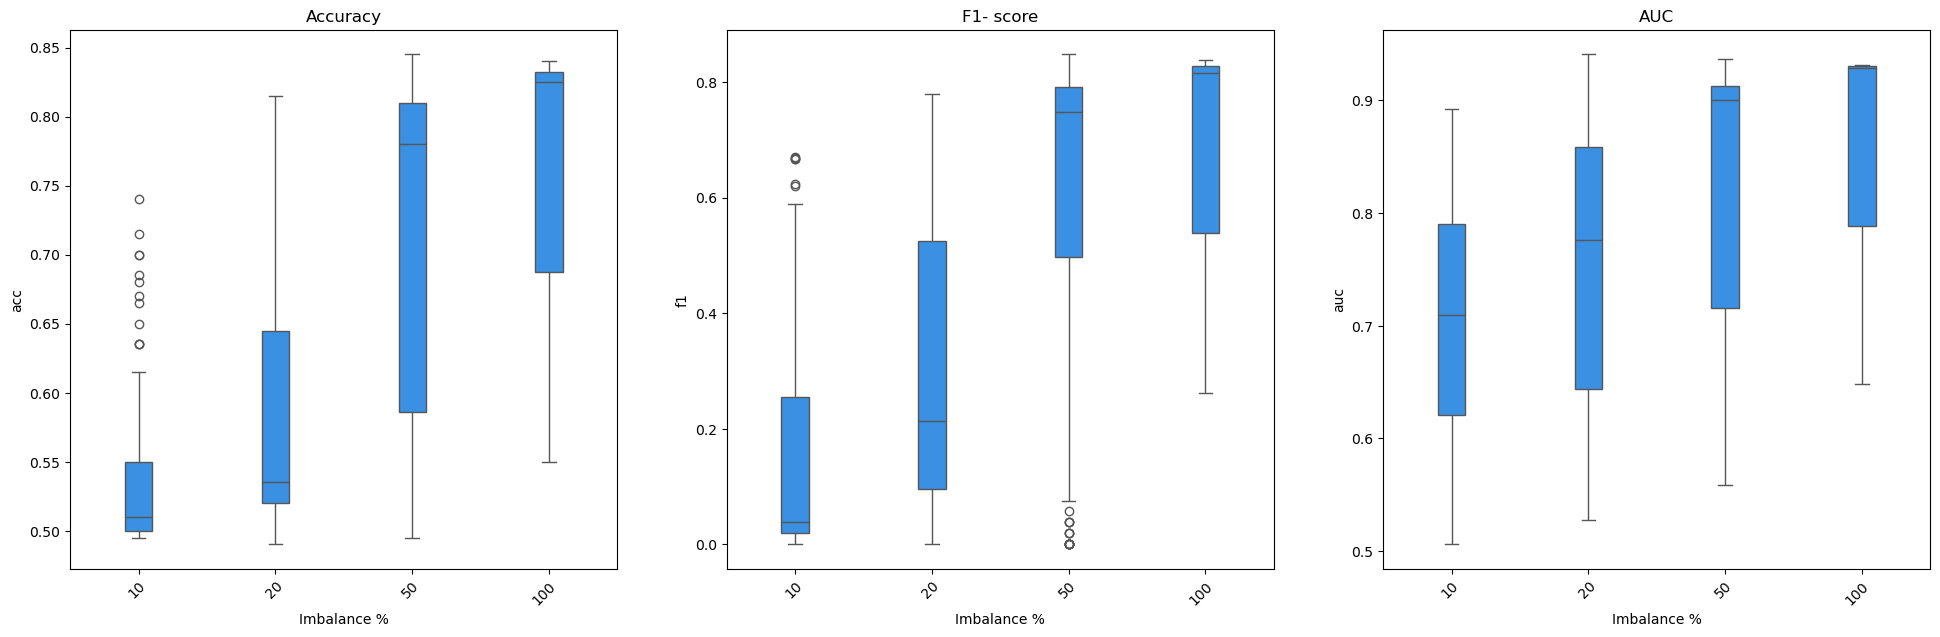

eraser_imbalance.png


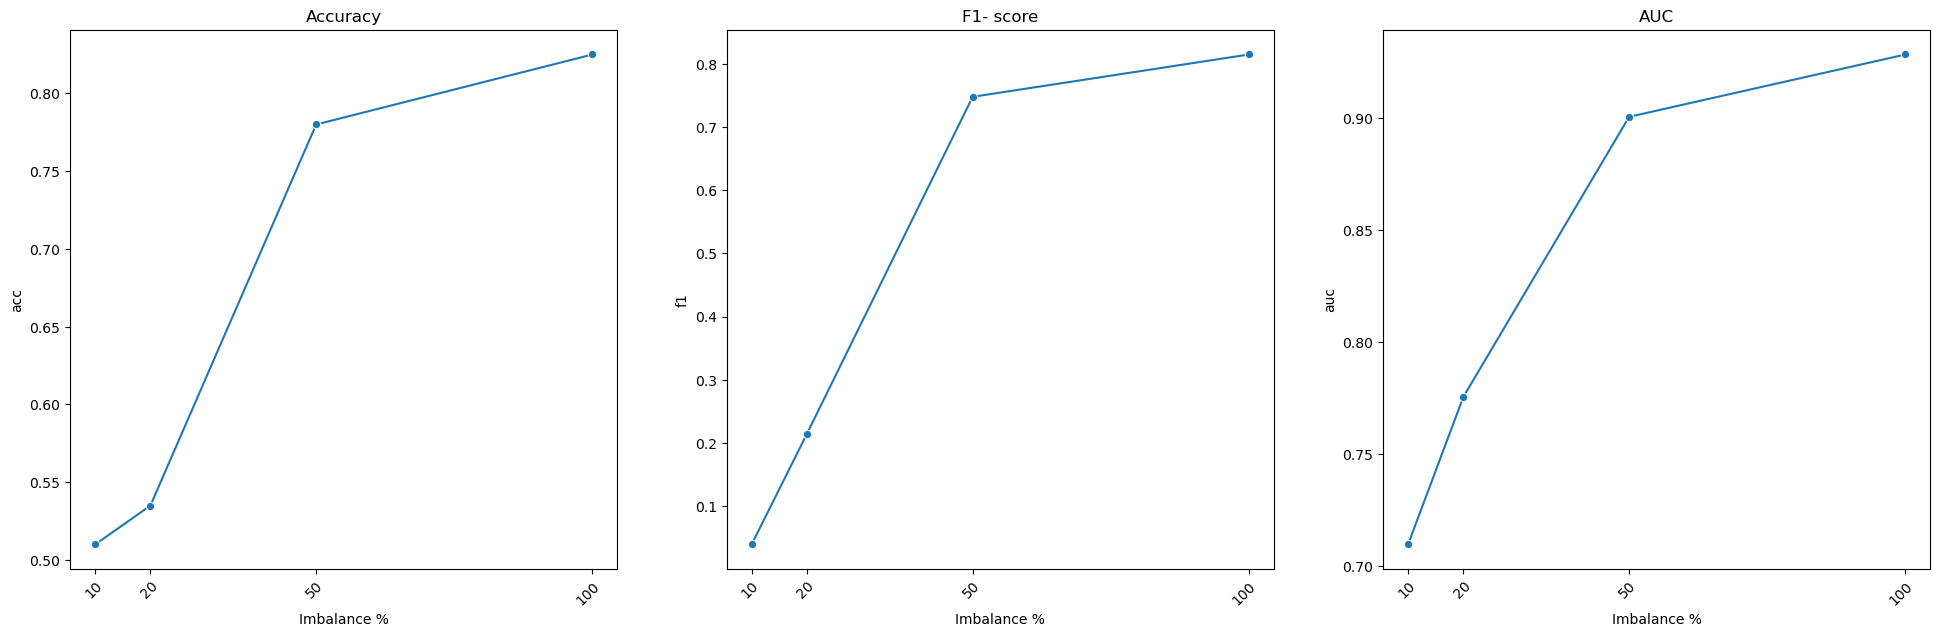

eraser_imbalance_line.png


In [9]:
def boxplot(df, measures = list(df.columns[4:-2]), grouping = "Model name", title = None, relative = False, highlight=False, good=False):
    df2 = df[list(df.columns[:4]) + measures].reset_index(drop=True)
    n_col = 3 if len(measures)>3 else len(measures)
    fig, ax = plt.subplots(int(np.ceil((len(df2.columns)-4)/3)), n_col, figsize=(n_col*8,7 * int(np.ceil((len(df2.columns)-4)/3))))
    if n_col>1:
        ax = ax.flatten()
    
    if int(np.ceil((len(df2.columns)-4)/3))>1:
        plt.subplots_adjust(hspace=0.5)
    
    for i, measure in enumerate(df2.columns[4:]):
        axes = ax[i] if n_col>1 else ax
        if relative:
            axes.hlines(1,-1,len(np.unique(df[grouping]))+1, color="gray", alpha=0.3)
        sns.boxplot(x=grouping, y=measure,width = 0.2, data=df2, ax = axes,palette=["dodgerblue" if col not in ["original", "imbalanced"] or 1-highlight else ("limegreen" if col in ["original"] else "crimson") for col in df2[grouping].unique()])
        axes.set_title(measure if measure not in measure_dict.keys() else measure_dict[measure])
        axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        if grouping in ["Model name", "Balancing method"]:
            axes.set(xlabel=None) 
    if n_col>1:
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])
    if title != None:
        plt.suptitle(title)
        title = task+"_"+grouping.split(" ")[0]+"_"+title.split(" ")[0]
    else:
        title = task+"_"+grouping.split(" ")[0]
    if relative:
        title += "_rel"
    if highlight:
        title += "_highlight"
    if good:
        title += "_good"
    if len(measures)==1:
        title += "_cal"
    plt.savefig(out+r"\\"+title.lower()+".png", bbox_inches='tight')
    plt.show() 
    print(title.lower()+".png")
    
def median_plot(df, measures = ["acc", "f1", "auc"], grouping = None, relative = False, title=None, good=False):
    grouping = ["Imbalance %", grouping] if grouping!=None else ["Imbalance %"]

    df2 = df[grouping+measures]
    df_groupped = df2.groupby(grouping).median()

    n_col = 3 if len(measures)>3 else len(measures)
    fig, ax = plt.subplots(int(np.ceil((len(measures))/3)), n_col, figsize=(n_col*8,7 * int(np.ceil((len(measures))/3))))
    if n_col>1:
        ax = ax.flatten()

    if int(np.ceil((len(measures))/3))>1:
        plt.subplots_adjust(hspace=0.5)

    for i, measure in enumerate(measures):
        axes = ax[i] if n_col>1 else ax
        if relative:
            axes.hlines(1,10,np.max(df2["Imbalance %"]), color="gray", alpha=0.3)
        g = sns.lineplot(x="Imbalance %", y=measure, data=df_groupped, ax = axes, hue=grouping[1] if len(grouping)>1 else None, marker="o")
        if len(grouping) > 1:
            if i%n_col!=1 and n_col==3:
                g.get_legend().remove()
            else:
                sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -.35), frameon=False, ncol=4)
        axes.set_title(measure if measure not in measure_dict.keys() else measure_dict[measure])
        axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        axes.set_xticks(np.unique(df2["Imbalance %"]),np.unique(df2["Imbalance %"]))
        axes.set_xlabel("Imbalance %")
    if n_col>1:
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])
    if title != None:
        plt.suptitle(title)
        title = task+"_imbalance_"+title.split(" ")[0]
    else:
        title = task+"_imbalance"
    if relative:
        title += "_rel"
    if good:
        title += "_good"
    if len(measures)==1:
        title += "_cal"
    
    plt.savefig(out+r"\\"+title.lower()+"_line"+".png", bbox_inches='tight')
    plt.show()
    print(title.lower()+"_line"+".png")




boxplot(df, ["acc", "f1", "auc"], grouping = "Imbalance %")
median_plot(df, measures = ["acc", "f1", "auc"], grouping = None, relative = False, title=None)

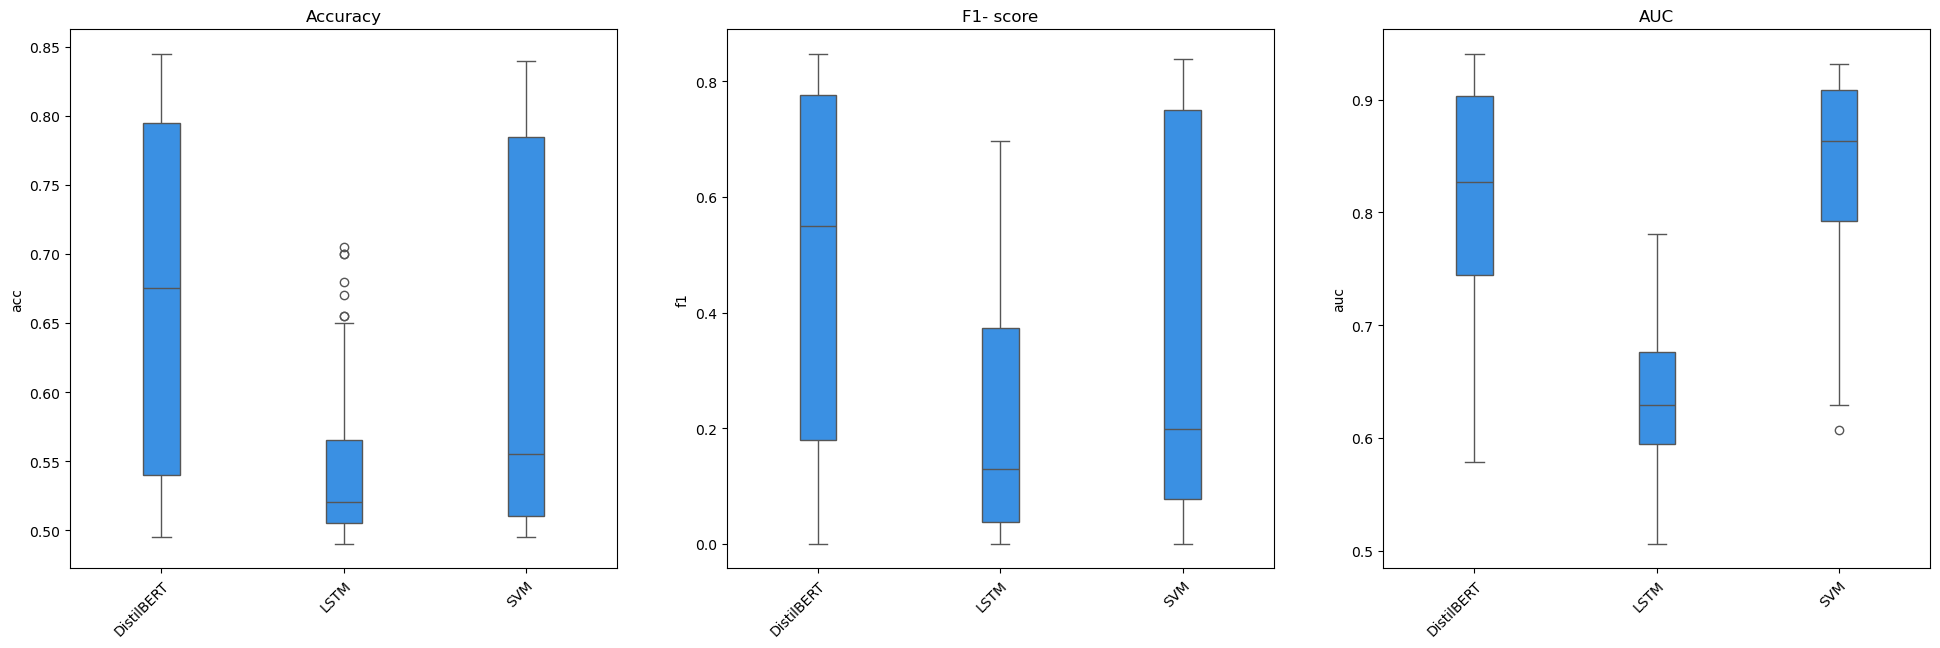

eraser_model.png


In [10]:
boxplot(df, measures = ["acc", "f1", "auc"], grouping = "Model name")

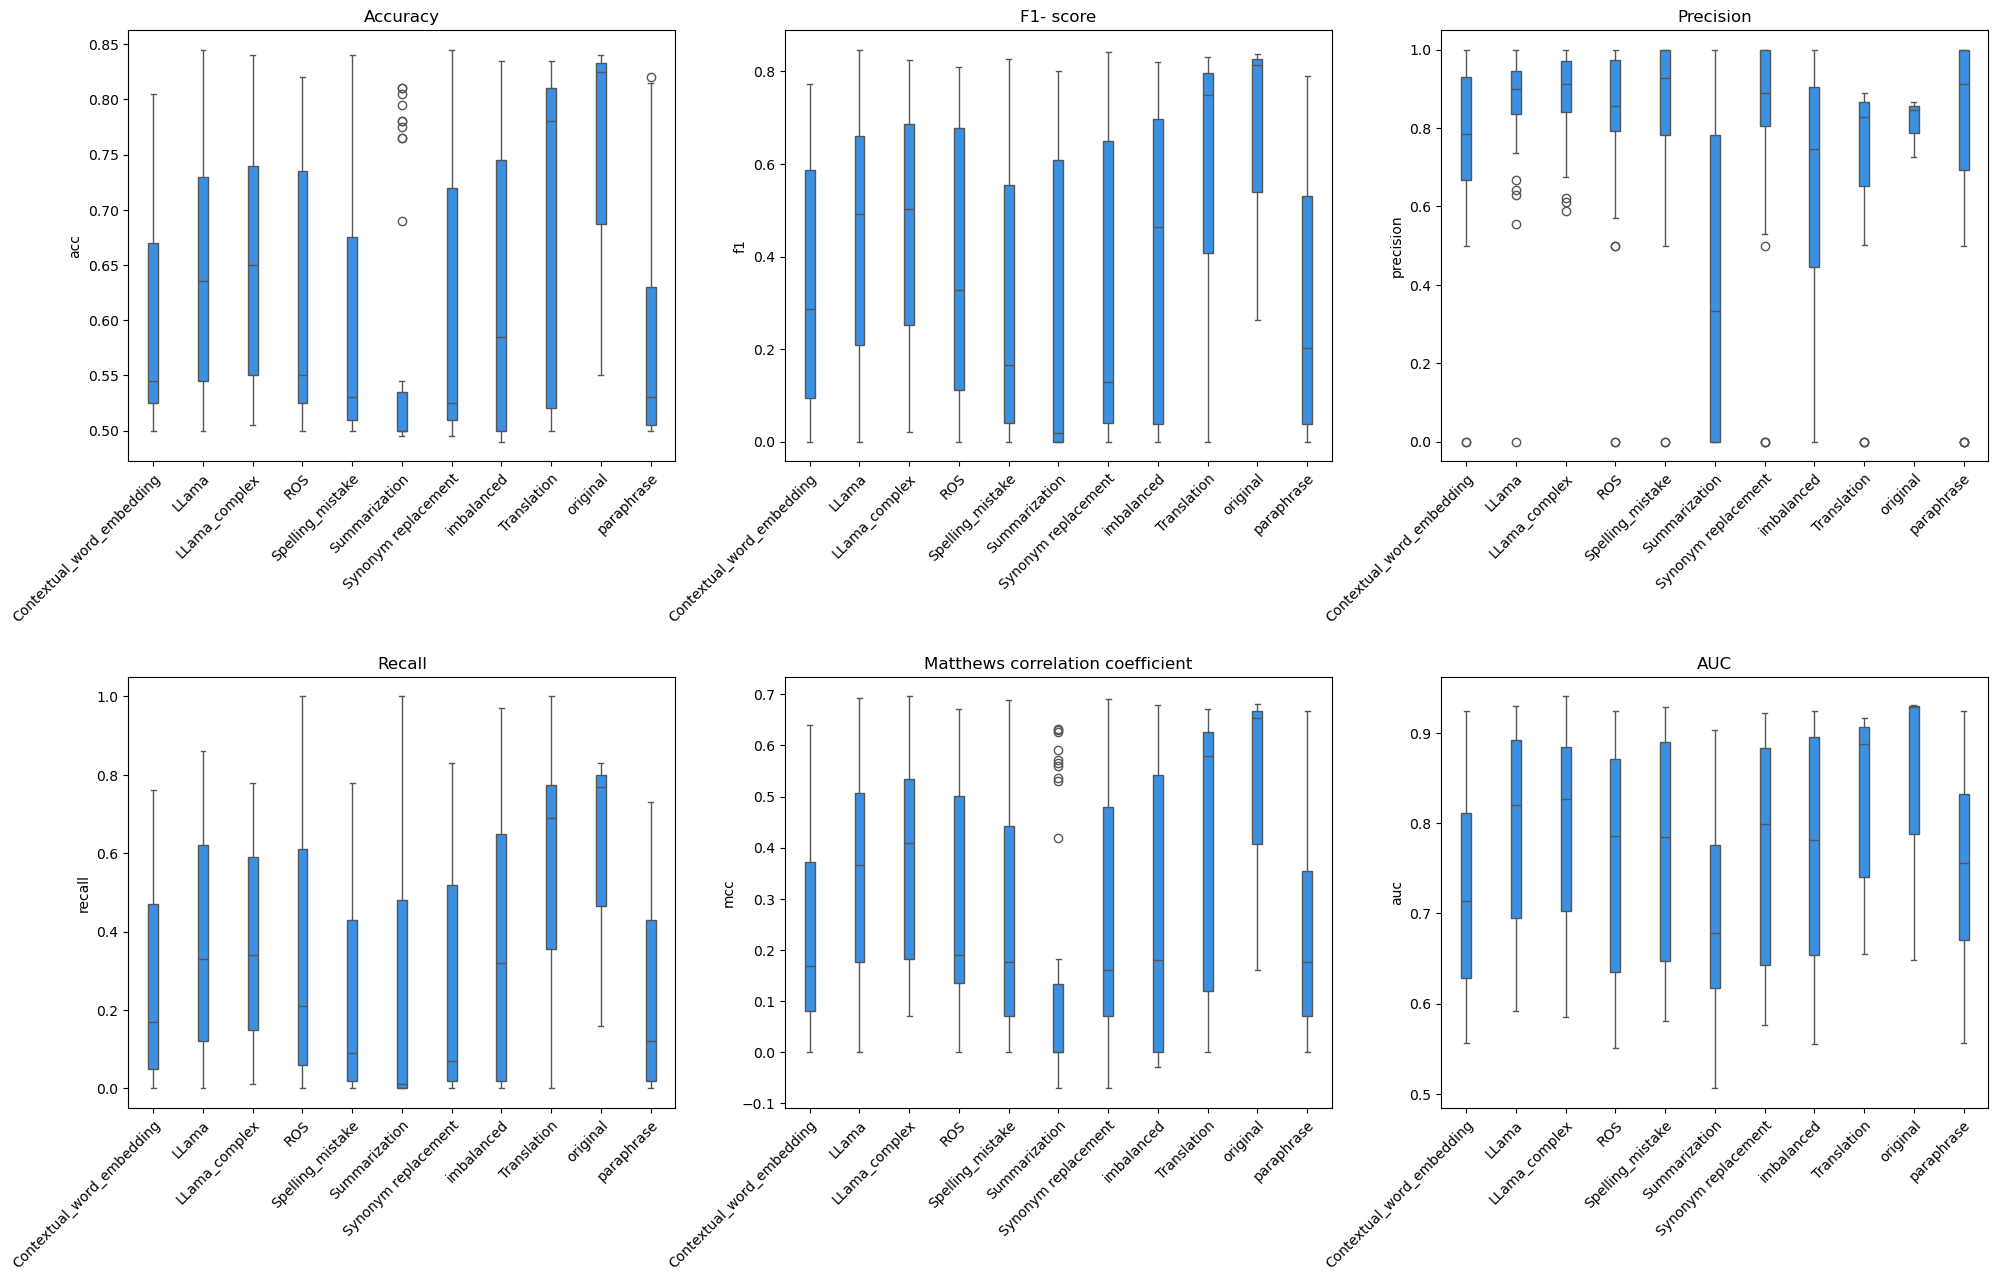

eraser_balancing.png


In [11]:
boxplot(df, grouping = "Balancing method")

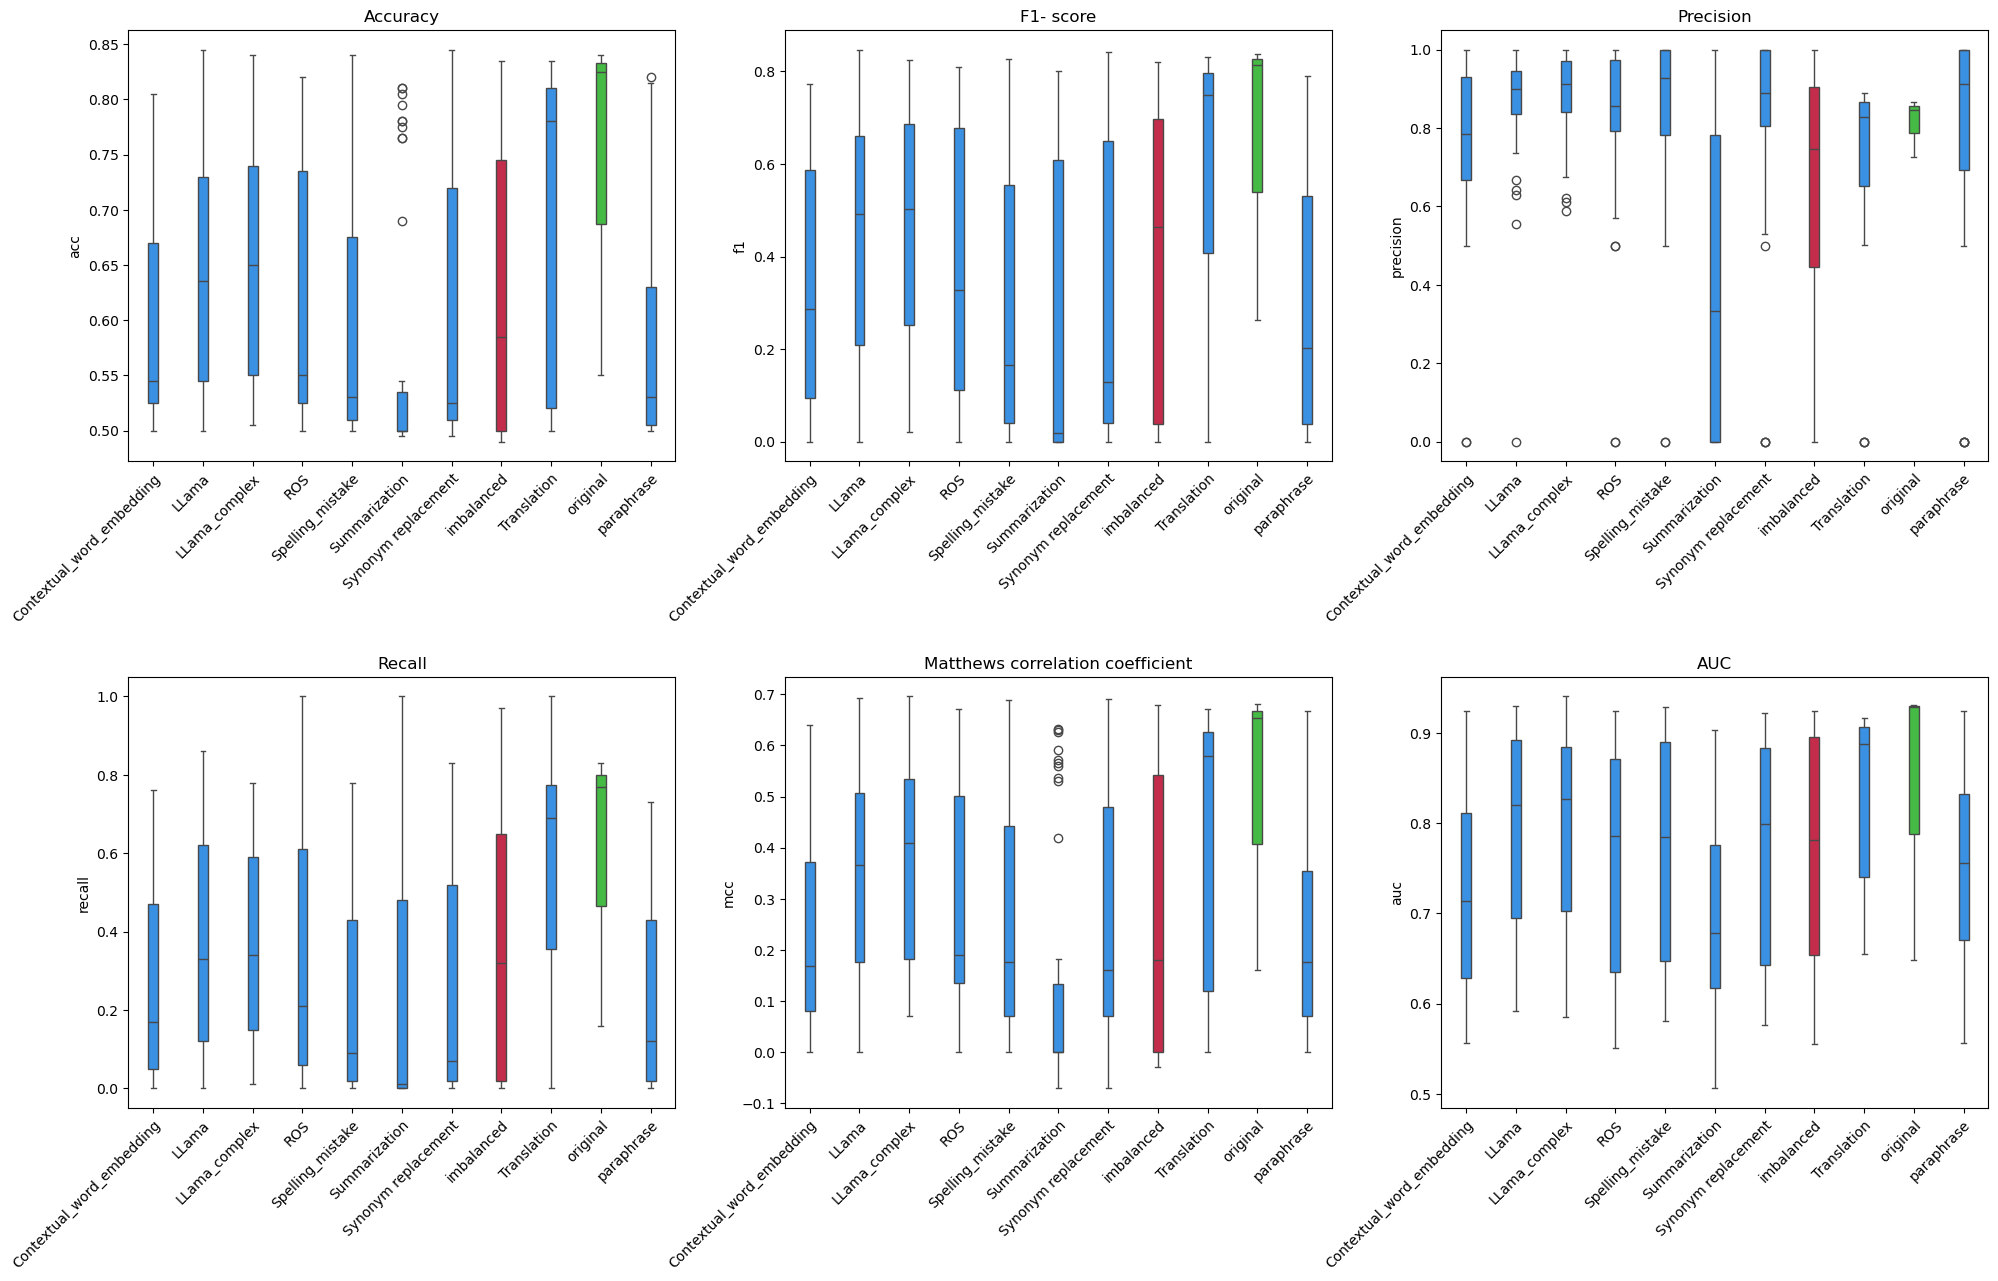

eraser_balancing_highlight.png


In [12]:
boxplot(df, grouping = "Balancing method", highlight=True)

In [13]:
# for method in np.unique(df["Balancing method"]):
#     if method=="original":continue
#     df_tmp = df[df["Balancing method"]==method].reset_index(drop=True)
#     boxplot(df_tmp, ["acc", "f1", "auc"], grouping = "Imbalance %", title=method)

# Let's compare relative measure value of balanced model compared to imbalanced model

This approach will further limit the size of testing sample, as it requires both imbalanced and balanced model to be good models. If balanced model is good and its corresponding bad model is bad then neither of those models will be taken in the consideration in the following analysis.

In [14]:
# Generating dataset with relative values of model performance measures
results = []
for imbalance_perc in np.unique(df["Imbalance %"]):
    for model_id in np.unique(df["Model ID"]):
        if (model_id=="original") or imbalance_perc==100: continue
        for model_name in np.unique(df["Model name"]):
            # Filtering model family with common model id, model name and imbalance percentage
            df_tmp = df[(df["Model ID"] == model_id) & (df["Model name"] == model_name) & (df["Imbalance %"] == imbalance_perc)].reset_index(drop=True)
            if "imbalanced" in df_tmp["Balancing method"].values:
                # Saving imbalanced model stats
                imbalanced = df_tmp[df_tmp["Balancing method"] == "imbalanced"].replace(0,0.1)
                imbalanced.reset_index(drop=True)
                # Filtering balanced models stats
                balanced = df_tmp[df_tmp["Balancing method"] != "imbalanced"].reset_index(drop=True)
                # Calculating ratio of balanced to imbalanced
                df_tmp = pd.concat([balanced.iloc[:,:4], balanced.iloc[:,4:]/imbalanced.iloc[:,4:].values], axis=1)
                results.append(df_tmp)
        
df_relative = pd.concat(results)
df_relative

Balancing method  Imbalance %  Model name  Model ID       acc  \
0   Contextual_word_embedding           10  DistilBERT         0  1.090000   
1                       LLama           10  DistilBERT         0  1.430000   
2               LLama_complex           10  DistilBERT         0  1.400000   
3                         ROS           10  DistilBERT         0  1.200000   
4            Spelling_mistake           10  DistilBERT         0  1.080000   
..                        ...          ...         ...       ...       ...   
4            Spelling_mistake           50         SVM         4  1.000000   
5               Summarization           50         SVM         4  0.950920   
6         Synonym replacement           50         SVM         4  0.993865   
7                 Translation           50         SVM         4  0.957055   
8                  paraphrase           50         SVM         4  0.993865   

          f1  precision    recall       mcc       auc  spearman  spearman_pval  
0   1.801802   9.090909  1.000000  1.973855  0.883804  0.559748   67325.752596  
1   6.225166   9.215686  4.700000  4.932763  1.222664  1.009506       0.150370  
2   5.890411   9.347826  4.300000  4.752485  1.200329  1.003274       0.573634  
3   3.442623   9.545455  2.100000  3.196014  1.177446  0.962593      36.857340  
4   1.636364   9.000000  0.900000  1.835326  1.072075  0.899371     559.207202  
..       ...        ...       ...       ...       ...       ...            ...  
4   0.968905   1.136986  0.863014  1.060722  0.990632  0.996890       2.447473  
5   0.934757   0.974560  0.904110  0.884008  0.952778  0.987578      15.960090  
6   0.959411   1.136986  0.849315  1.048450  0.985948  0.947045     734.353310  
7   0.936467   0.998704  0.890411  0.907148  0.956972  1.000075       0.975919  
8   0.973247   1.072016  0.904110  1.016629  0.994118  0.984657      24.839080  

[375 rows x 12 columns]

In [15]:
key, value = np.unique(df_relative["Model name"], return_counts = True)
print("Sample with relative model metrics contains: ")
for k, v in zip(key, value):
    print(f"- {v} {k} models")

Sample with relative model metrics contains: 
- 125 DistilBERT models
- 125 LSTM models
- 125 SVM models


In [16]:
np.unique(df[df["Model name"]=="DistilBERT"]["Balancing method"])

array(['Contextual_word_embedding', 'LLama', 'LLama_complex', 'ROS',
       'Spelling_mistake', 'Summarization', 'Synonym replacement',
       'Translation', 'imbalanced', 'original', 'paraphrase'],
      dtype=object)

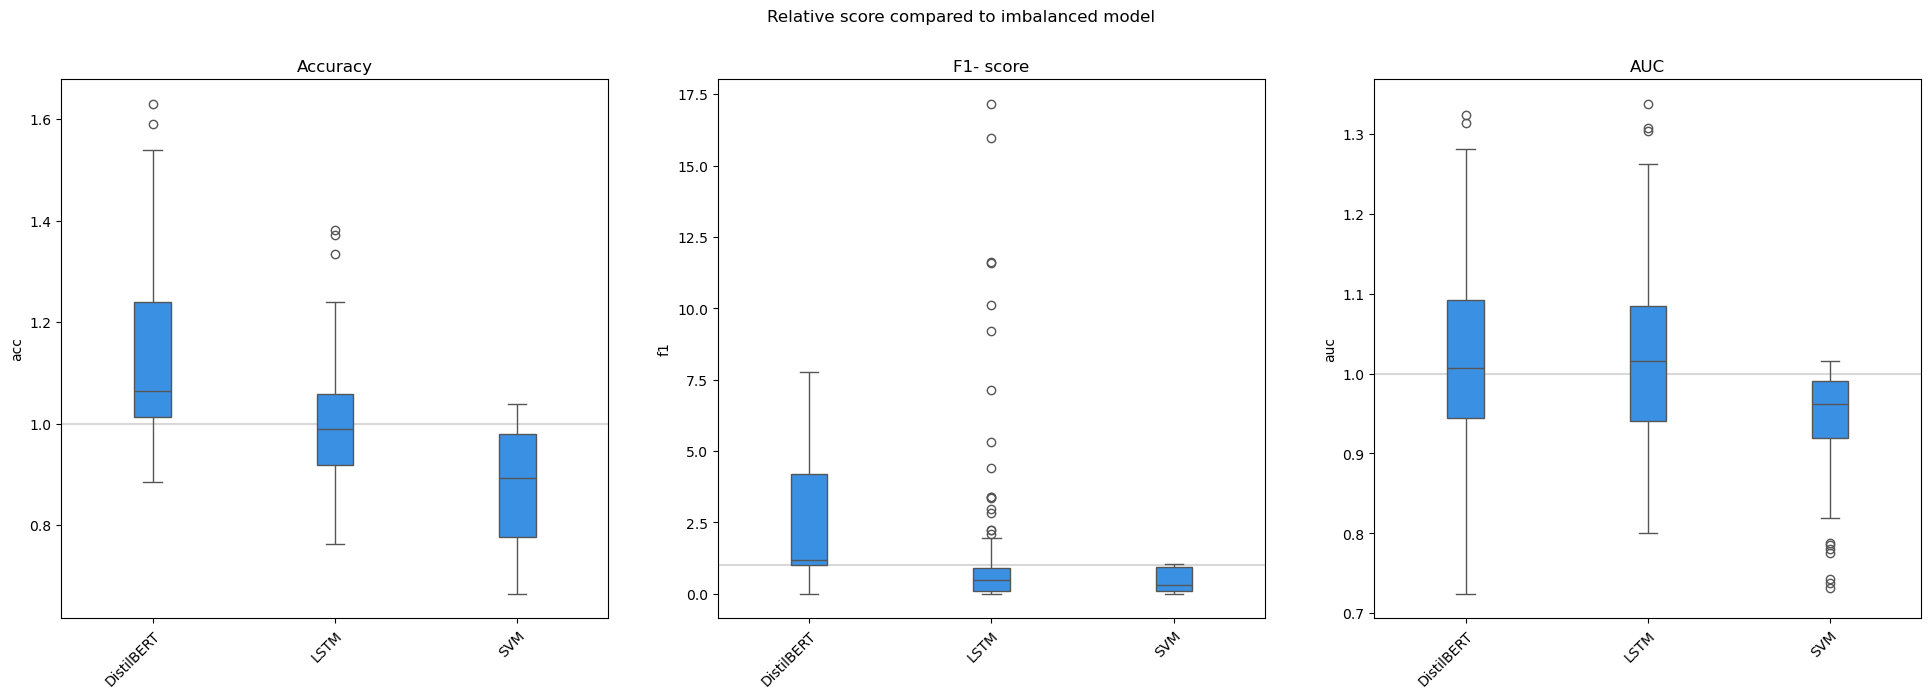

eraser_model_relative_rel.png


In [17]:
boxplot(df_relative, ["acc", "f1", "auc"], grouping = "Model name", title="Relative score compared to imbalanced model", relative = True)

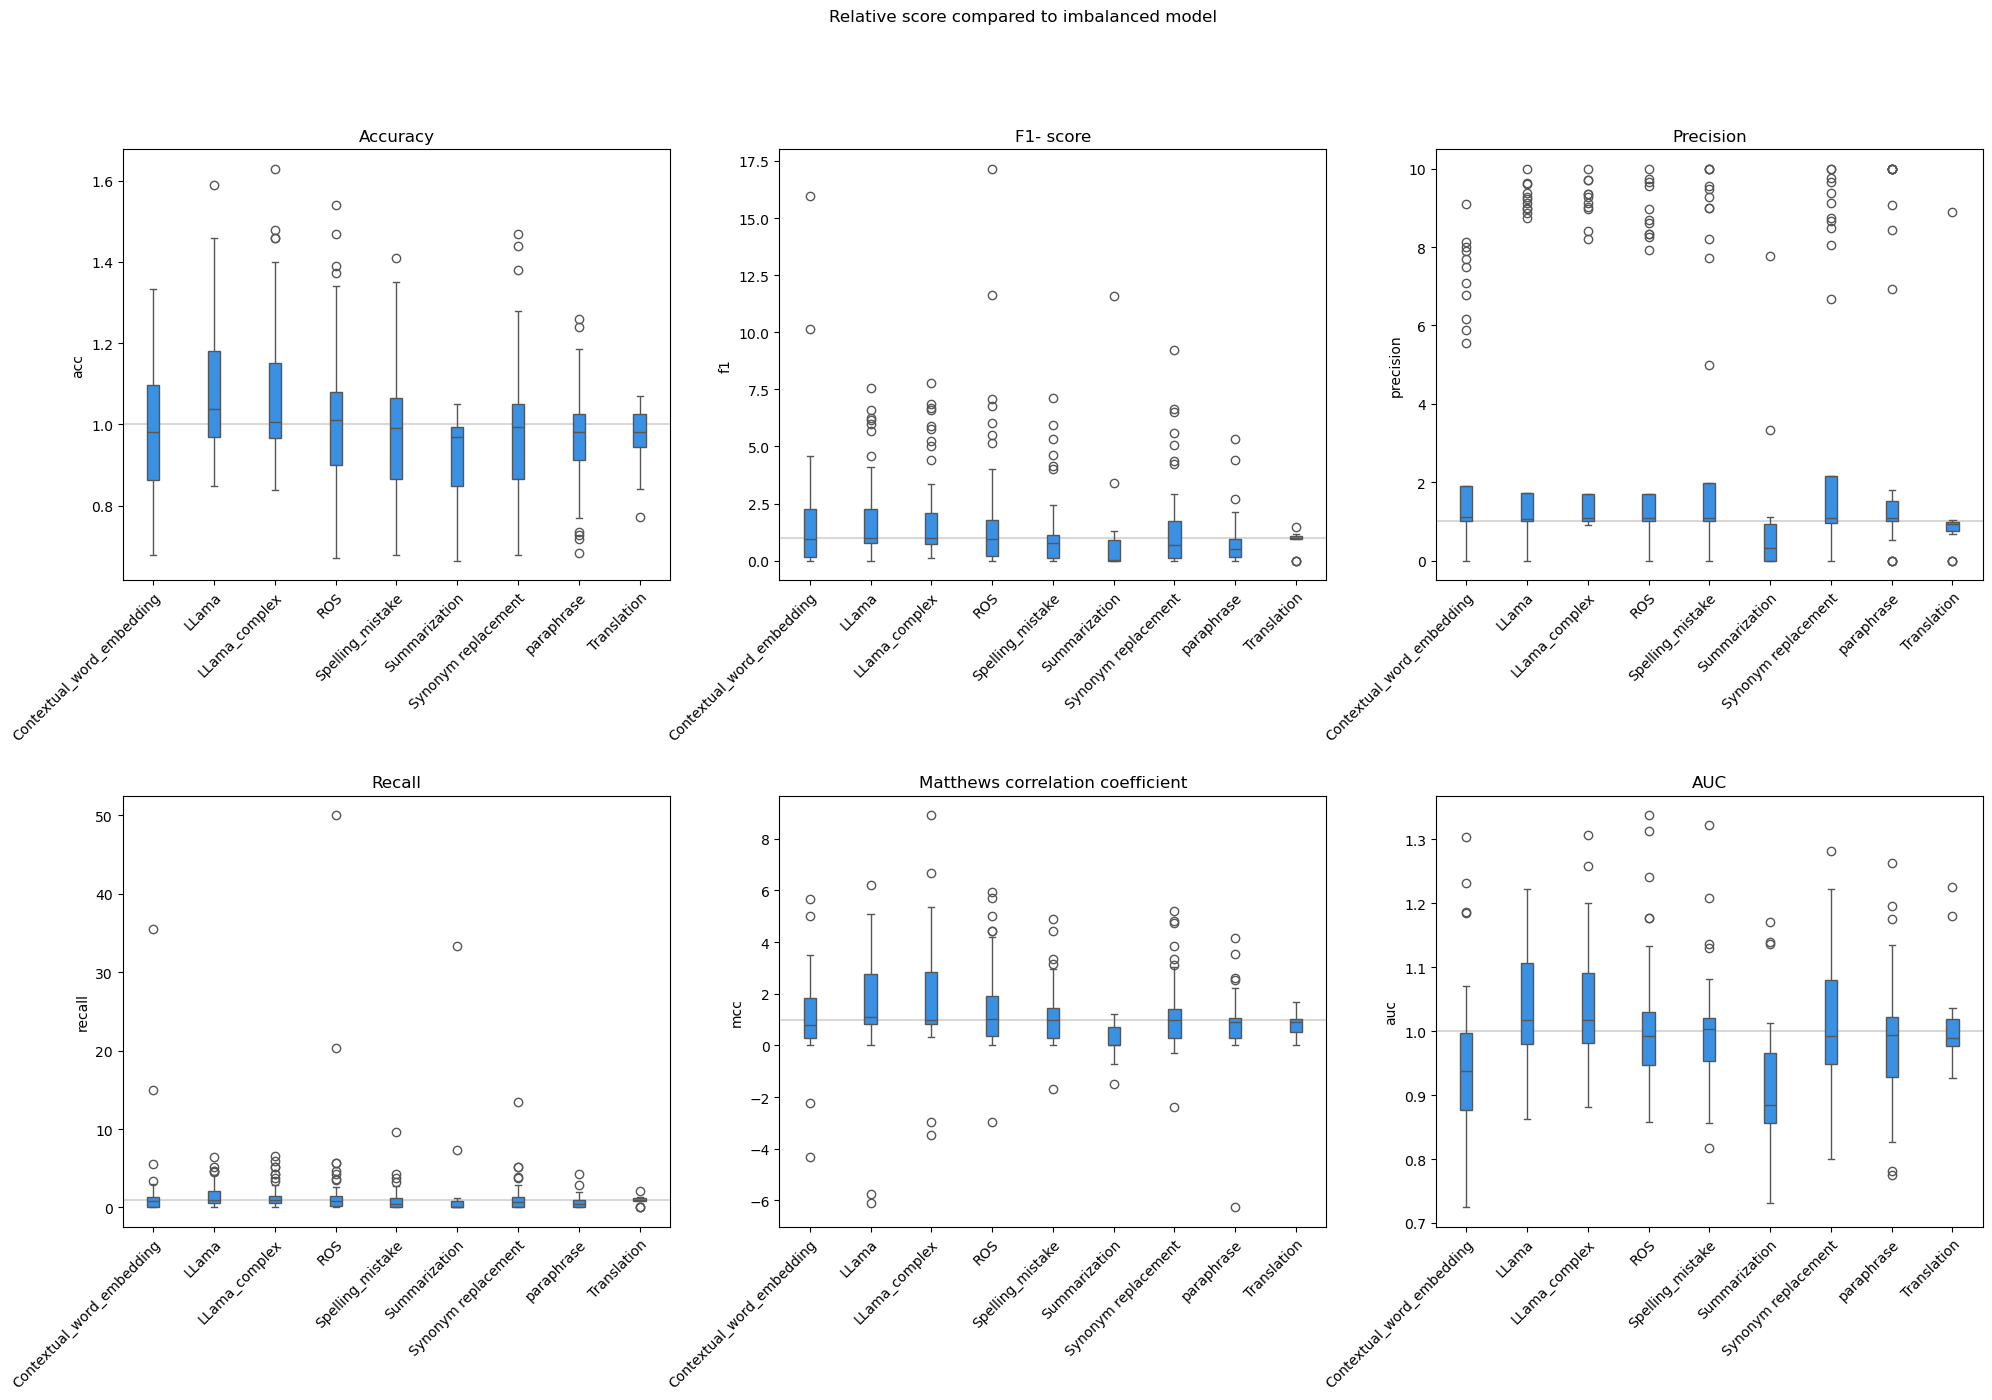

eraser_balancing_relative_rel.png


In [18]:

boxplot(df_relative, grouping = "Balancing method", title="Relative score compared to imbalanced model", relative = True)

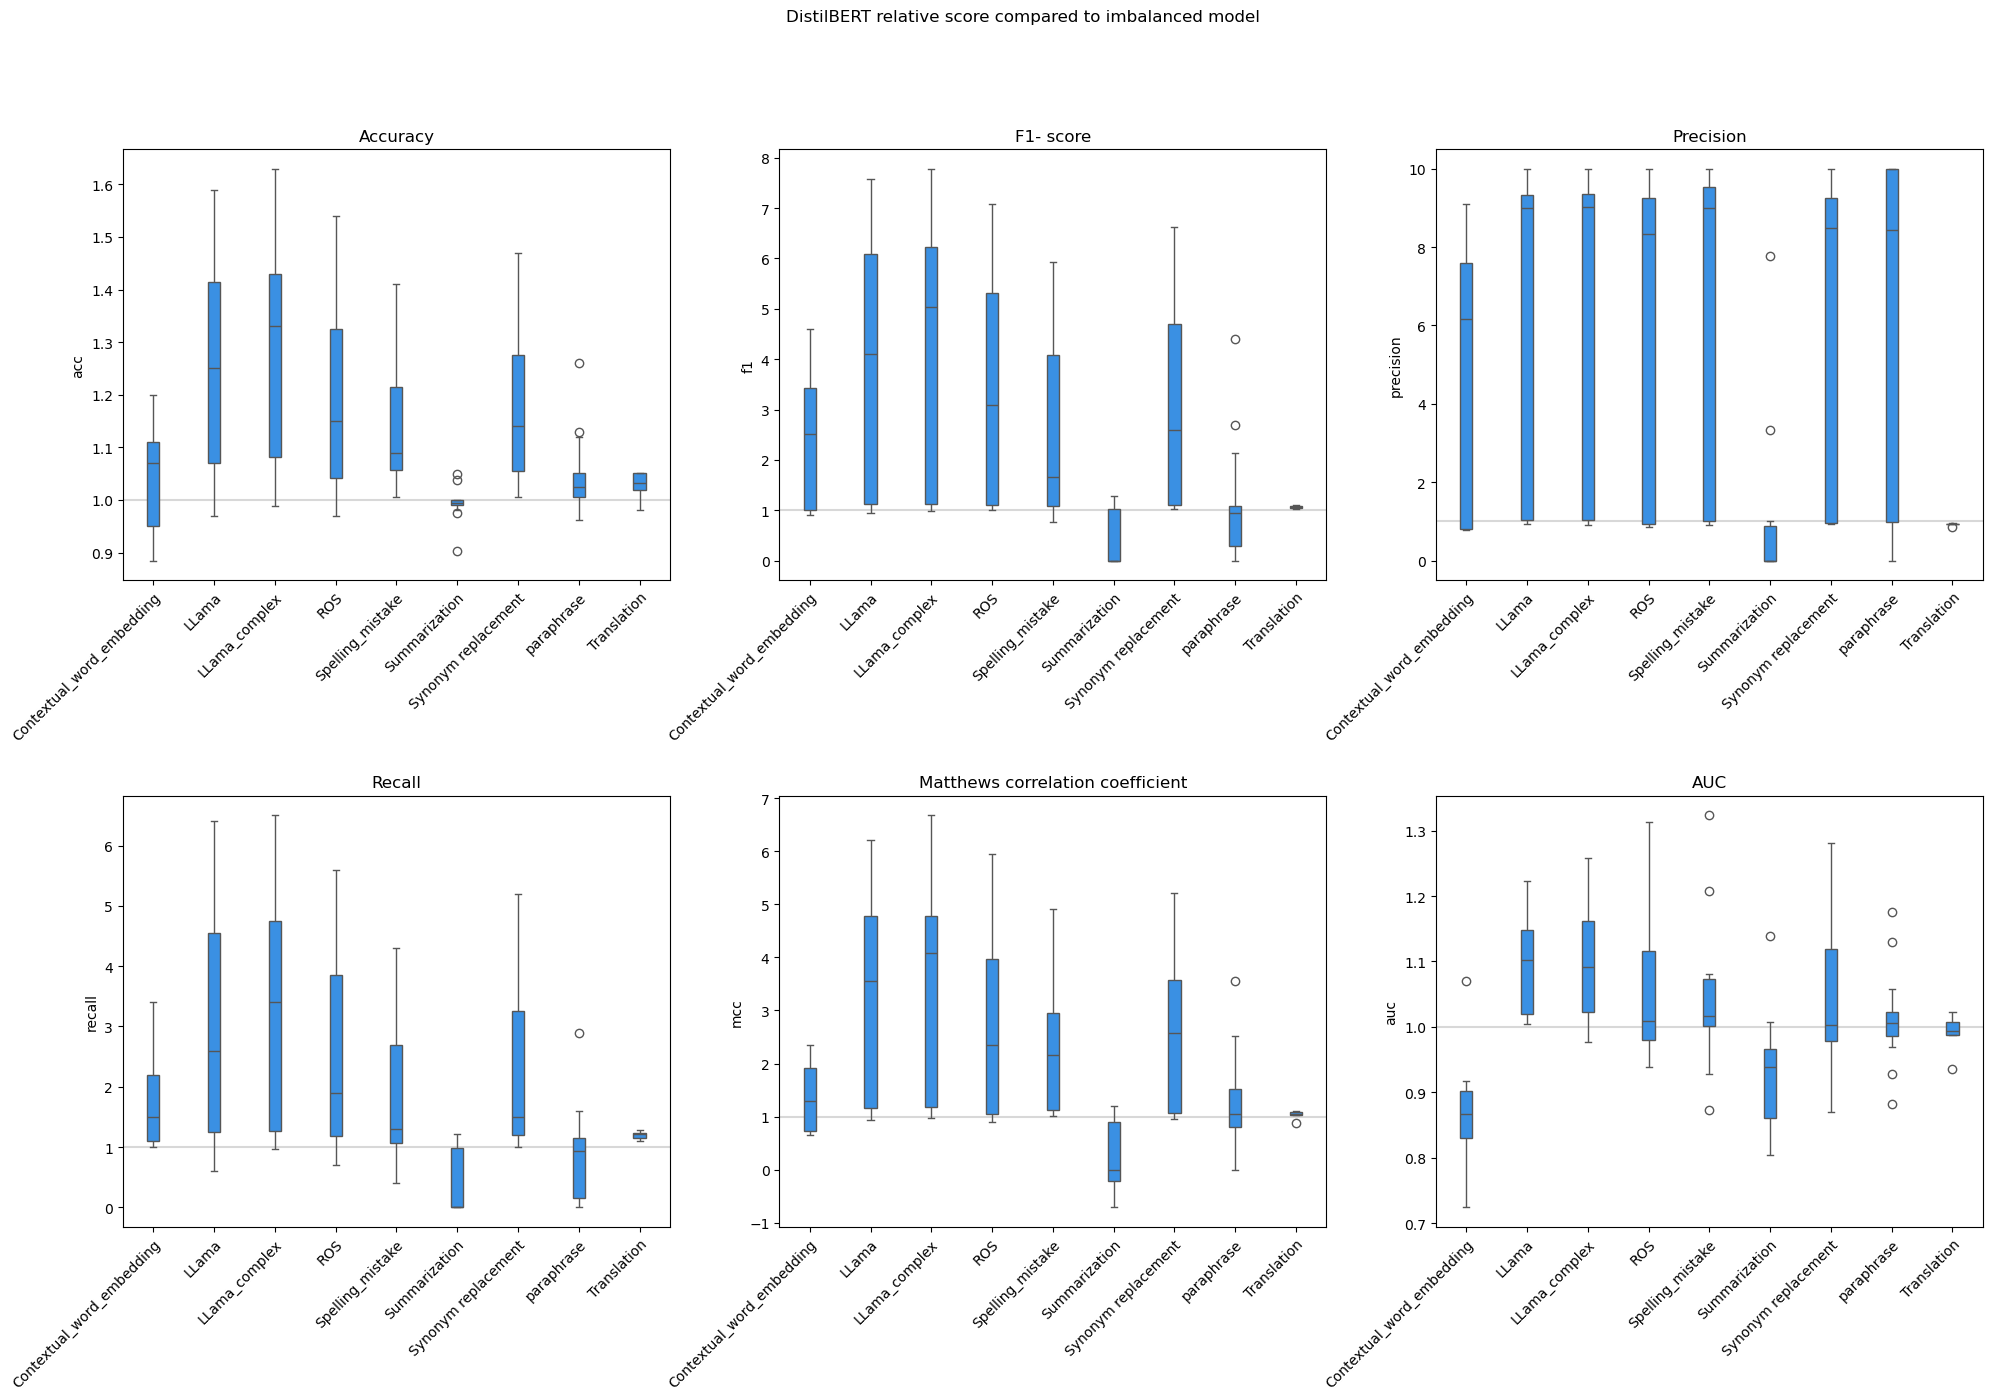

eraser_balancing_distilbert_rel.png


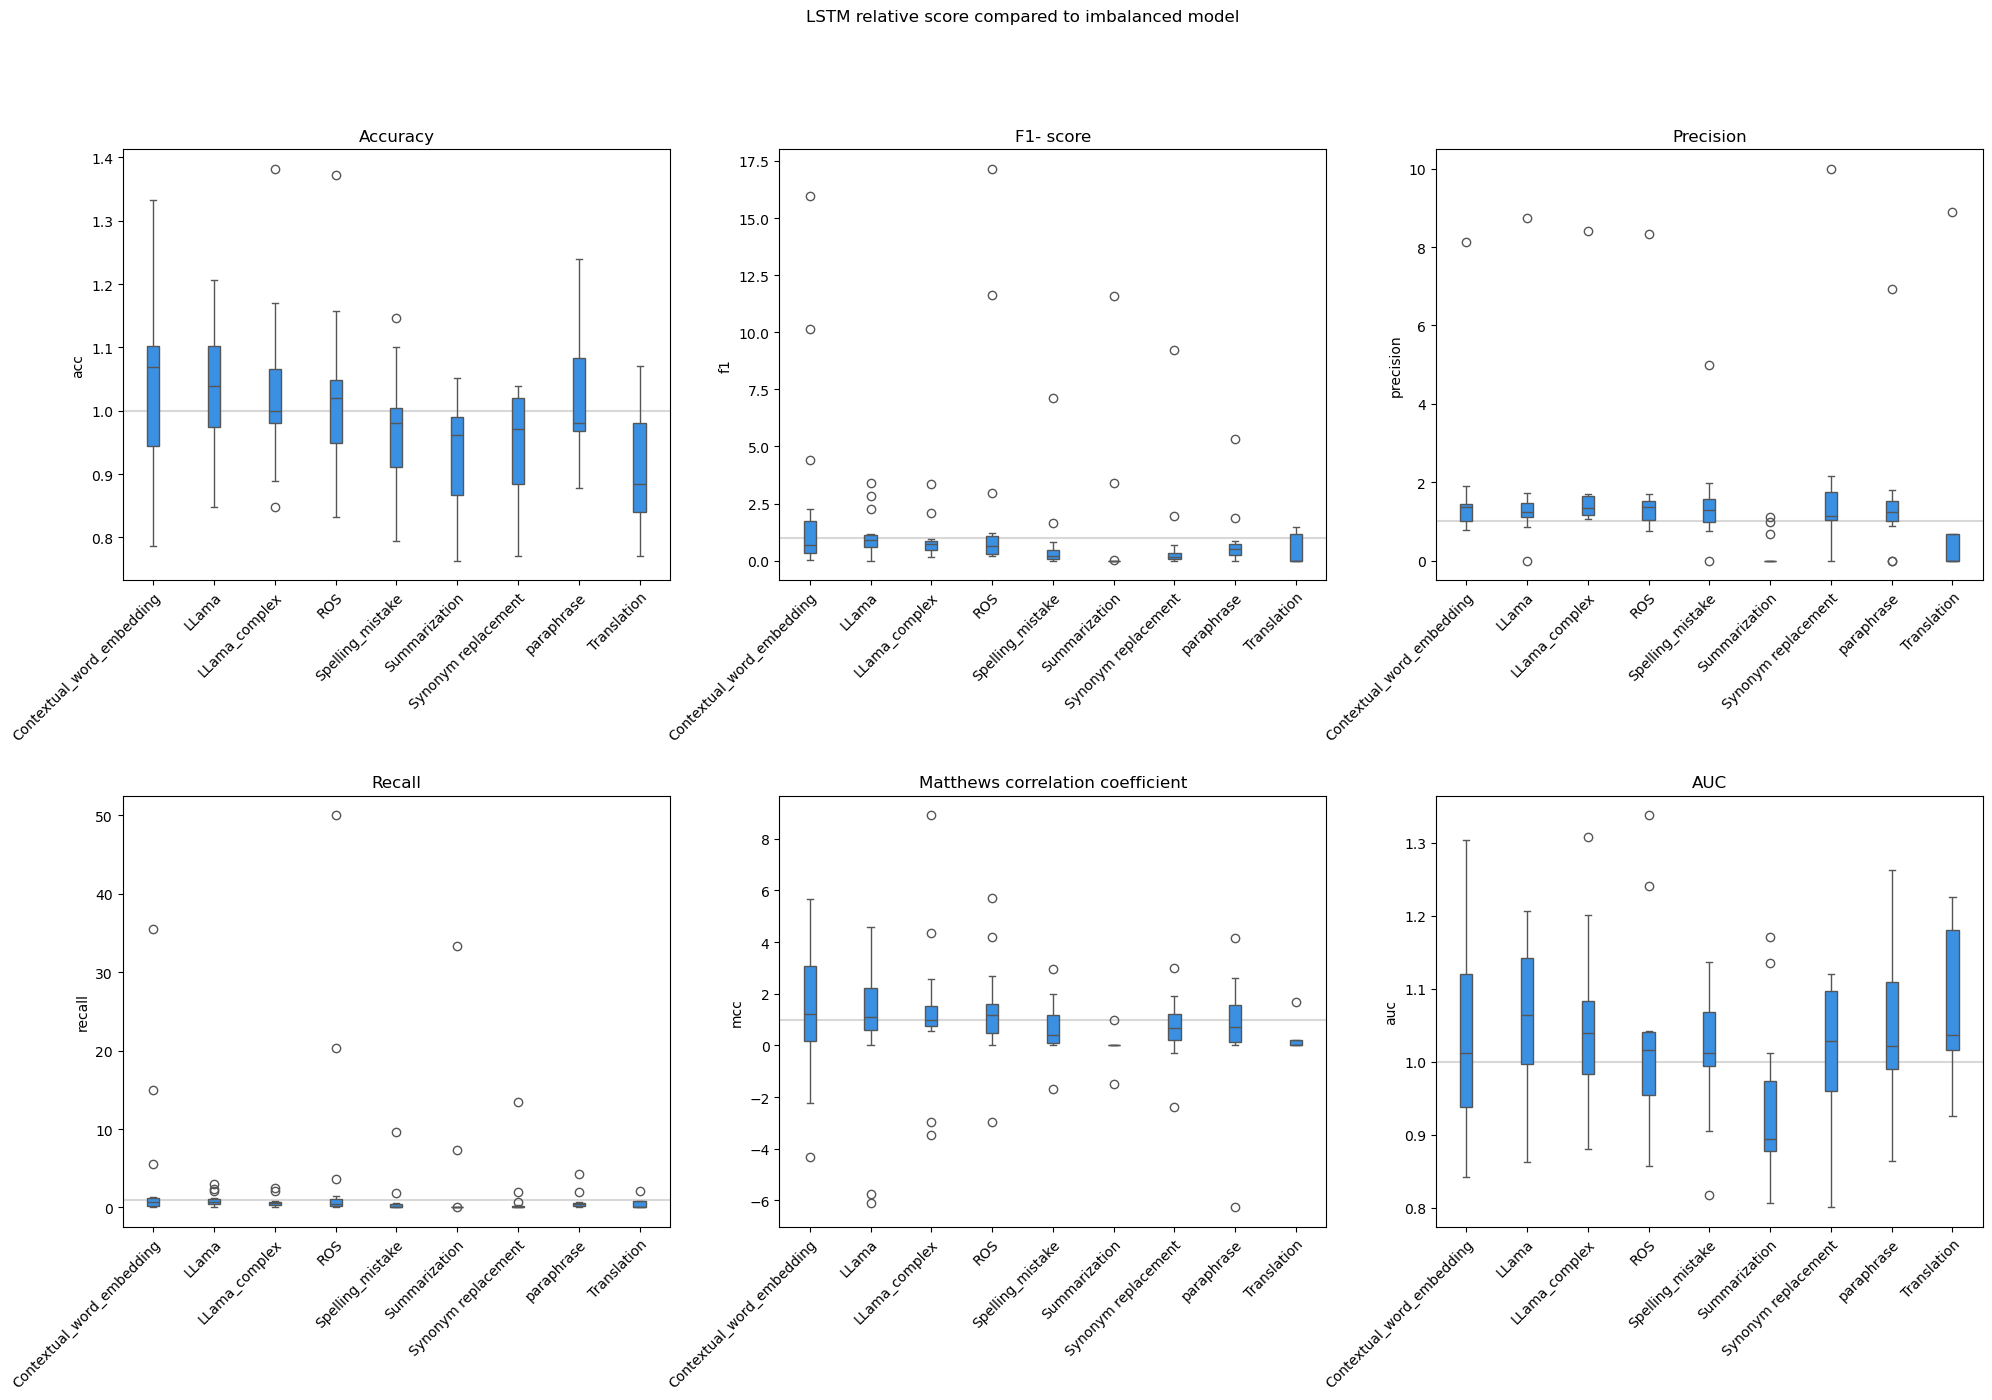

eraser_balancing_lstm_rel.png


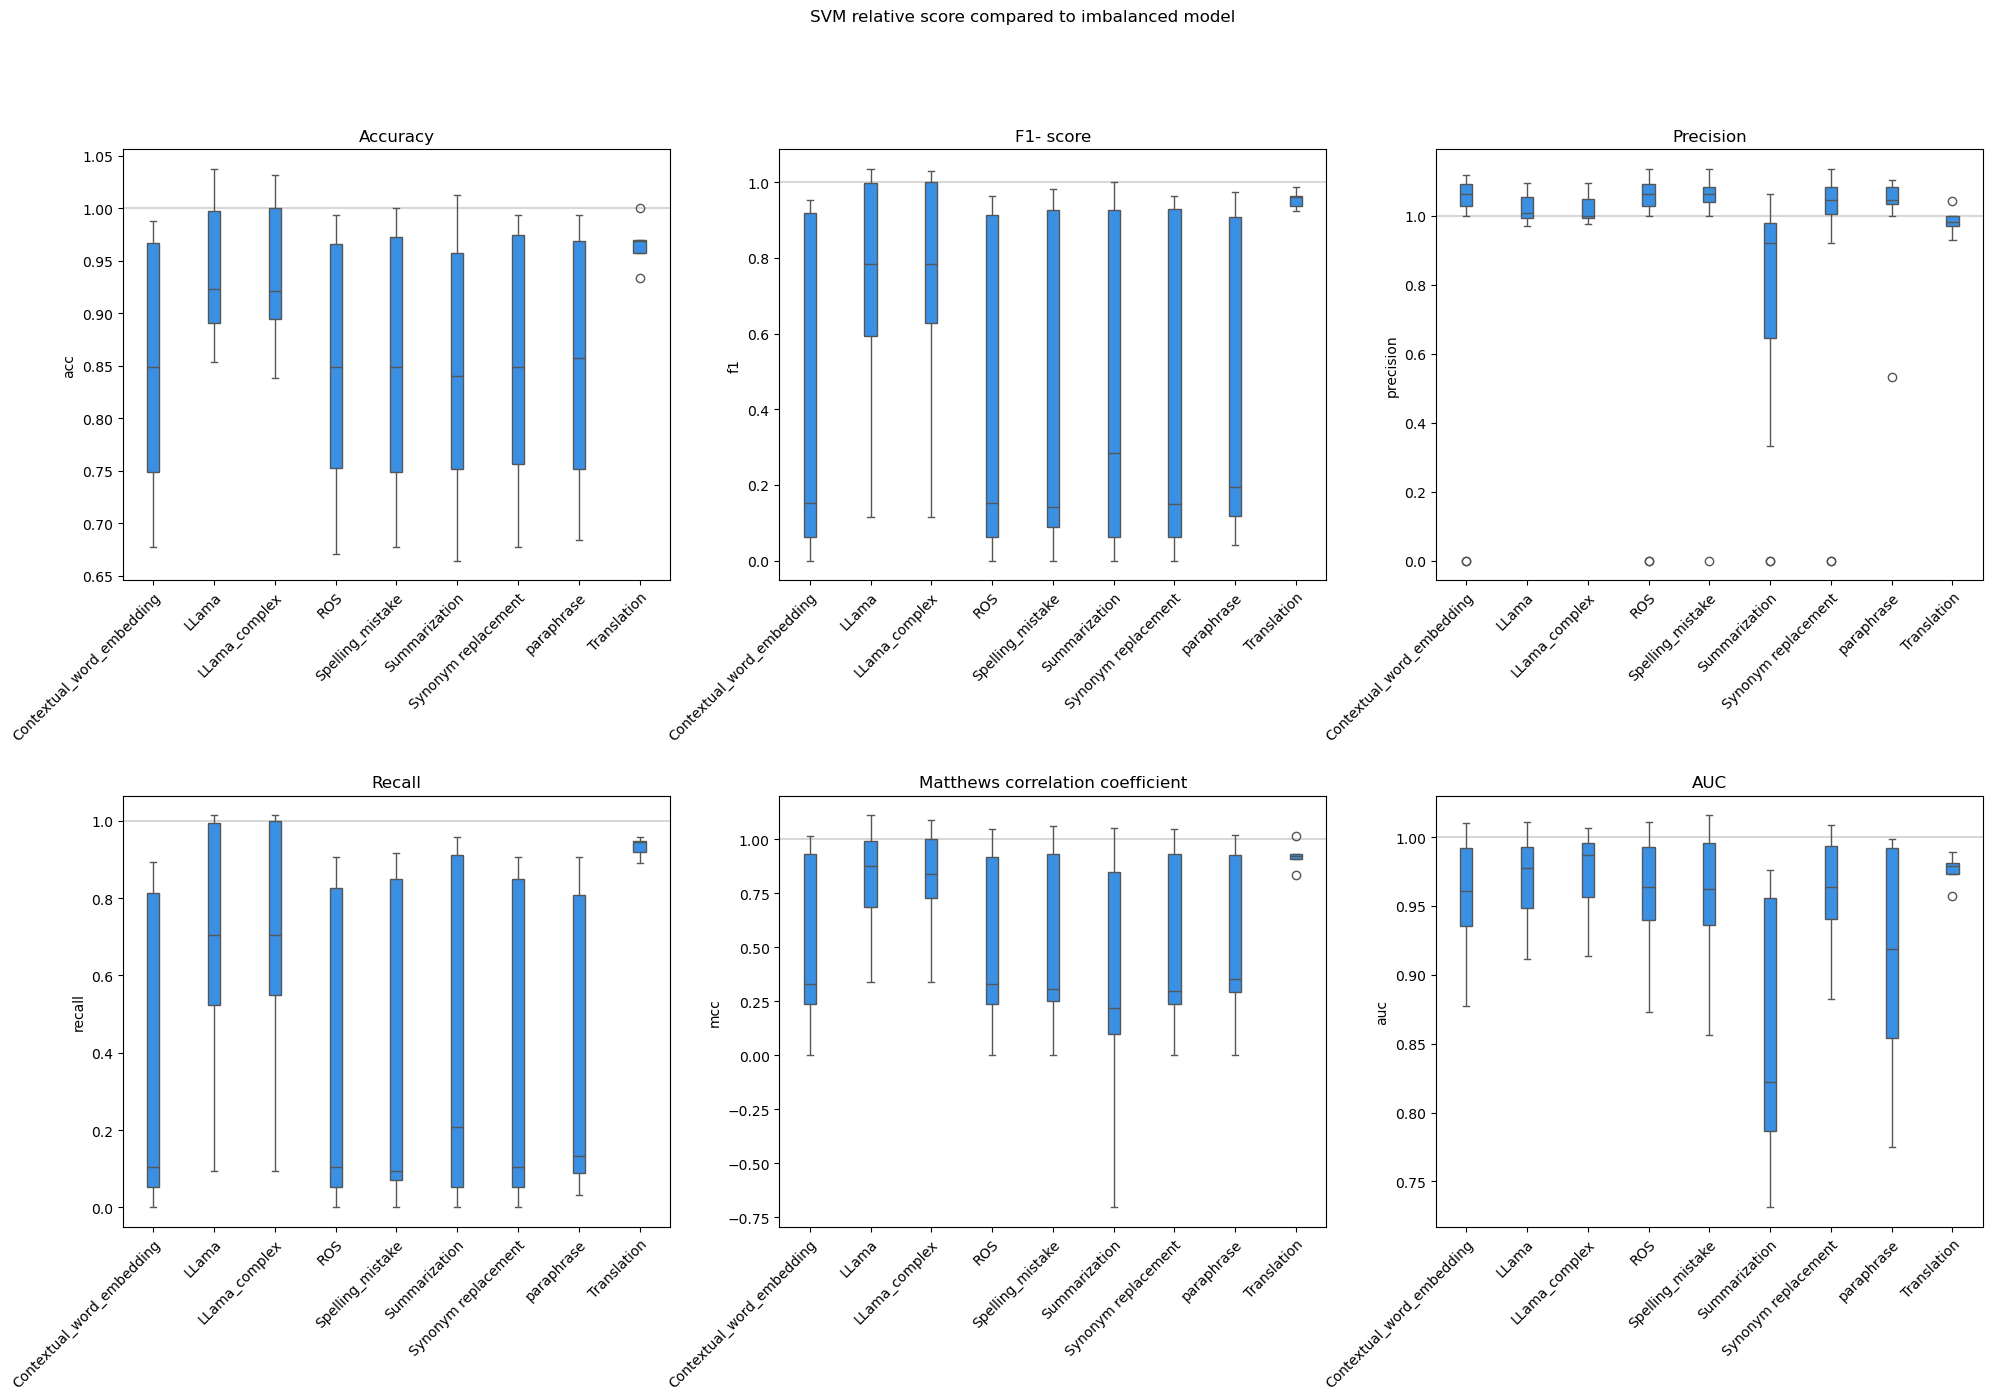

eraser_balancing_svm_rel.png


In [19]:
for model in np.unique(df_relative["Model name"]):
    boxplot(df_relative[df_relative["Model name"]==model], grouping = "Balancing method", title=model+" relative score compared to imbalanced model", relative = True)

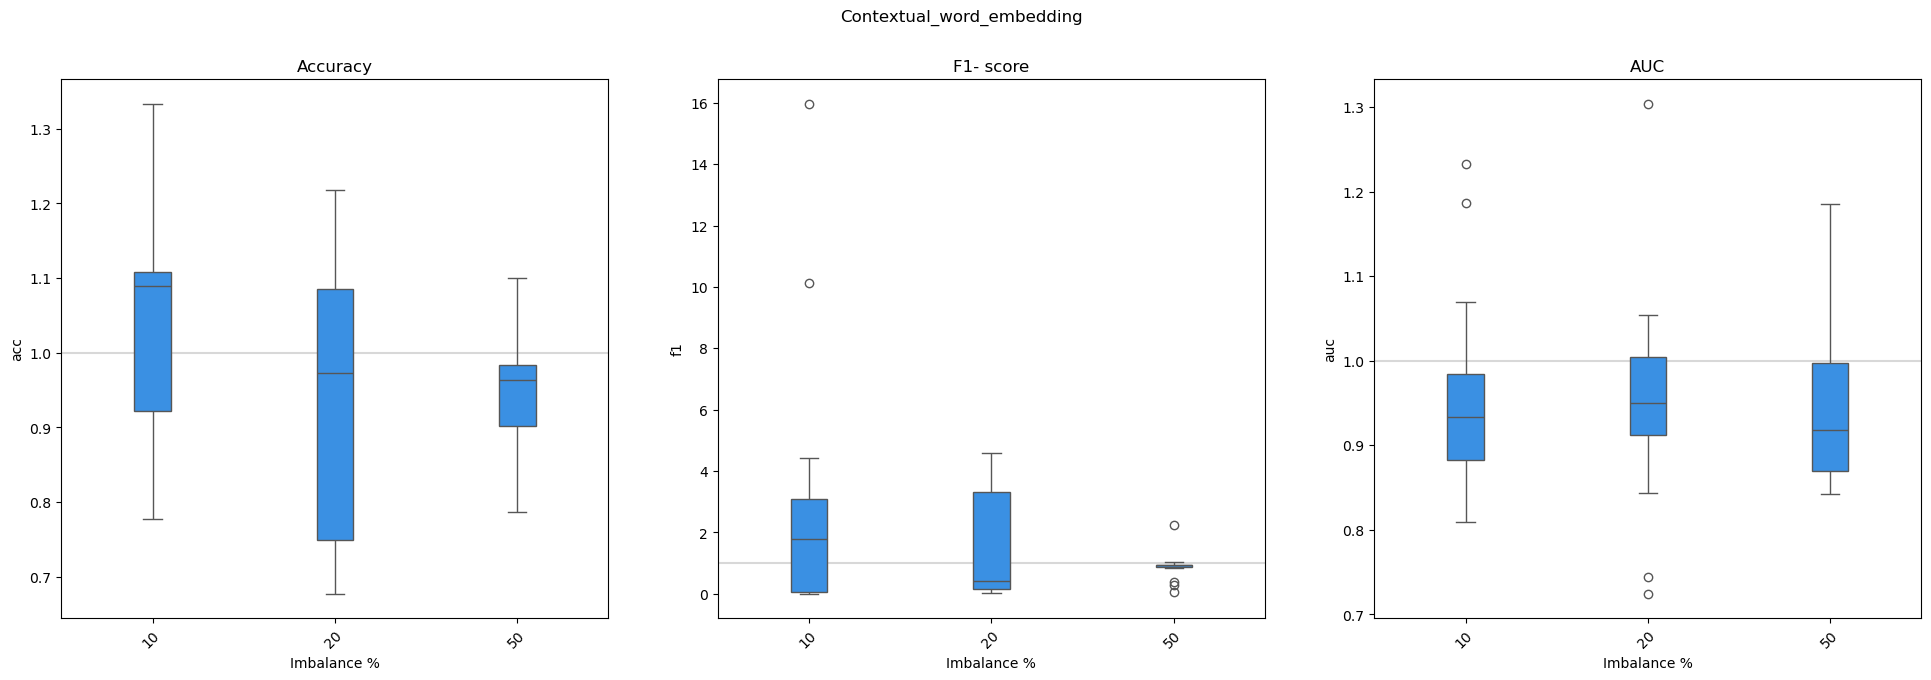

eraser_imbalance_contextual_word_embedding_rel.png


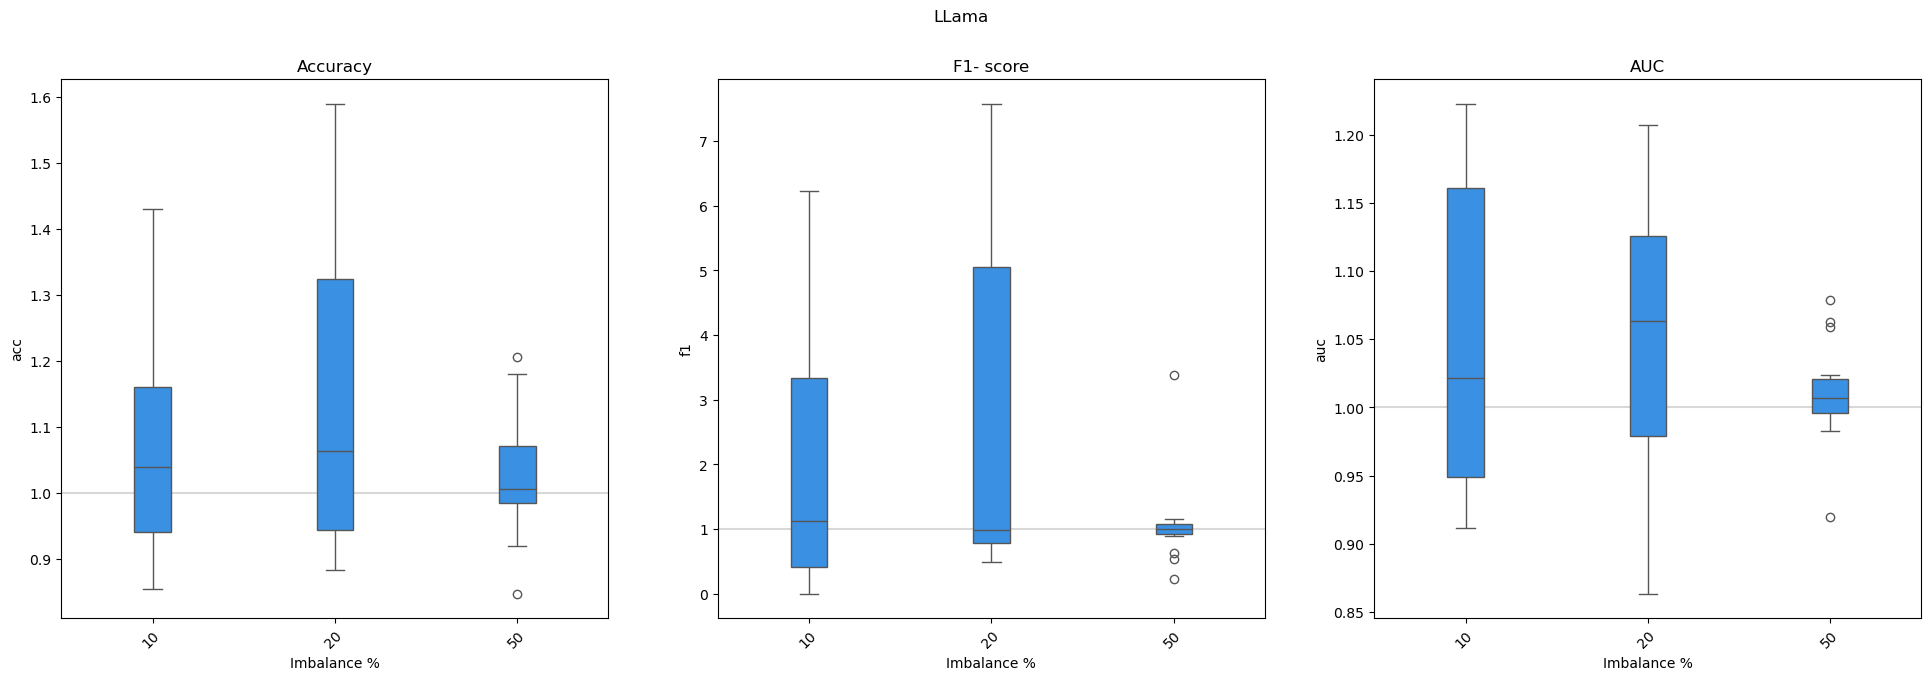

eraser_imbalance_llama_rel.png


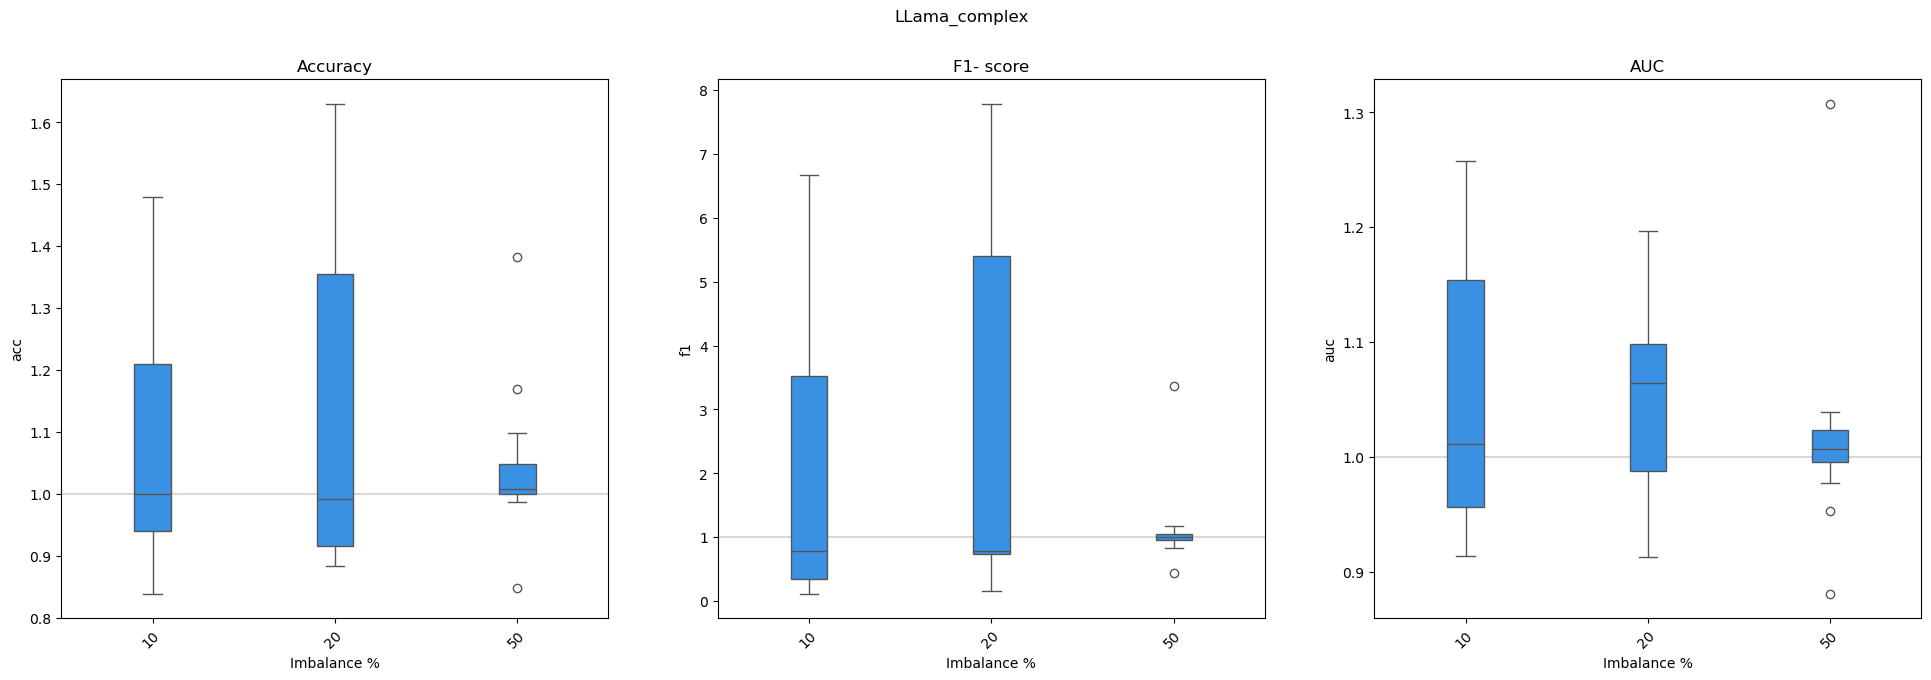

eraser_imbalance_llama_complex_rel.png


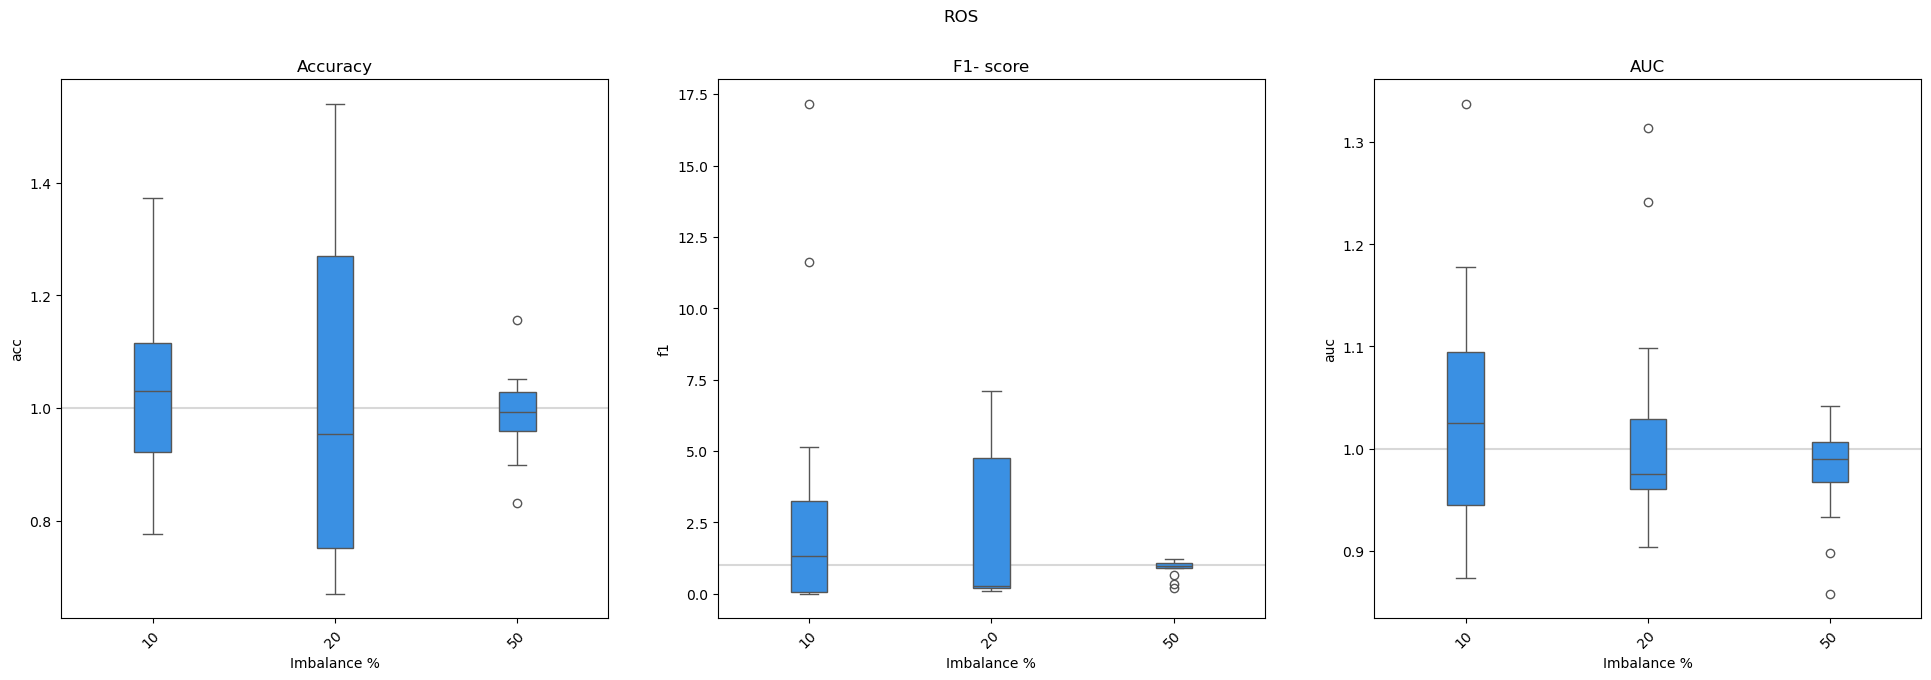

eraser_imbalance_ros_rel.png


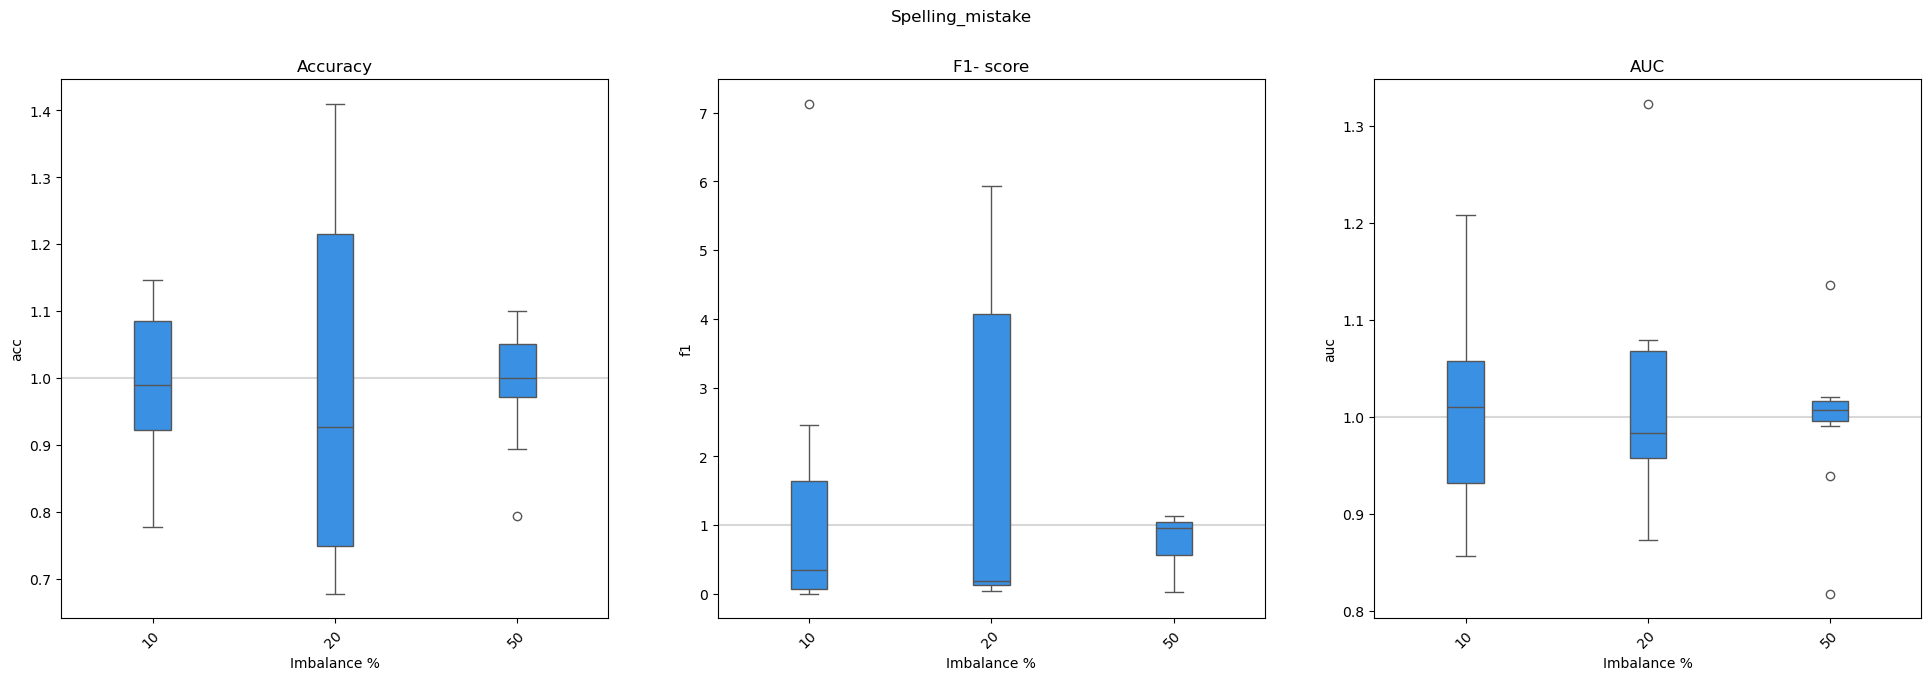

eraser_imbalance_spelling_mistake_rel.png


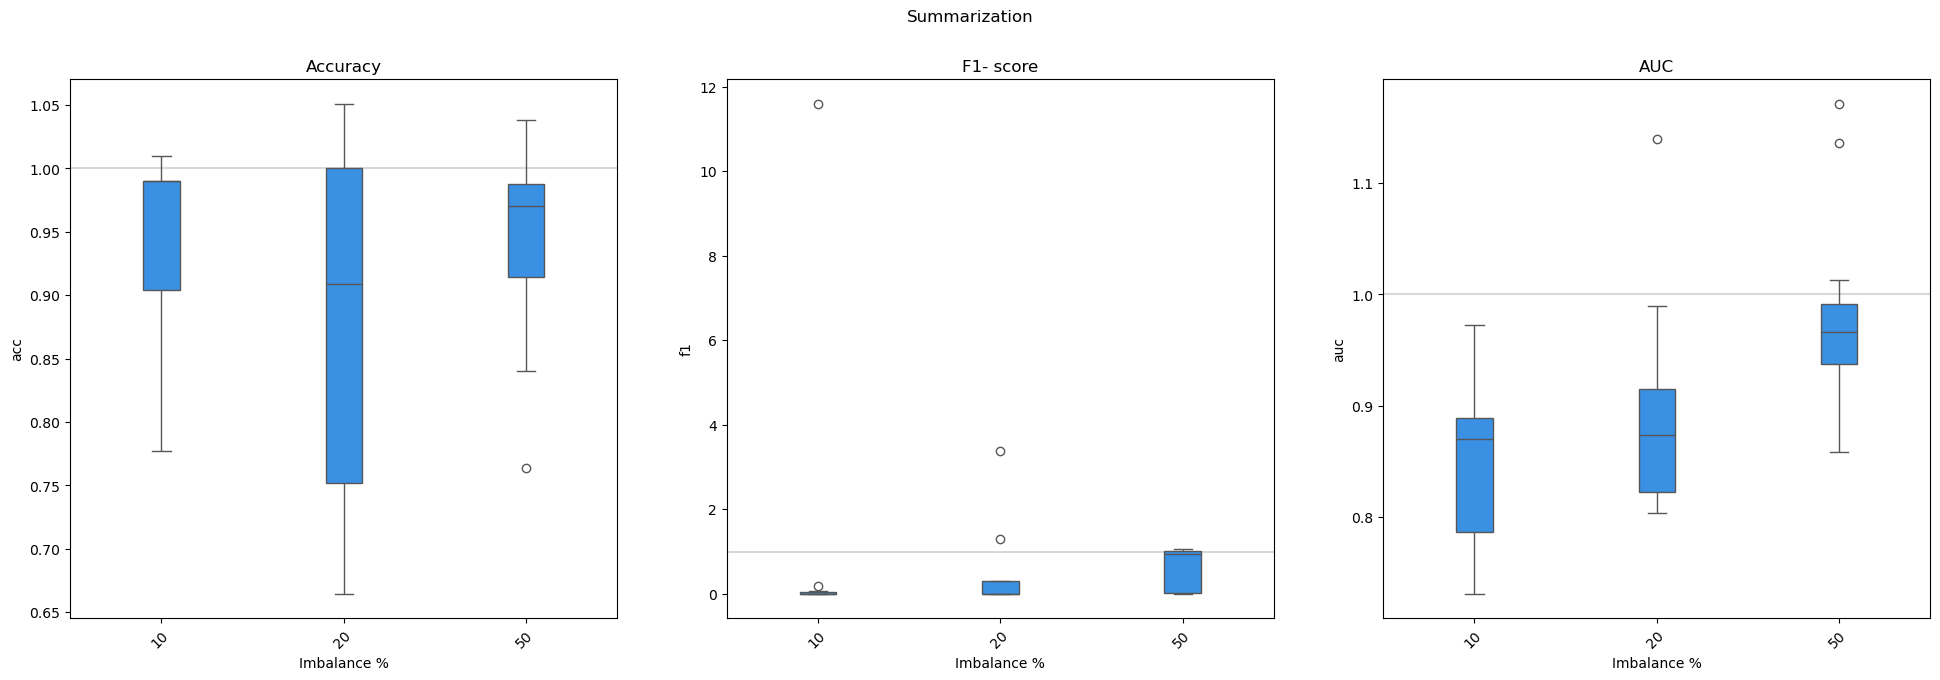

eraser_imbalance_summarization_rel.png


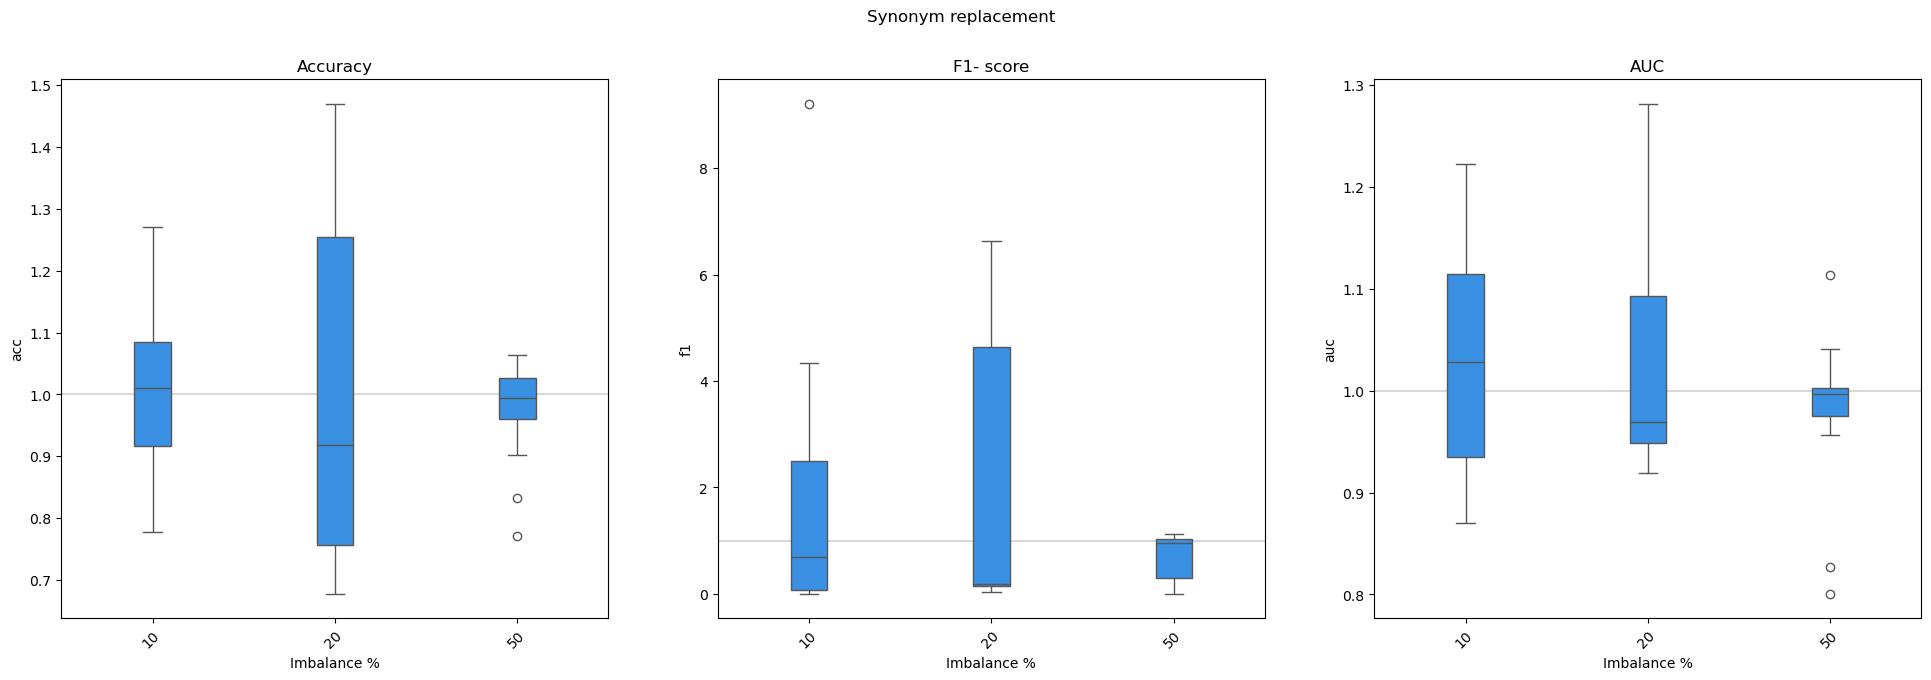

eraser_imbalance_synonym_rel.png


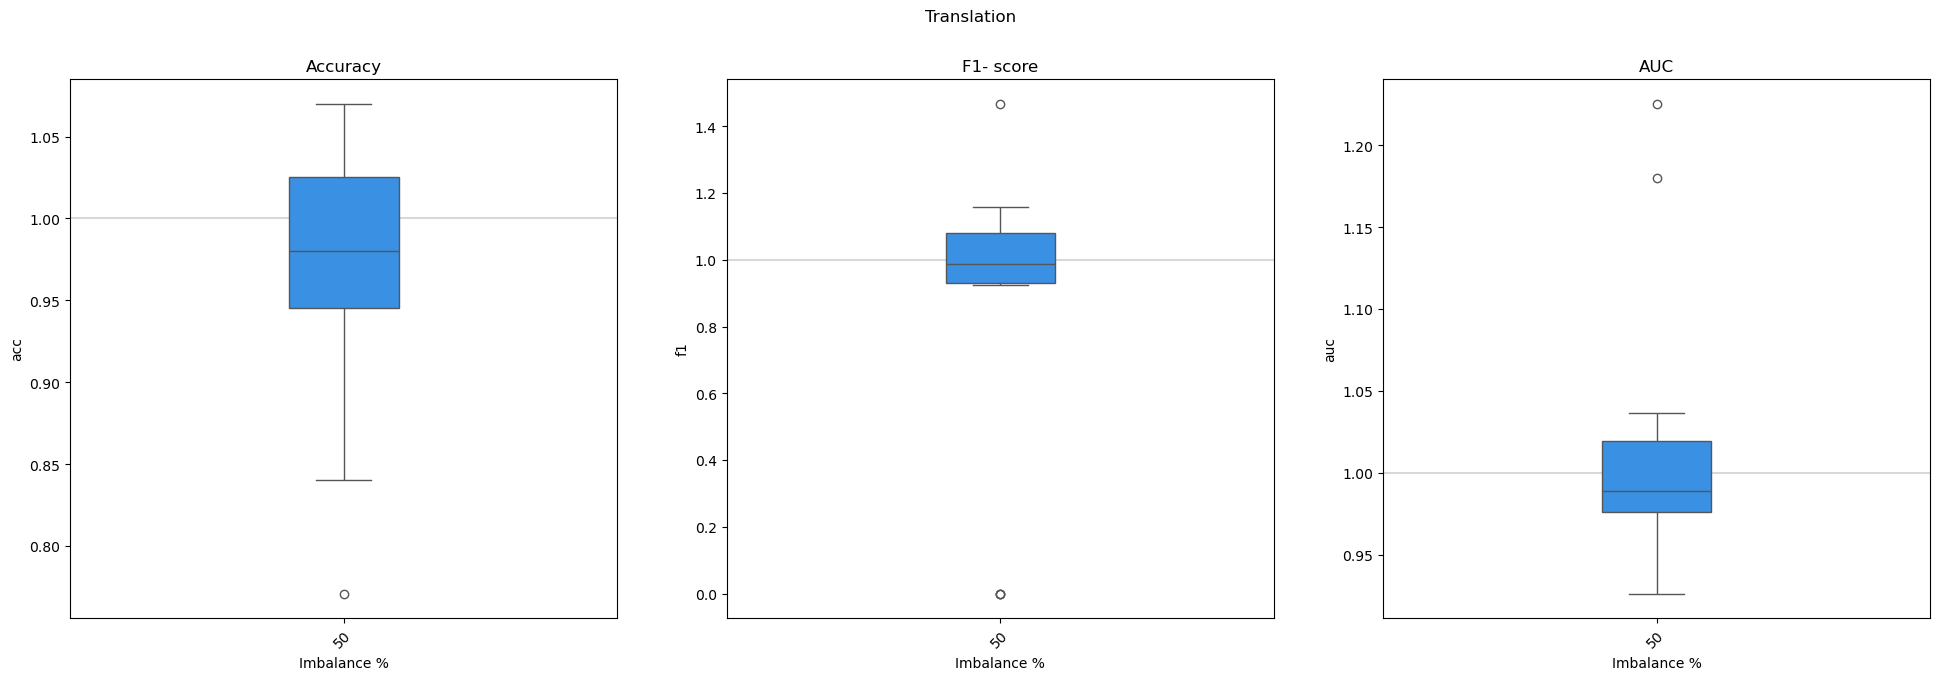

eraser_imbalance_translation_rel.png


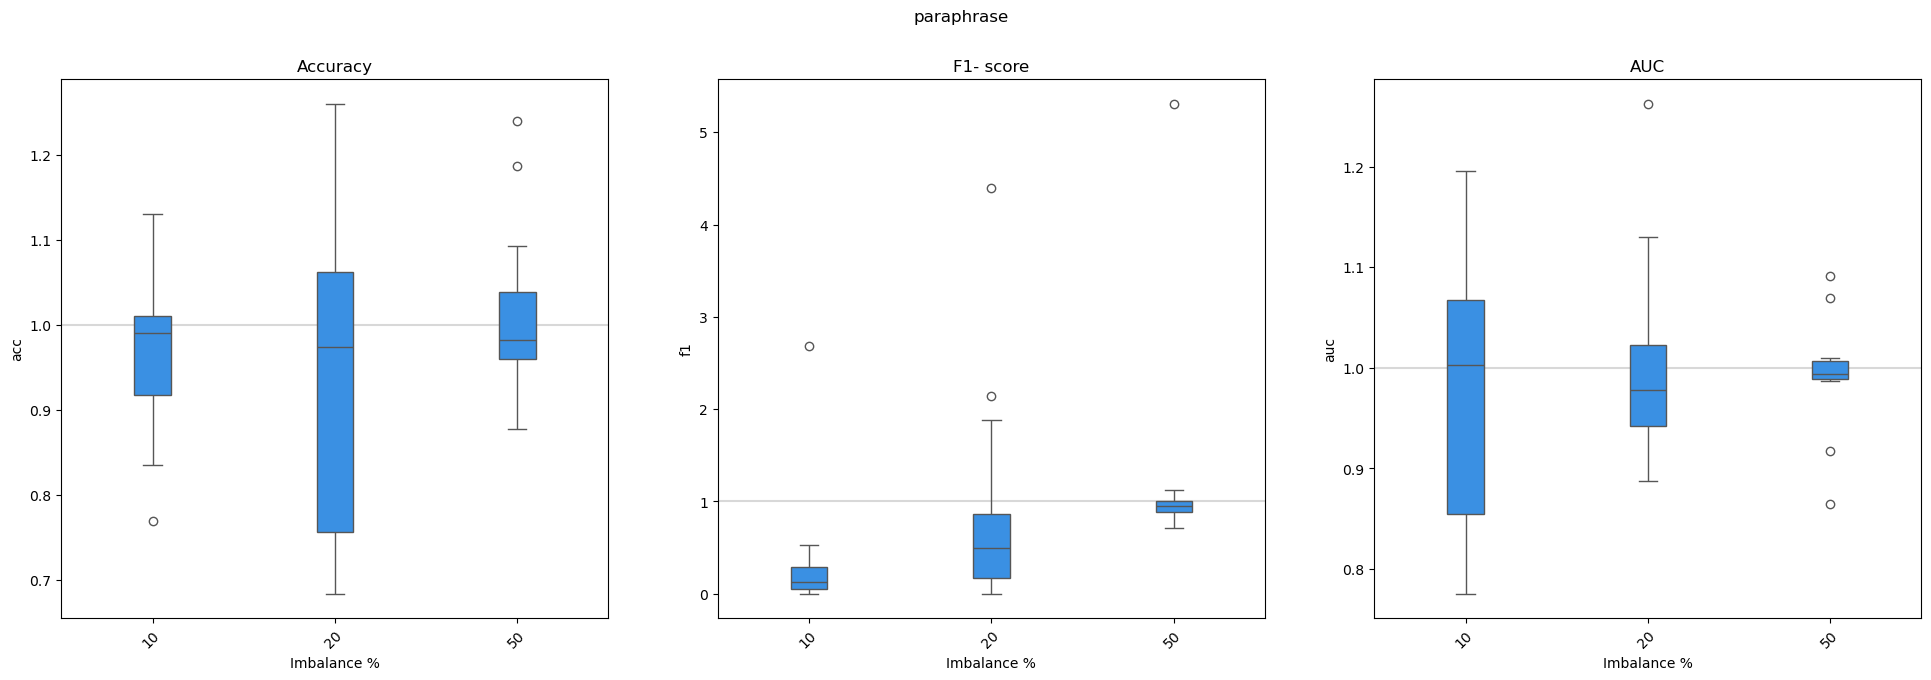

eraser_imbalance_paraphrase_rel.png


In [20]:
for method in np.unique(df_relative["Balancing method"]):
    if method=="original":continue
    df_tmp = df_relative[df_relative["Balancing method"]==method].reset_index(drop=True)
    boxplot(df_tmp, ["acc", "f1", "auc"], grouping = "Imbalance %", title=method, relative = True)

In [21]:
df.head()

Balancing method  Imbalance %  Model name  Model ID    acc  \
0  Contextual_word_embedding           10  DistilBERT         0  0.545   
1  Contextual_word_embedding           10  DistilBERT         1  0.555   
2  Contextual_word_embedding           10  DistilBERT         2  0.535   
3  Contextual_word_embedding           10  DistilBERT         3  0.550   
4  Contextual_word_embedding           10  DistilBERT         4  0.575   

         f1  precision  recall       mcc     auc  spearman  spearman_pval  
0  0.180180   0.909091    0.10  0.197386  0.6450  0.546053       0.102479  
1  0.252101   0.789474    0.15  0.187576  0.6995  0.762209       0.010379  
2  0.176991   0.769231    0.10  0.141973  0.5789  0.560066       0.092227  
3  0.296875   0.678571    0.19  0.144098  0.6039  0.658549       0.038400  
4  0.320000   0.800000    0.20  0.226779  0.6631  0.829284       0.003008

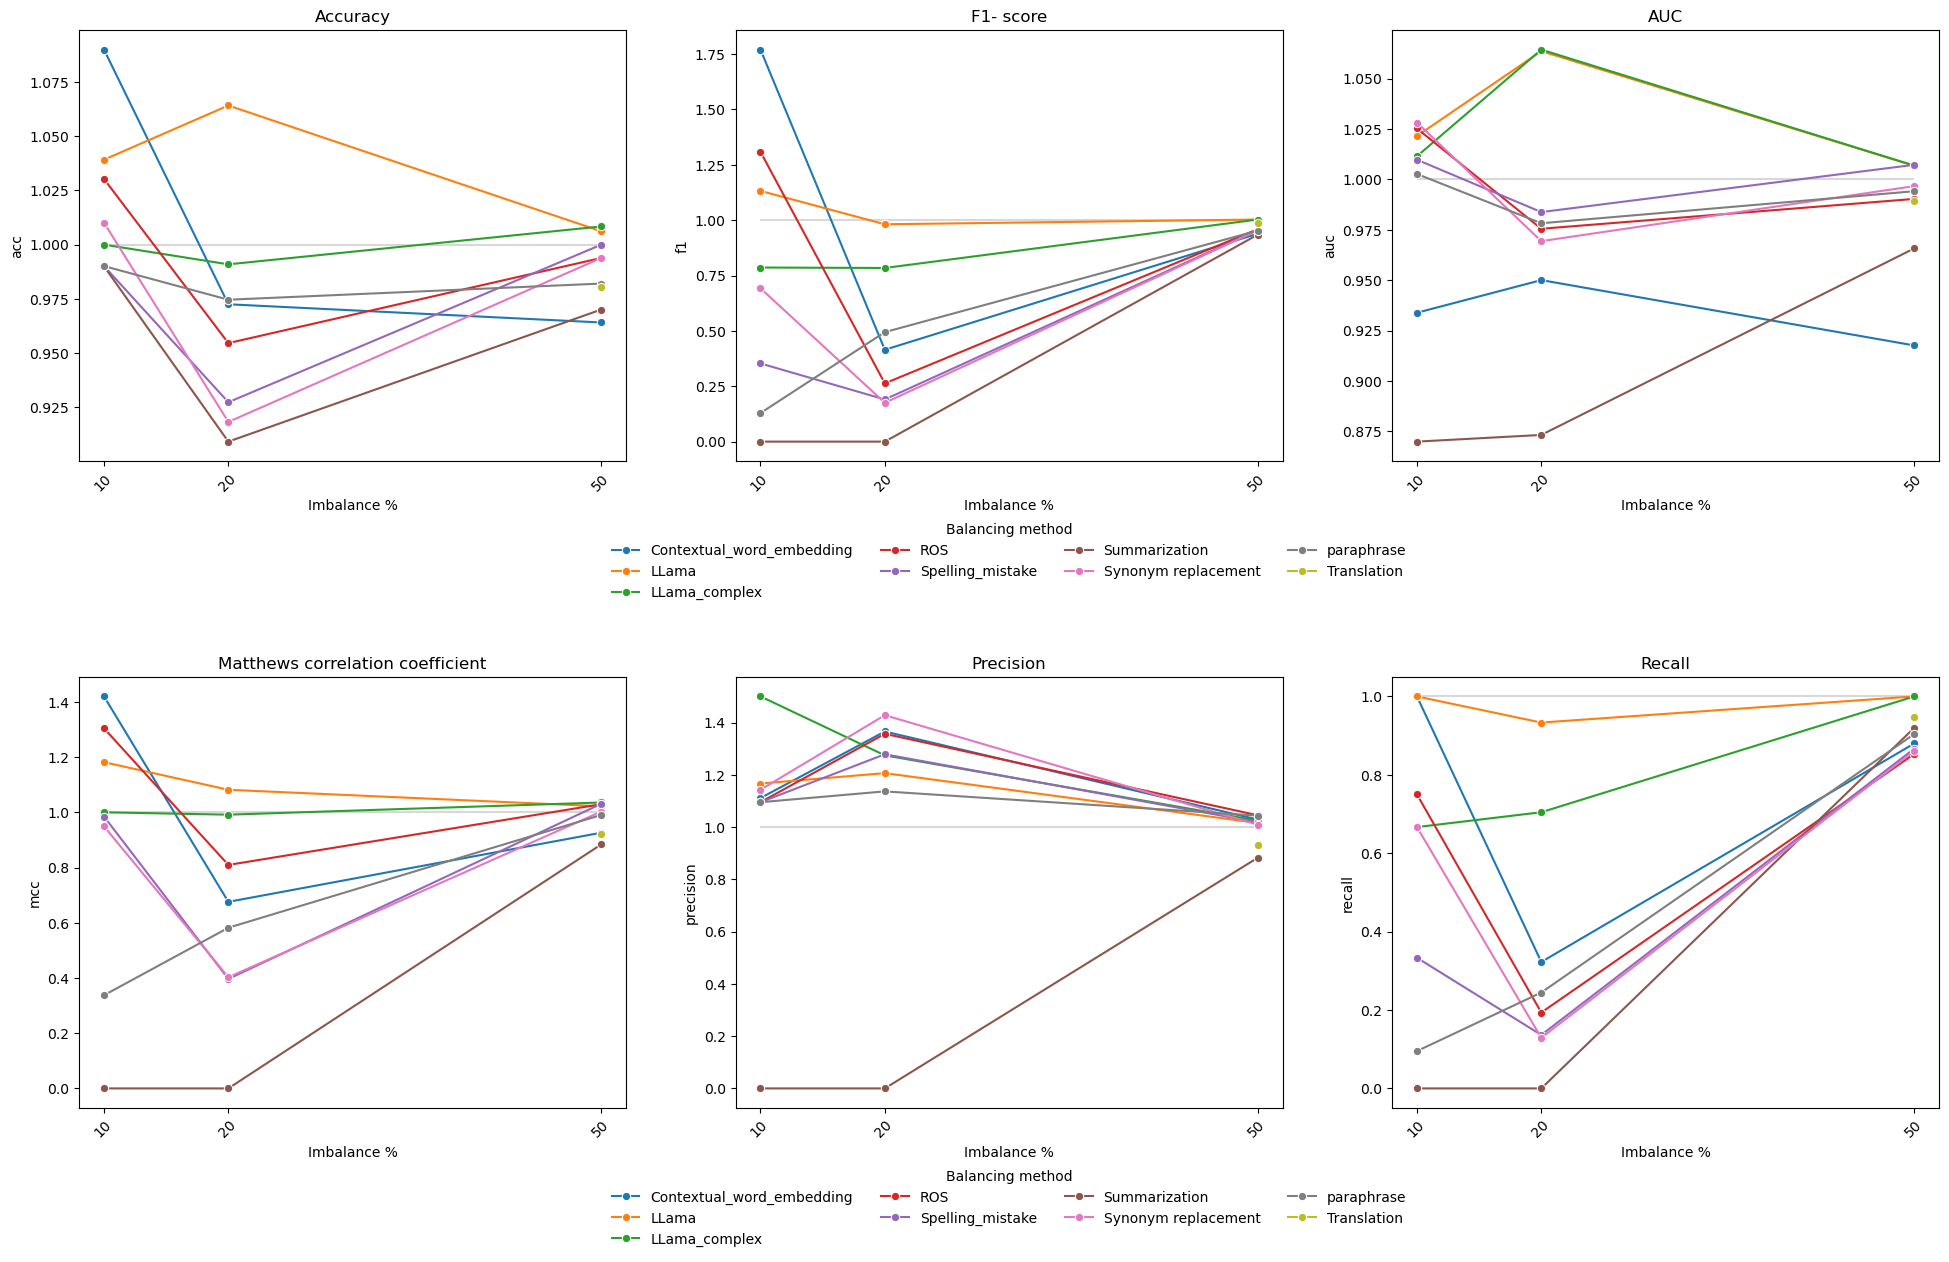

eraser_imbalance_rel_line.png


In [22]:

median_plot(df_relative, measures = ["acc", "f1", "auc", "mcc", "precision", "recall"], grouping = "Balancing method", relative = True, title=None)

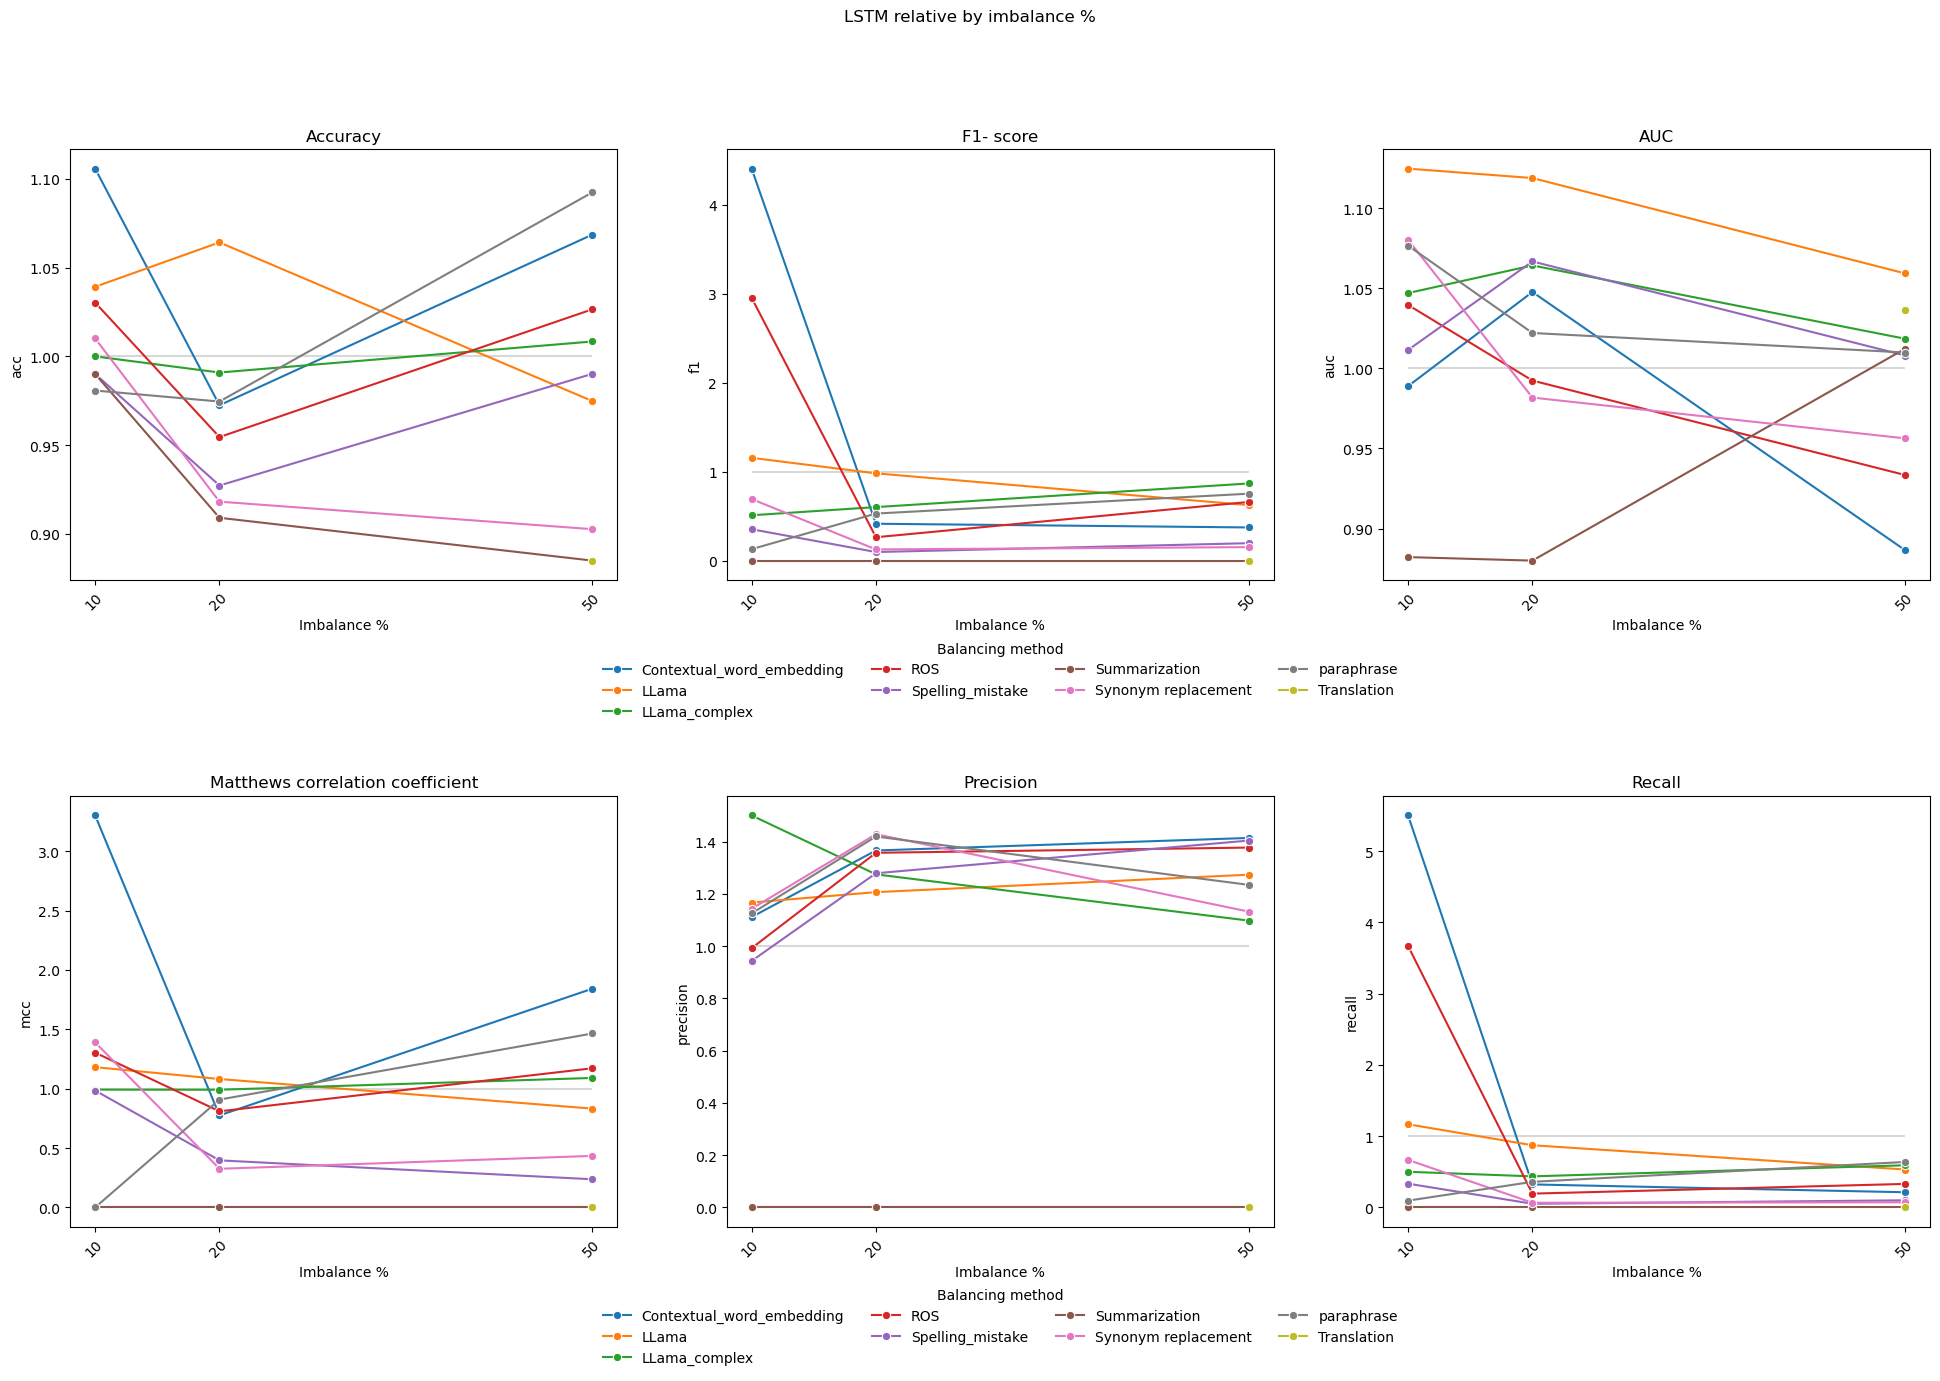

eraser_imbalance_lstm_rel_line.png


In [39]:

median_plot(df_relative[df_relative["Model name"]=="LSTM"], measures = ["acc", "f1", "auc", "mcc", "precision", "recall"], grouping = "Balancing method", relative = True, title="LSTM relative by imbalance %")

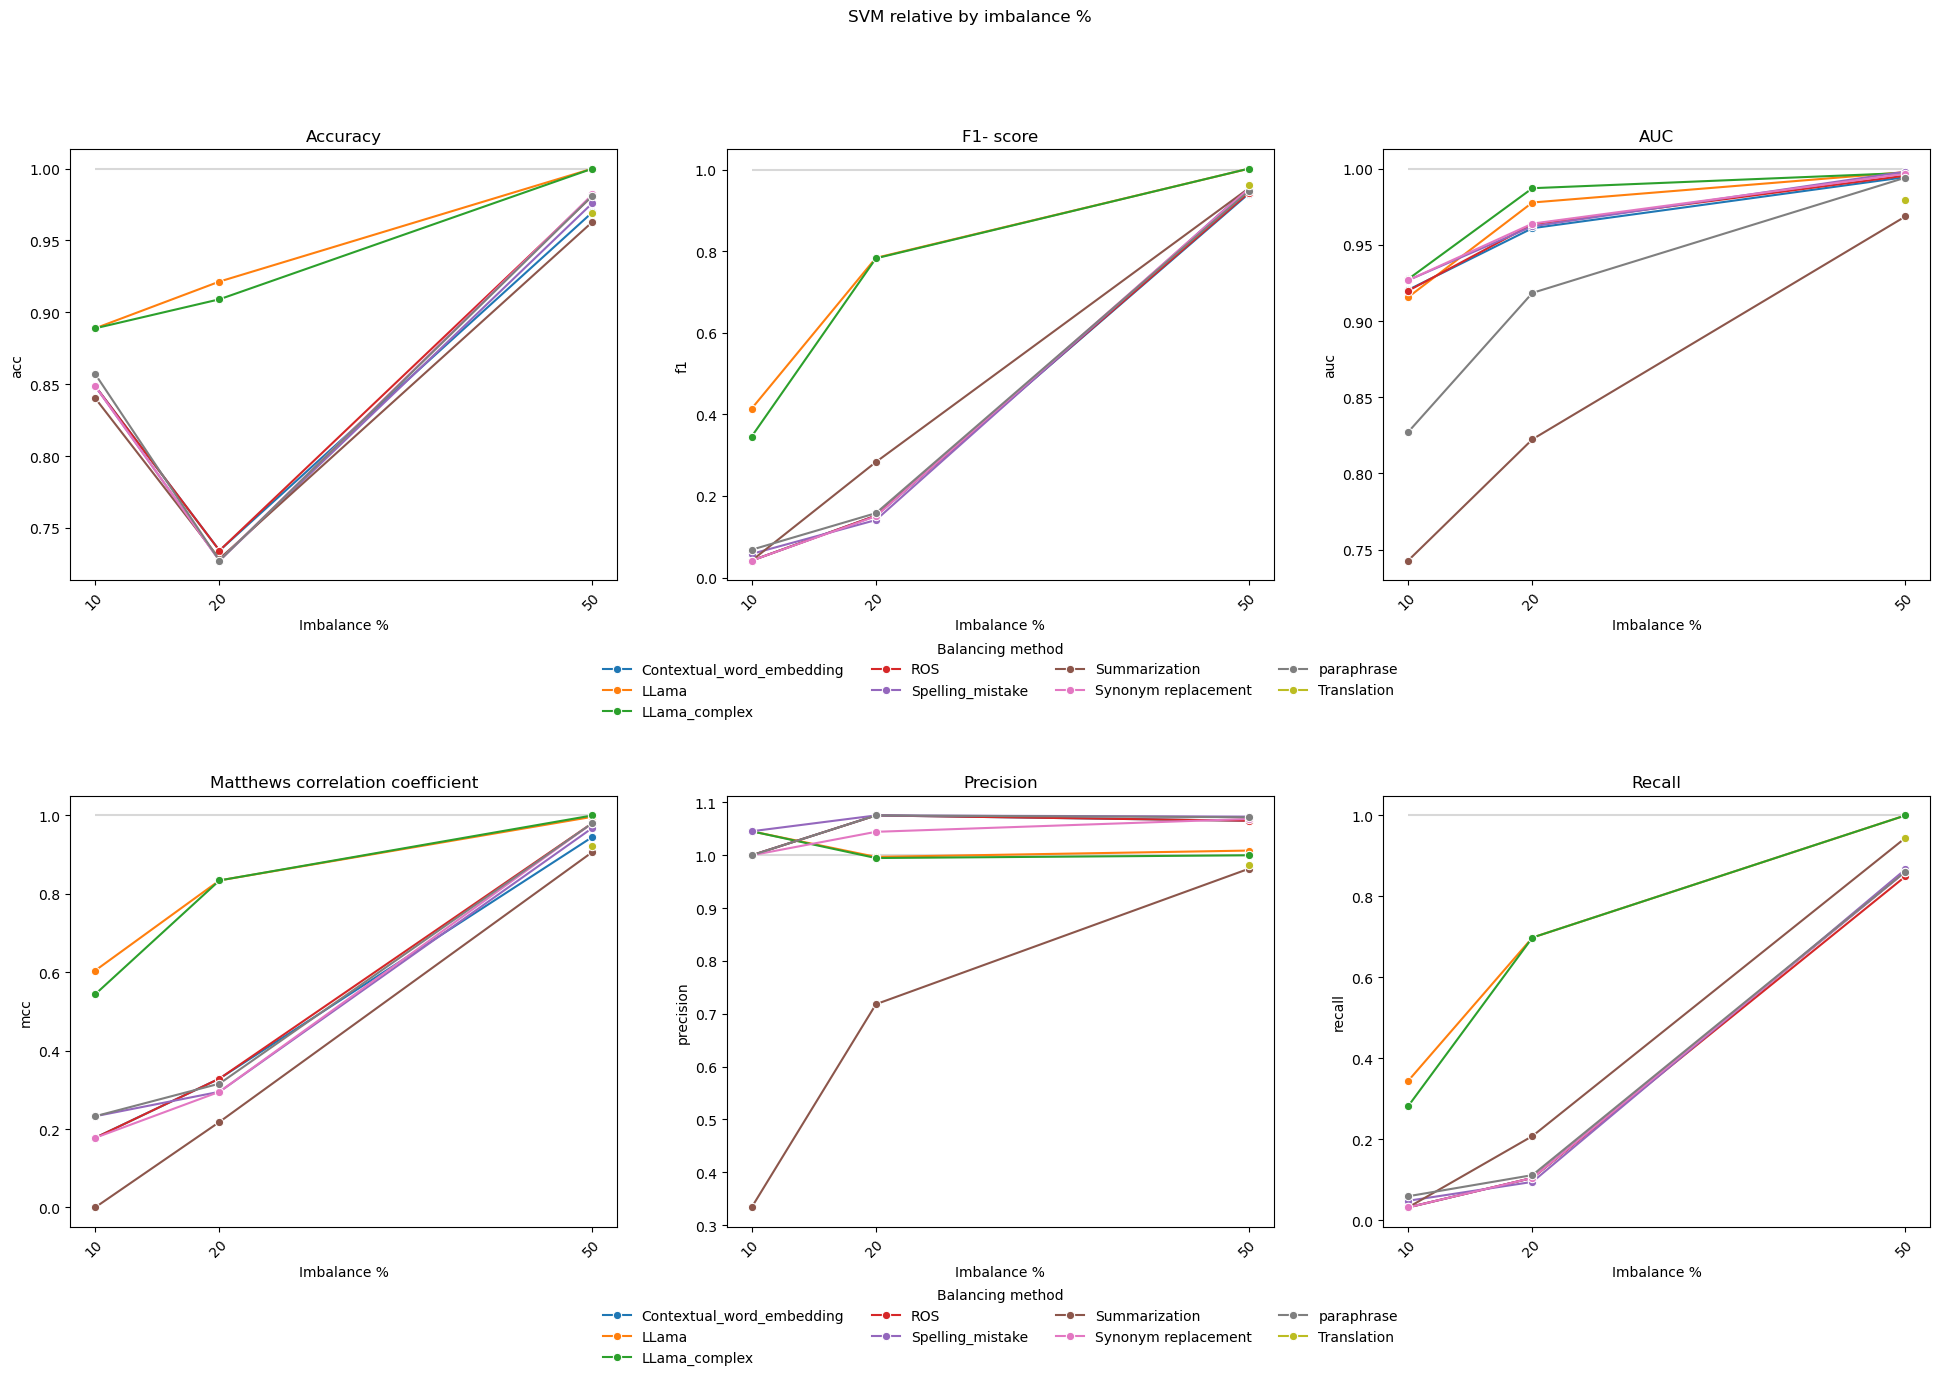

eraser_imbalance_svm_rel_line.png


In [41]:

median_plot(df_relative[df_relative["Model name"]=="SVM"], measures = ["acc", "f1", "auc", "mcc", "precision", "recall"], grouping = "Balancing method", relative = True, title="SVM relative by imbalance %")

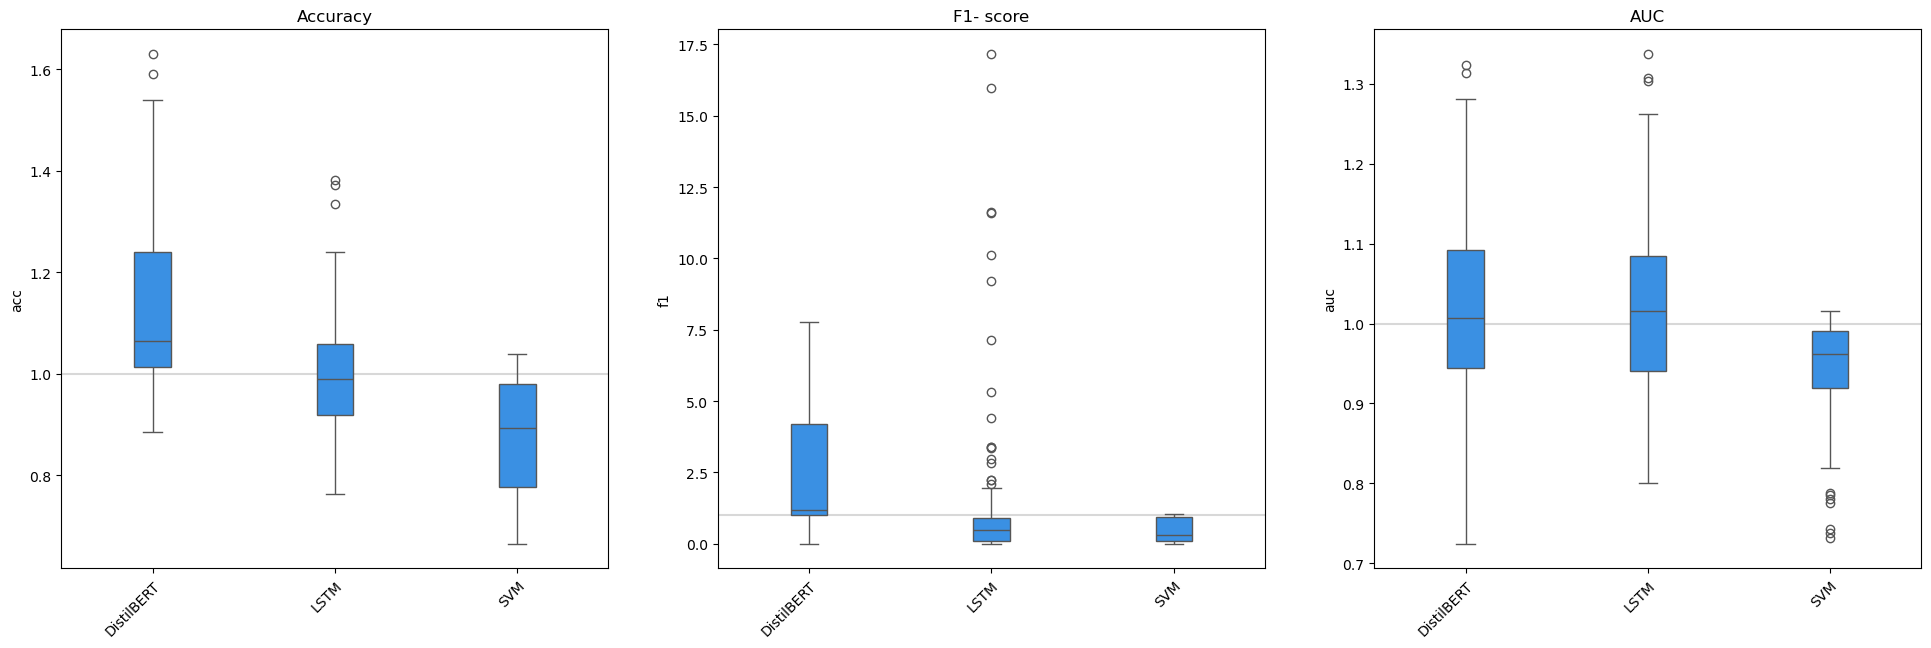

eraser_model_rel.png


In [25]:
boxplot(df_relative, ["acc", "f1", "auc"], grouping = "Model name", relative = True)

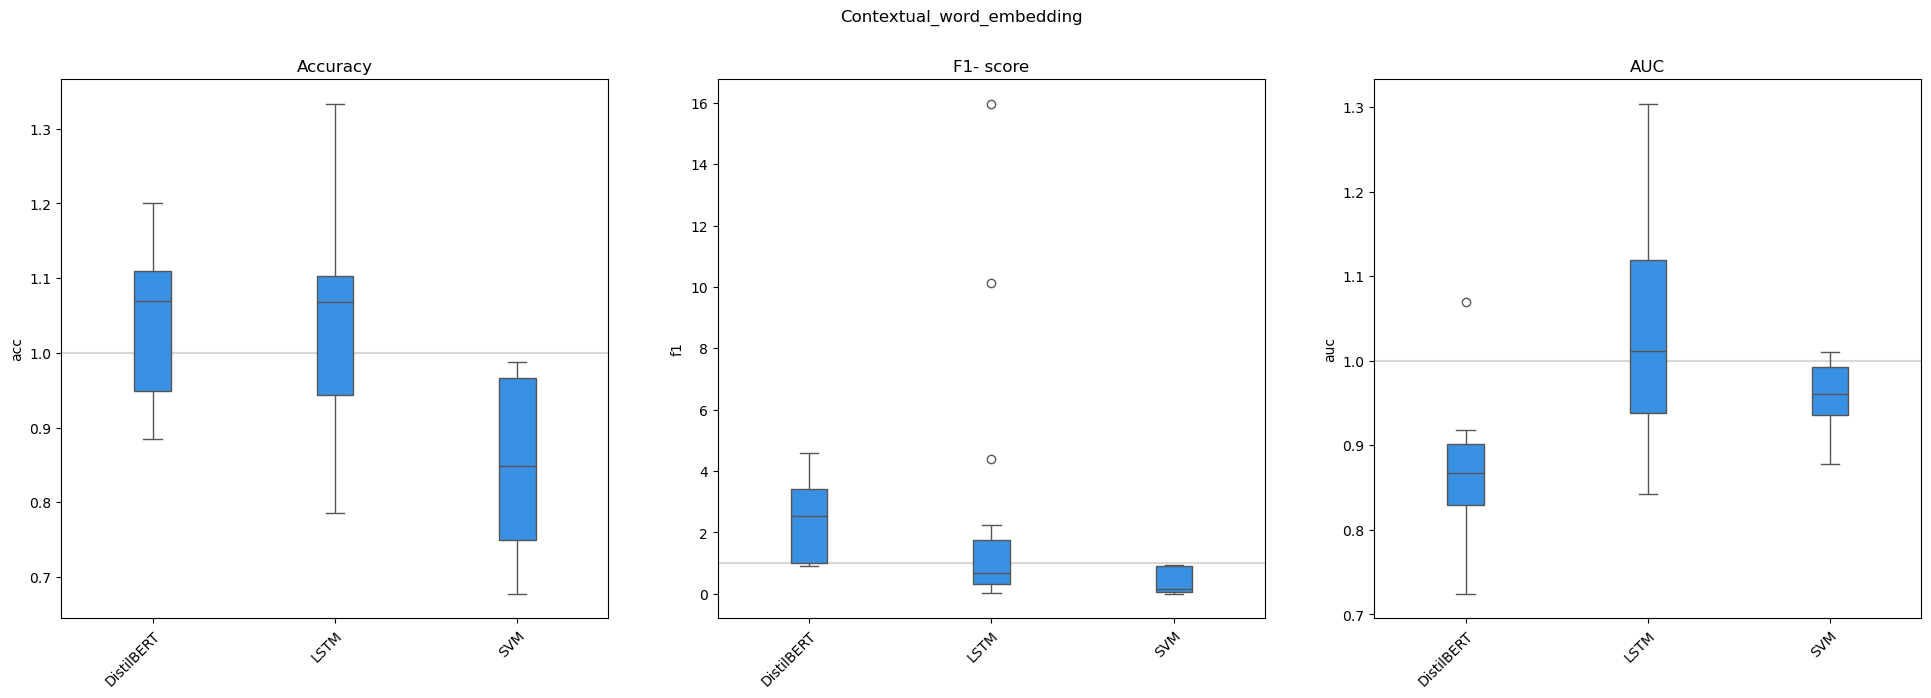

eraser_model_contextual_word_embedding_rel.png


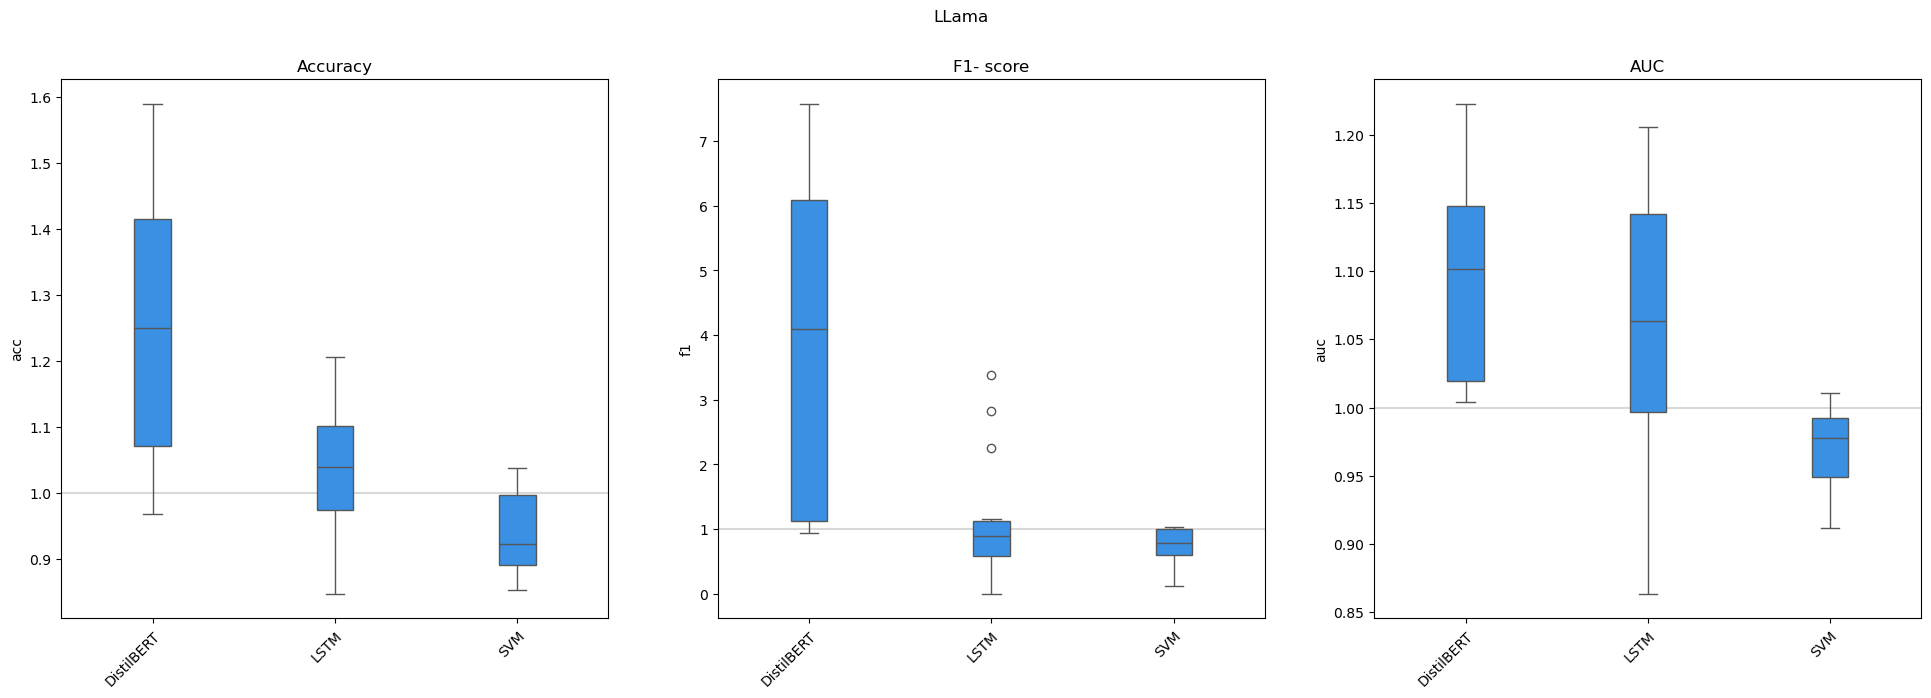

eraser_model_llama_rel.png


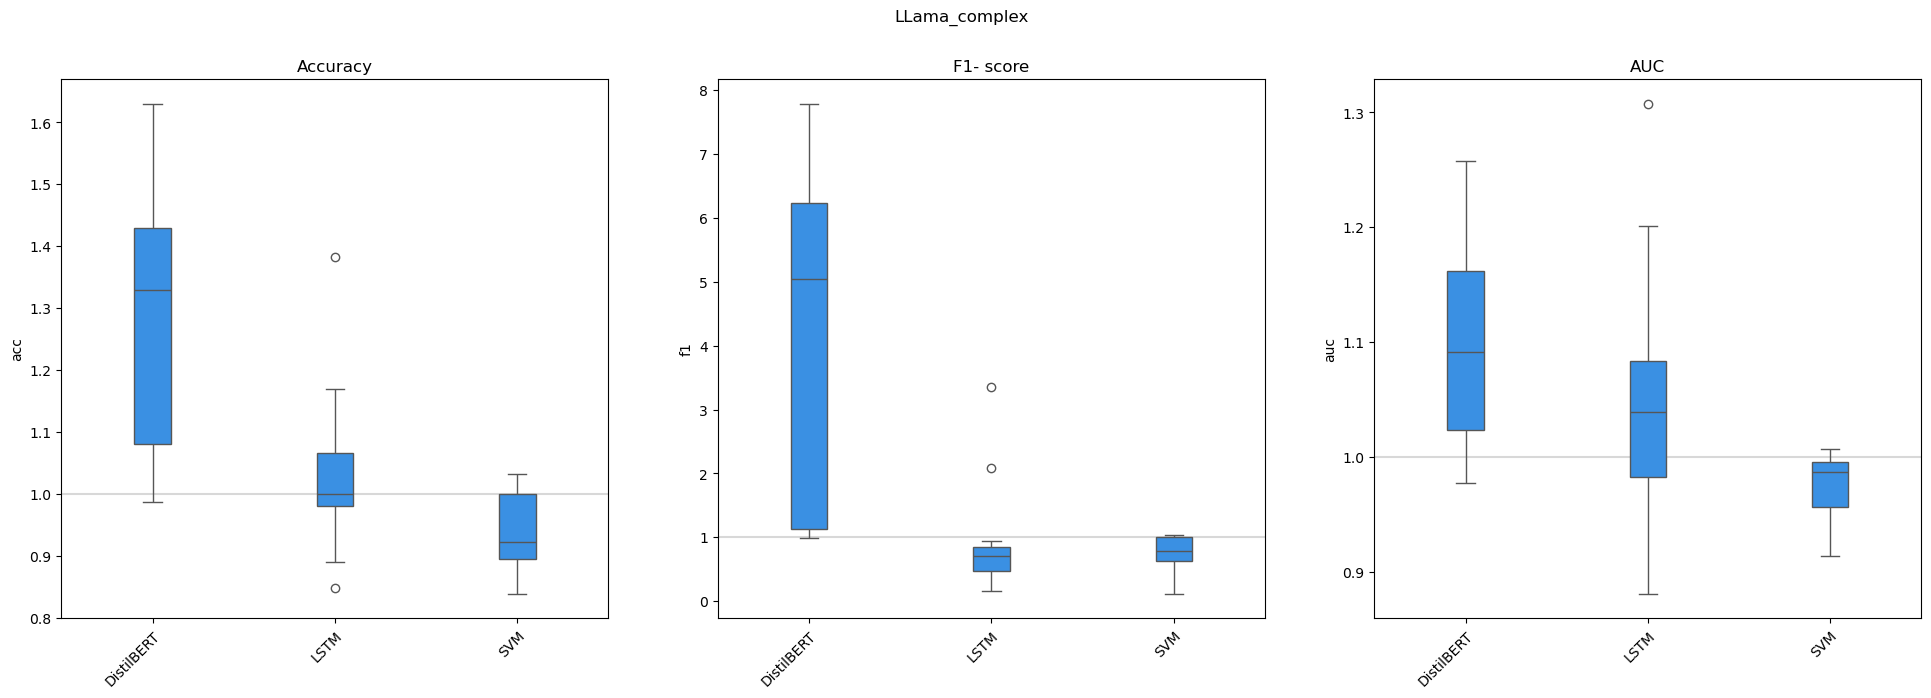

eraser_model_llama_complex_rel.png


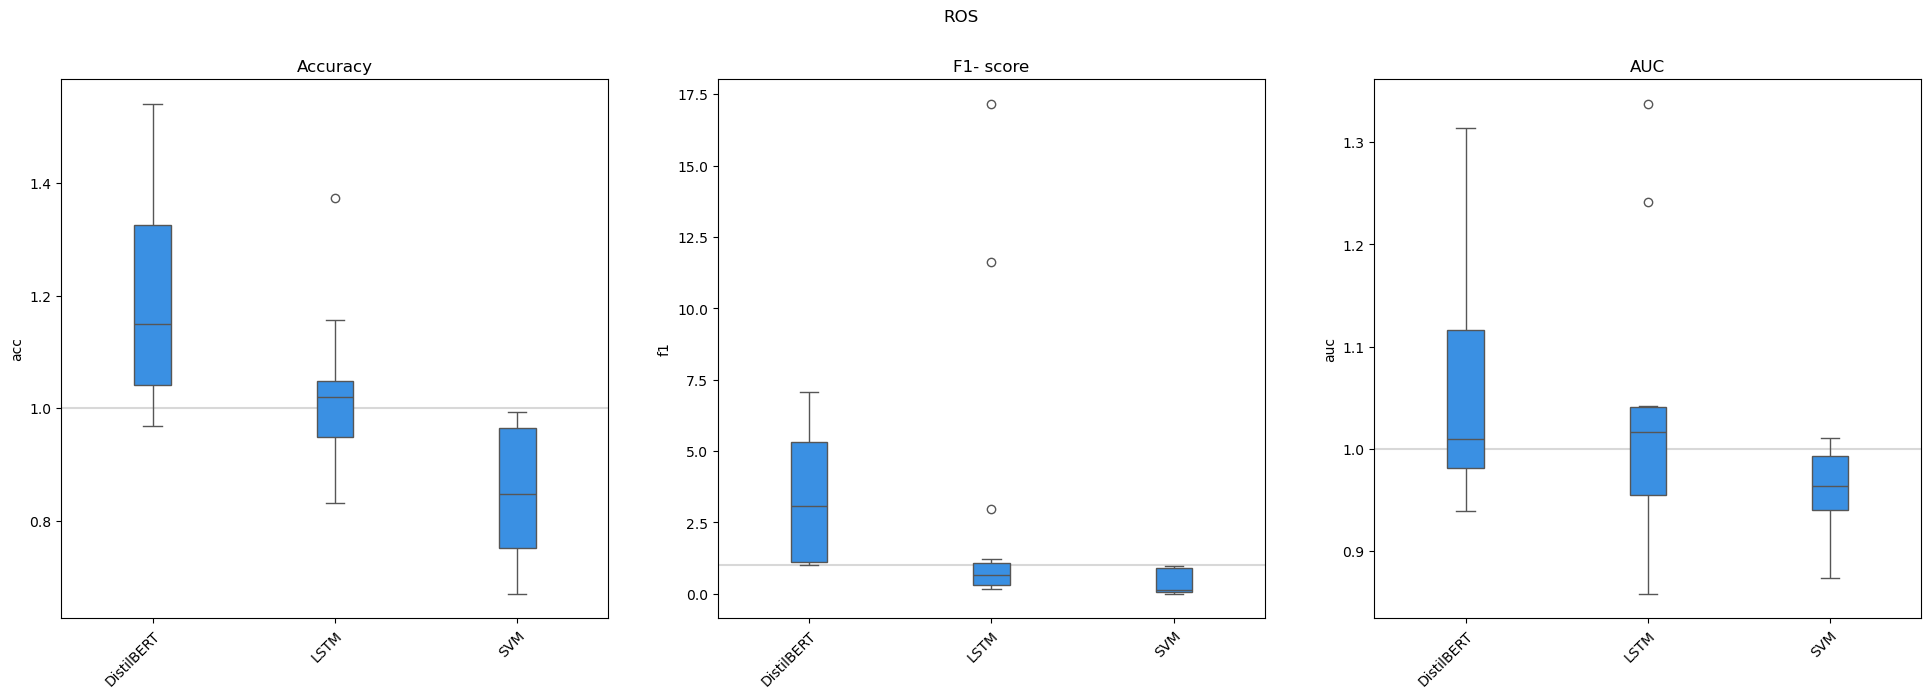

eraser_model_ros_rel.png


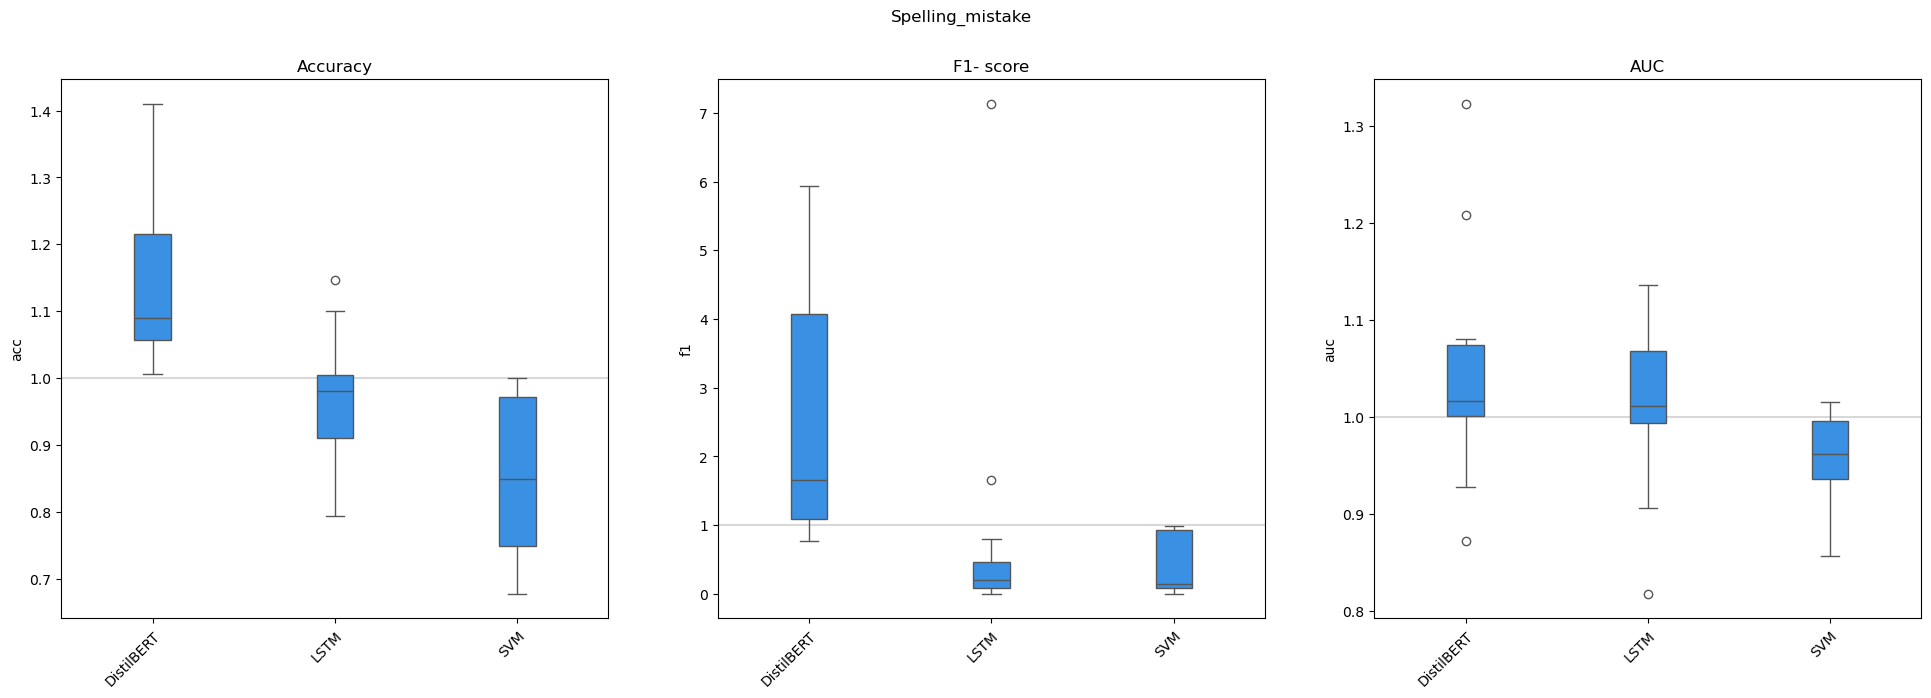

eraser_model_spelling_mistake_rel.png


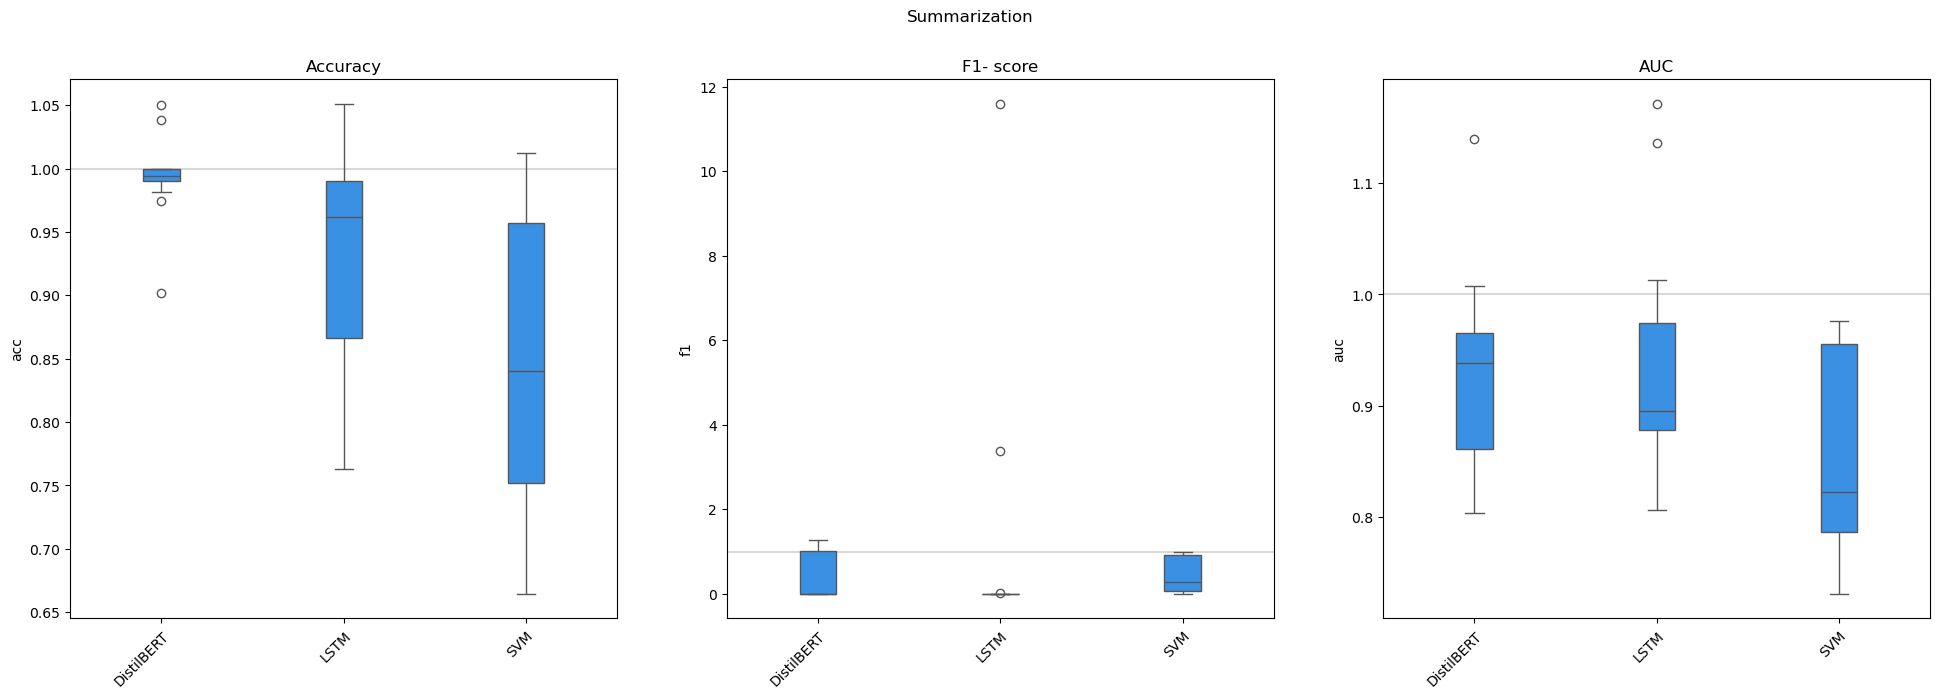

eraser_model_summarization_rel.png


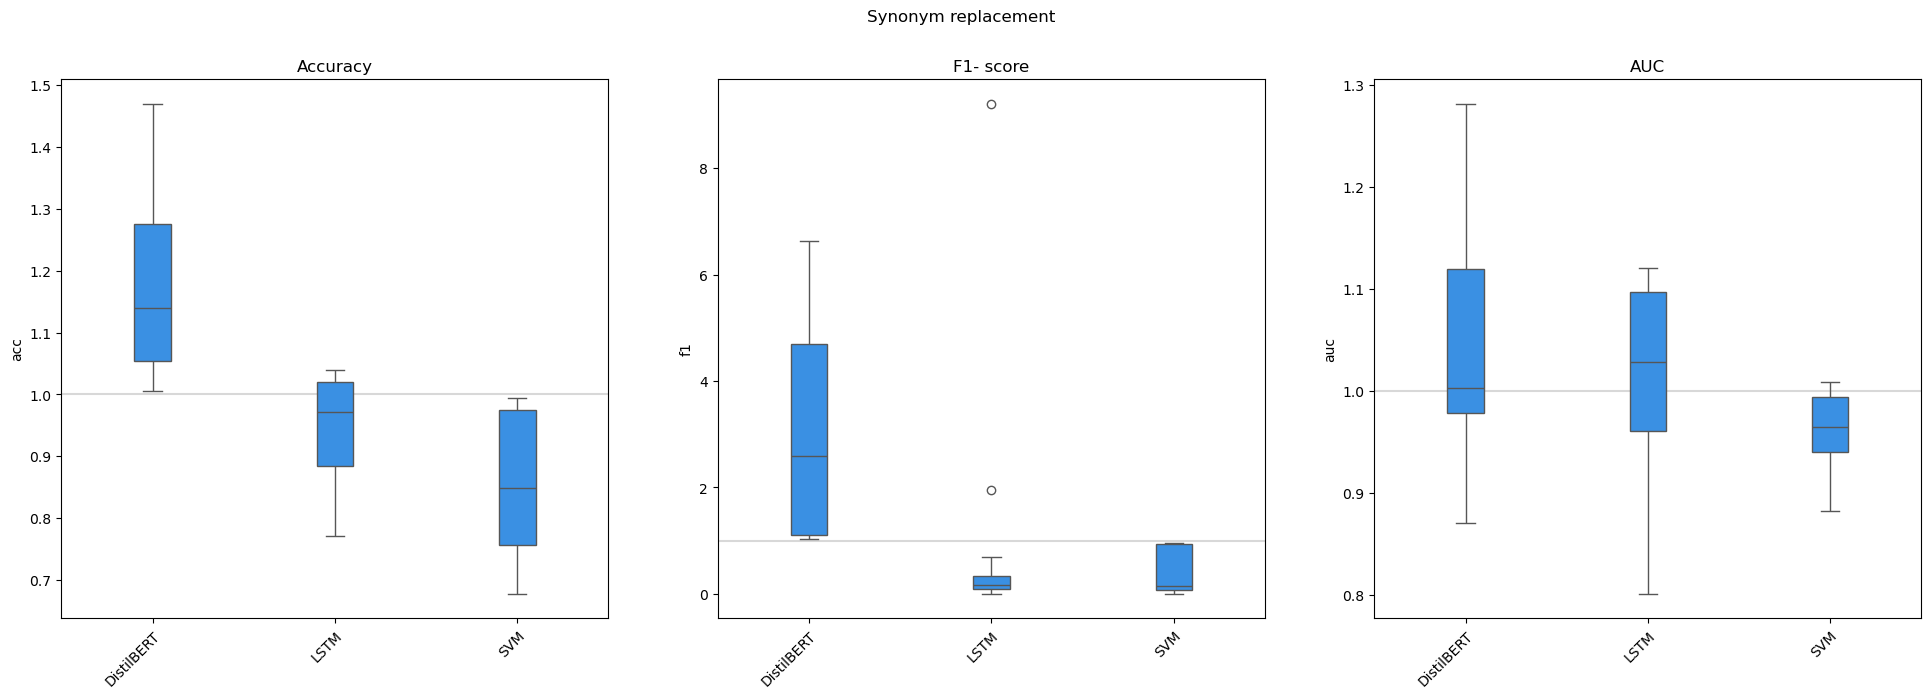

eraser_model_synonym_rel.png


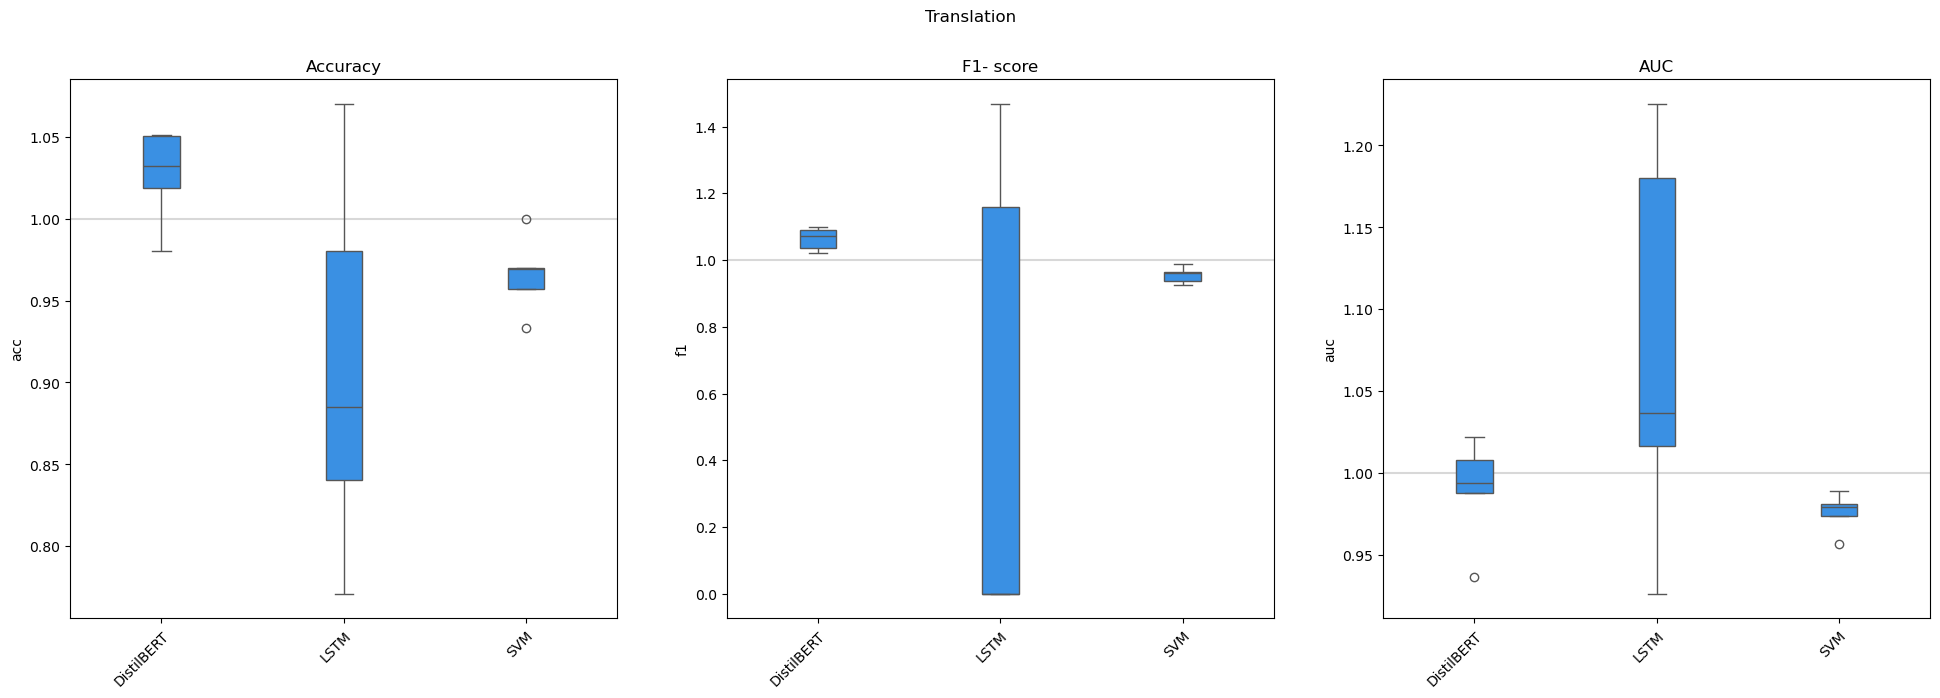

eraser_model_translation_rel.png


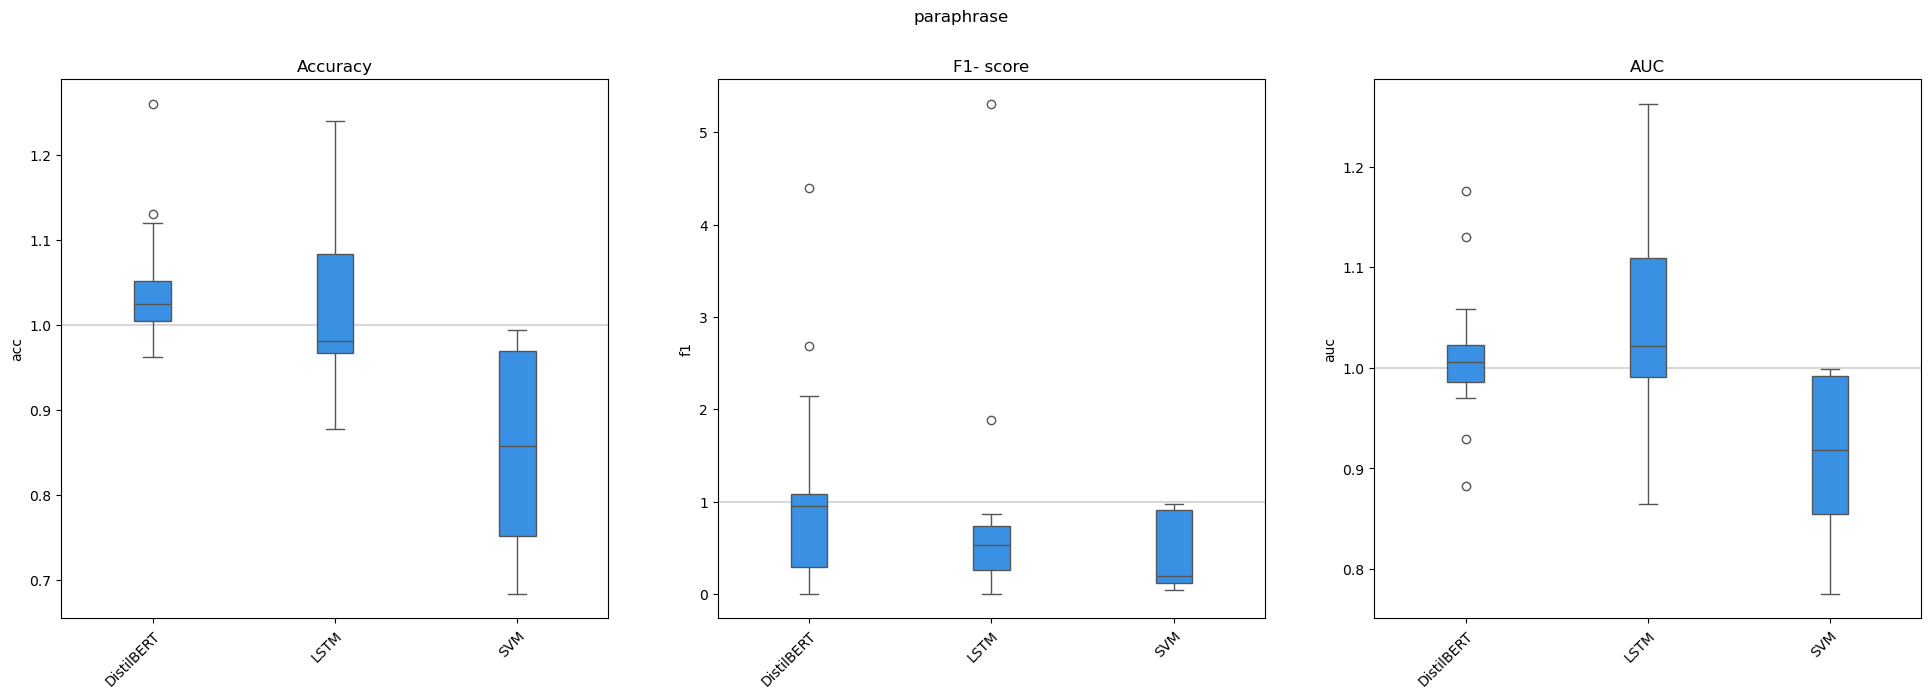

eraser_model_paraphrase_rel.png


In [26]:
for method in np.unique(df_relative["Balancing method"]):
    if method=="original":continue
    df_tmp = df_relative[df_relative["Balancing method"]==method].reset_index(drop=True)
    boxplot(df_tmp, ["acc", "f1", "auc"], grouping = "Model name", title=method, relative = True)

# Removal of bad models

In [27]:
df_good = df[(df["auc"]>0.6) & (df["f1"]!=0)]
print(f"We remove {len(df)-len(df_good)} ({np.round((len(df)-len(df_good))/len(df)*100, 1)}%) of all models:")
for model in np.unique(df["Model name"]):
    df_tmp = df[df["Model name"]==model]
    df_tmp_good = df_good[df_good["Model name"]==model]
    print(f"- {len(df_tmp)-len(df_tmp_good)} ({np.round((len(df_tmp)-len(df_tmp_good))/len(df_tmp)*100, 1)}%) of {model} models")

We remove 85 (20.1%) of all models:
- 22 (15.6%) of DistilBERT models
- 54 (38.3%) of LSTM models
- 9 (6.4%) of SVM models


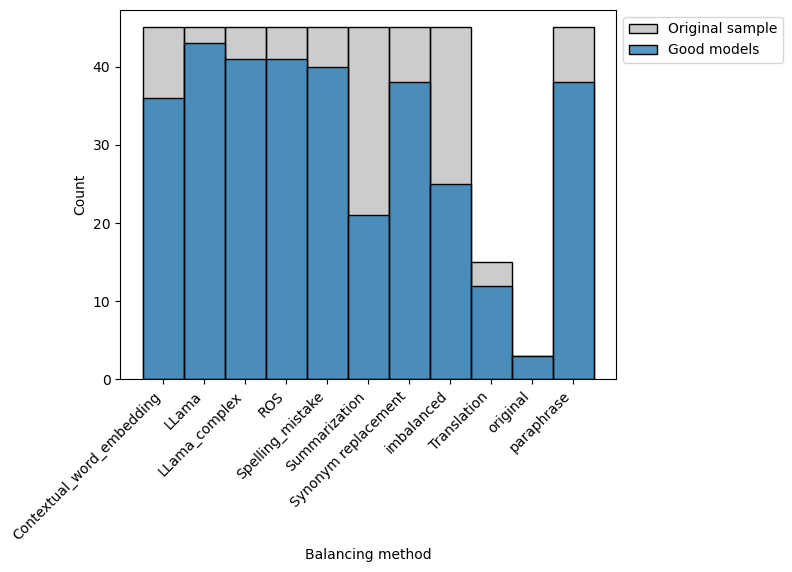

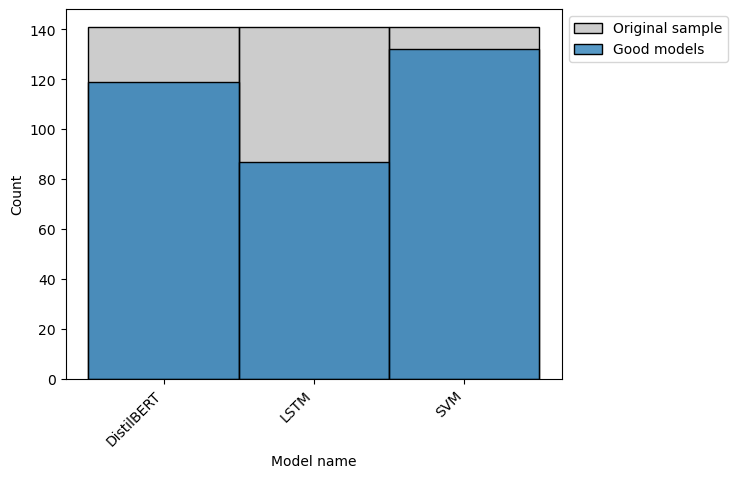

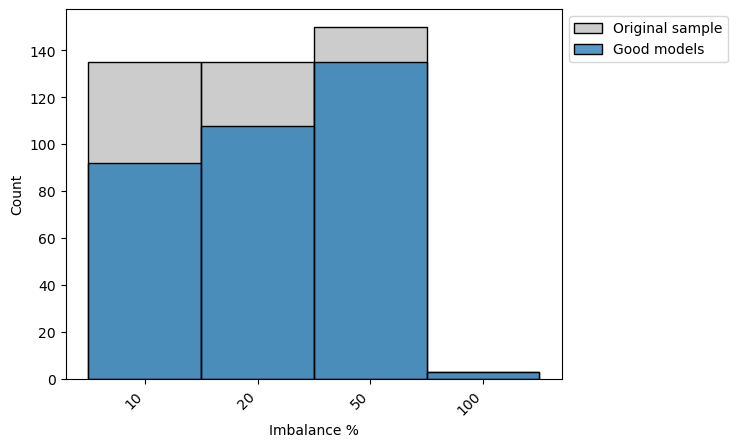

In [28]:
for dimension in ["Balancing method", "Model name", "Imbalance %"]:
    sns.histplot(df[dimension].astype(str),color="gray", alpha=.4, label="Original sample")
    g=sns.histplot(df_good[dimension].astype(str),label="Good models")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    sns.move_legend(g, "upper left", bbox_to_anchor=(1,1))
    plt.savefig(out+"\\"+f"removal_of_bad_{dimension.split(' ')[0]}.png", bbox_inches='tight')
    plt.show()

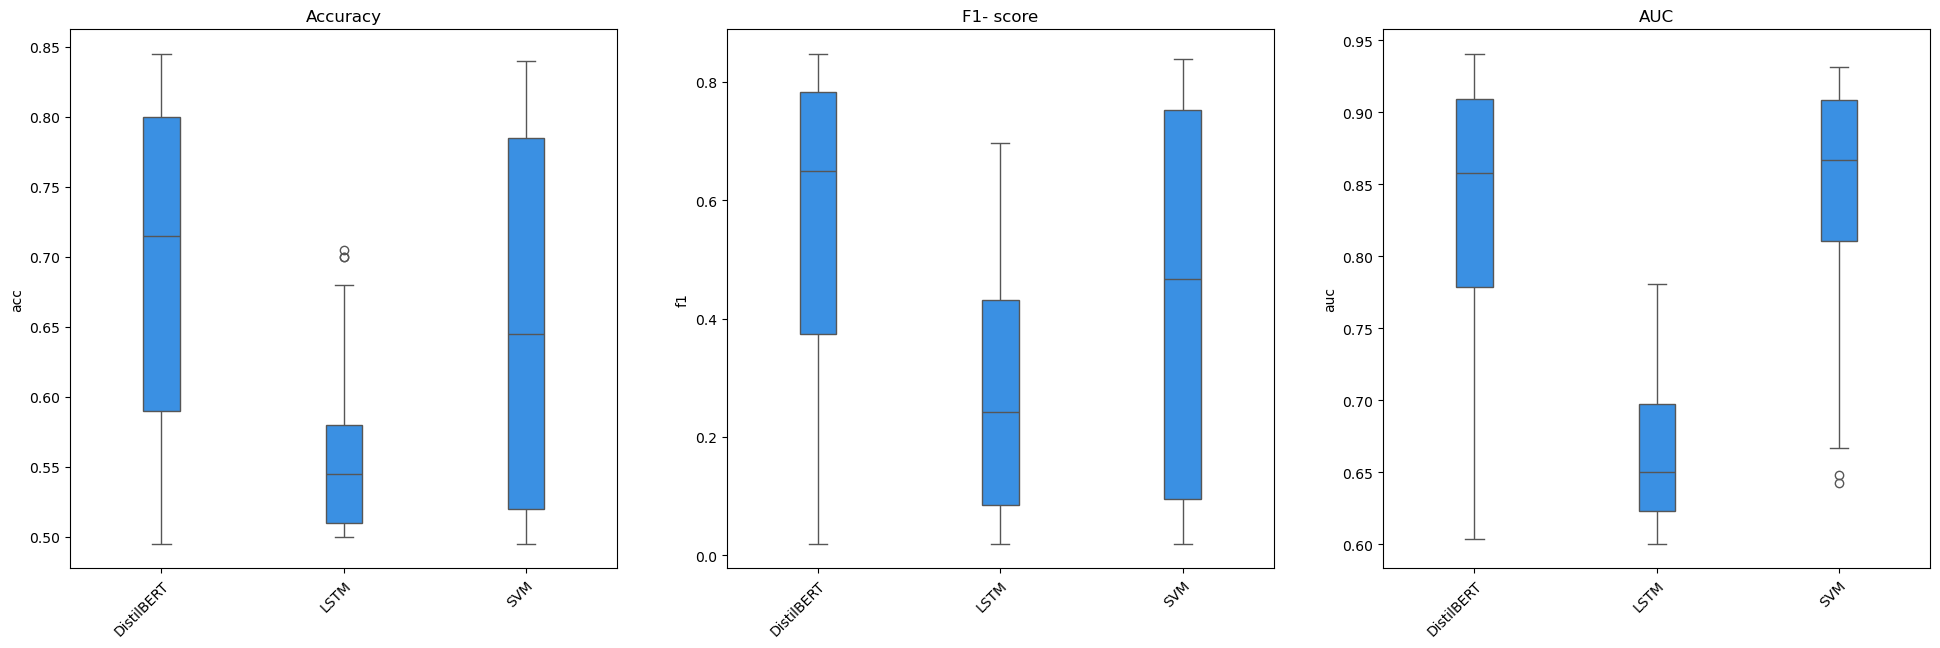

eraser_model_good.png


In [29]:
boxplot(df_good, ["acc", "f1", "auc"], grouping = "Model name", good=True)

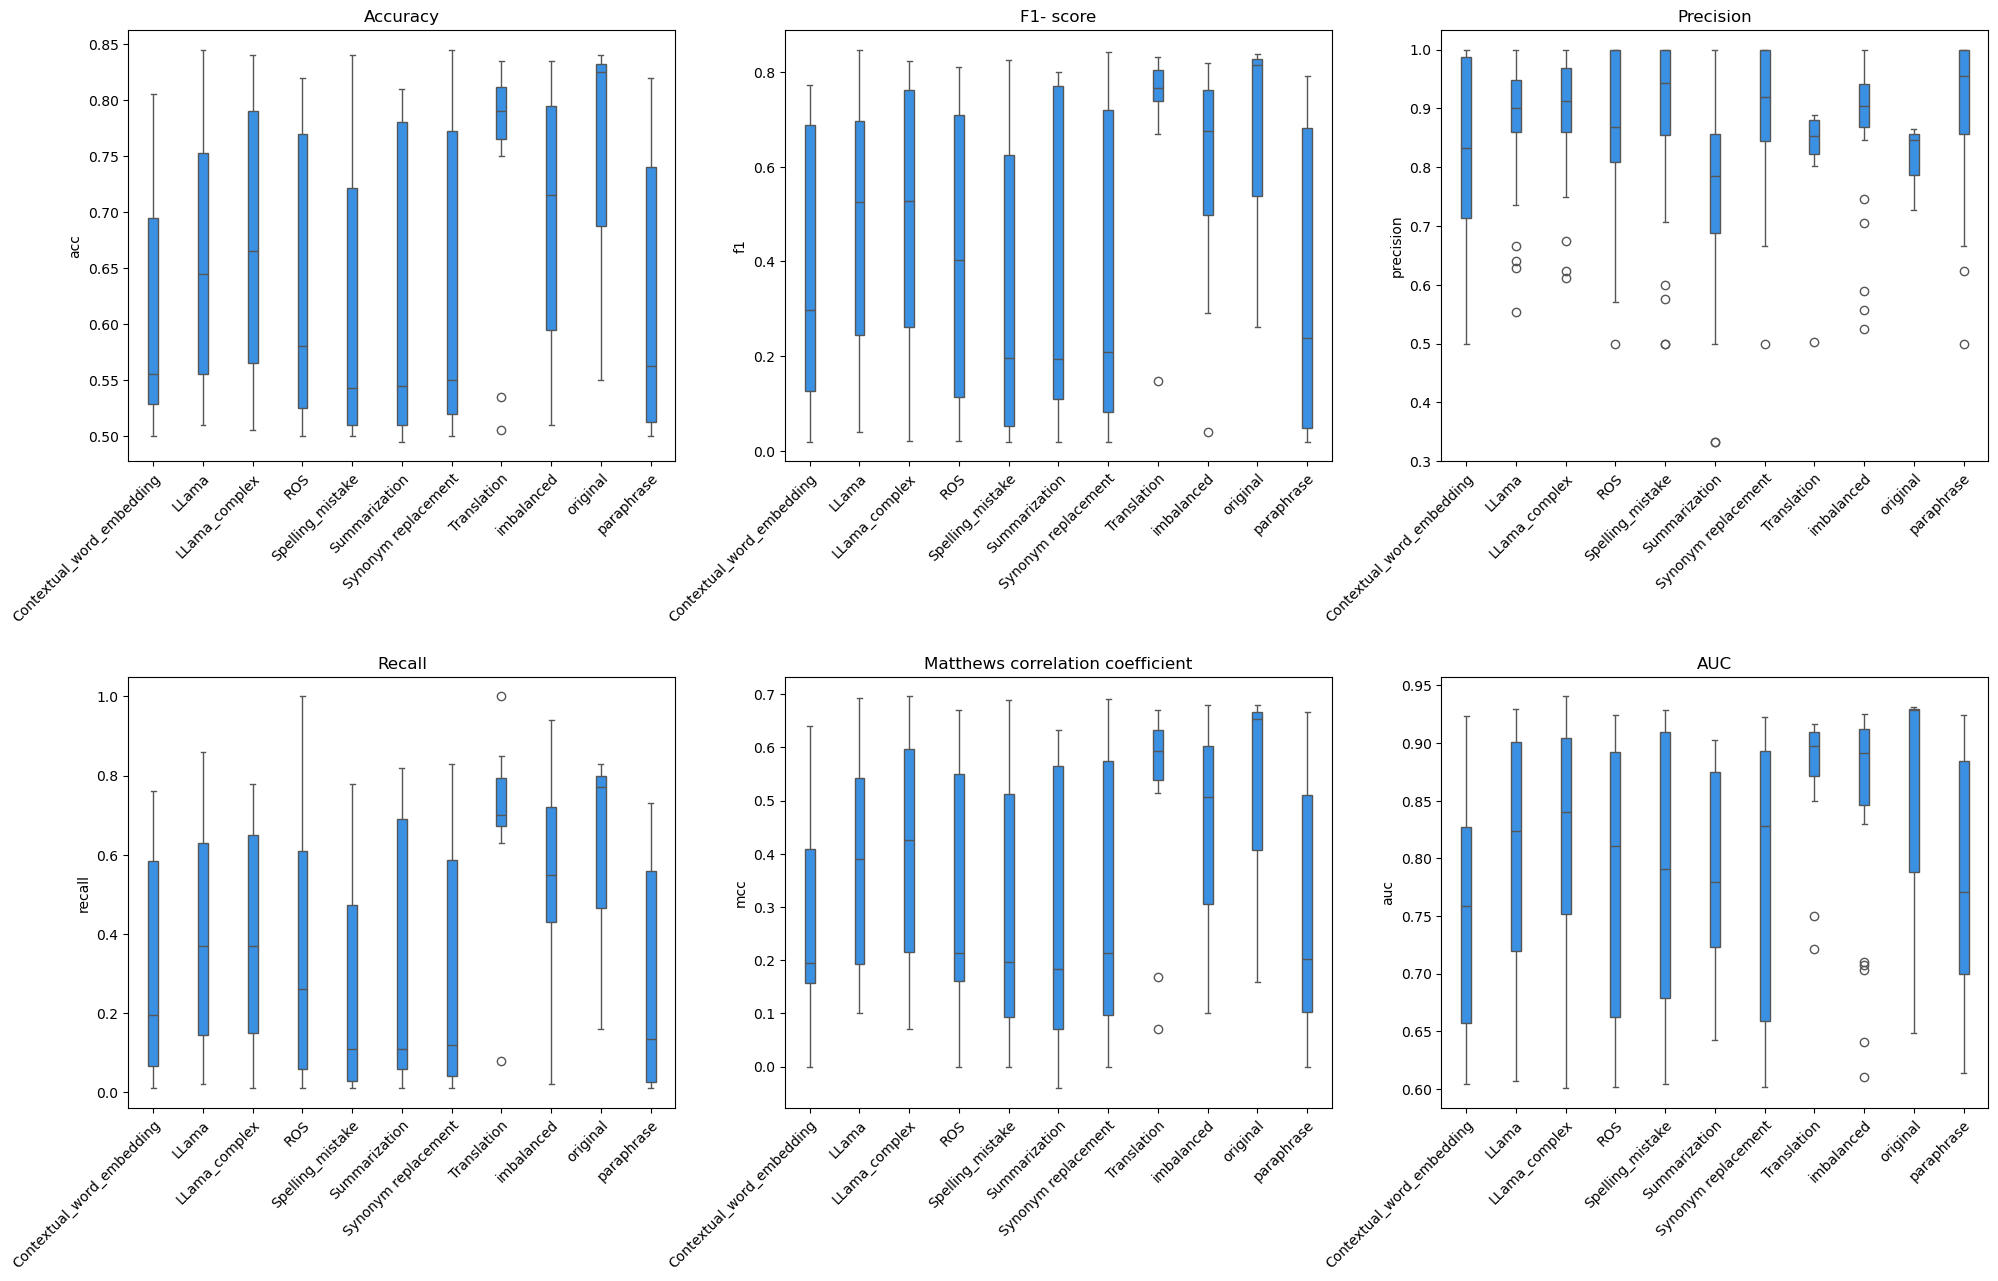

eraser_balancing_good.png


In [30]:
boxplot(df_good, grouping = "Balancing method", good=True)

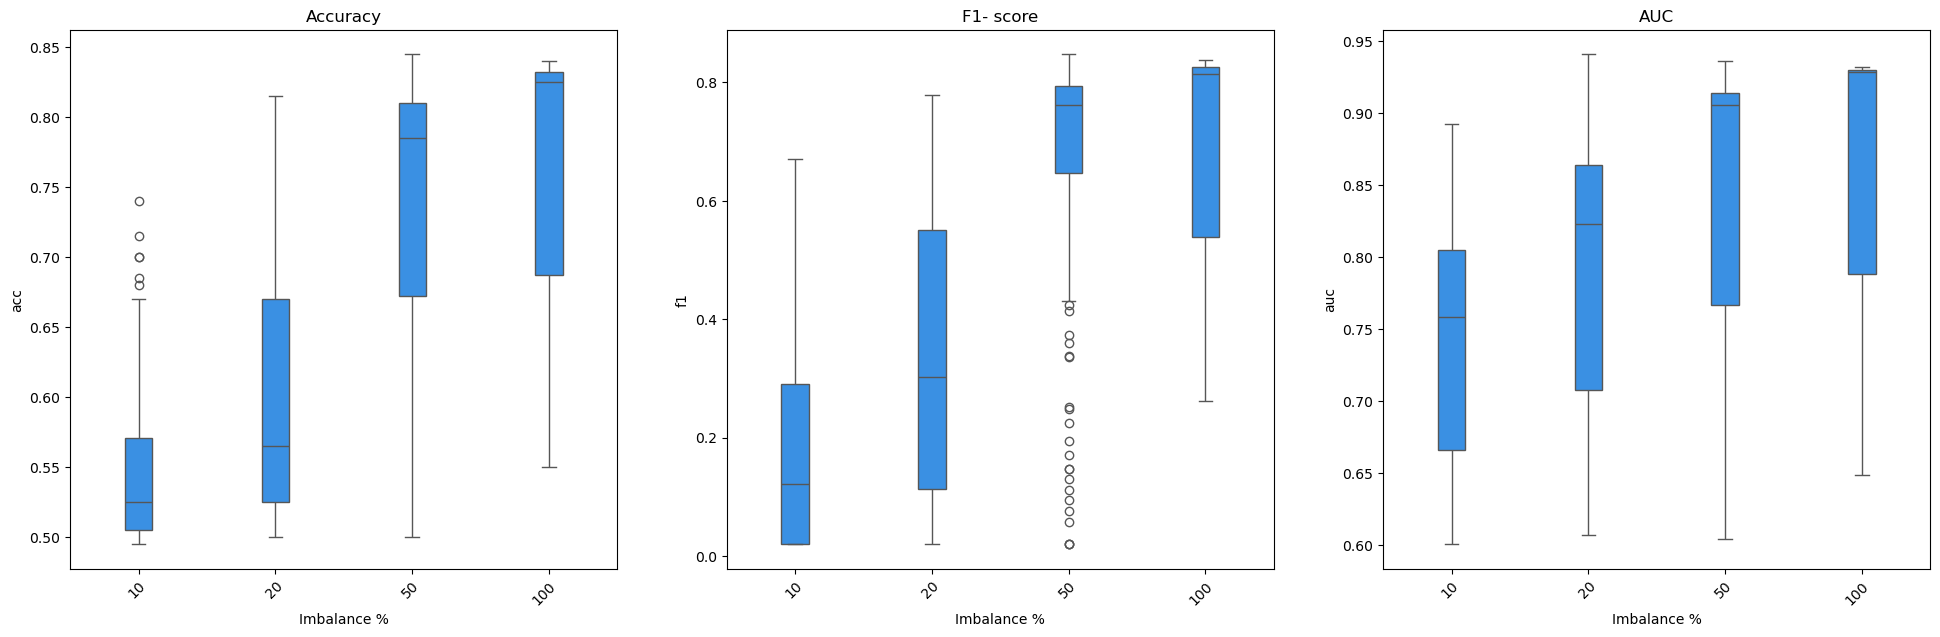

eraser_imbalance_good.png


In [31]:
boxplot(df_good, ["acc", "f1", "auc"], grouping = "Imbalance %", good=True)

# Calibration

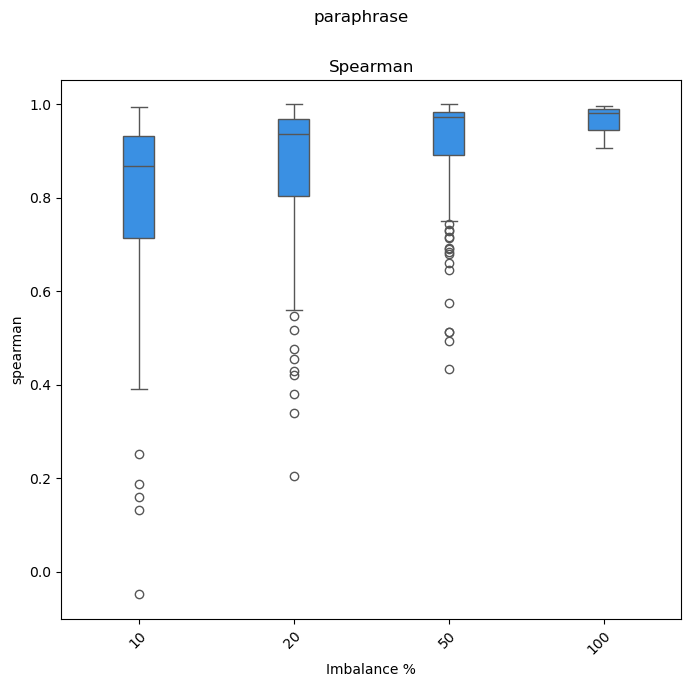

eraser_imbalance_paraphrase_cal.png


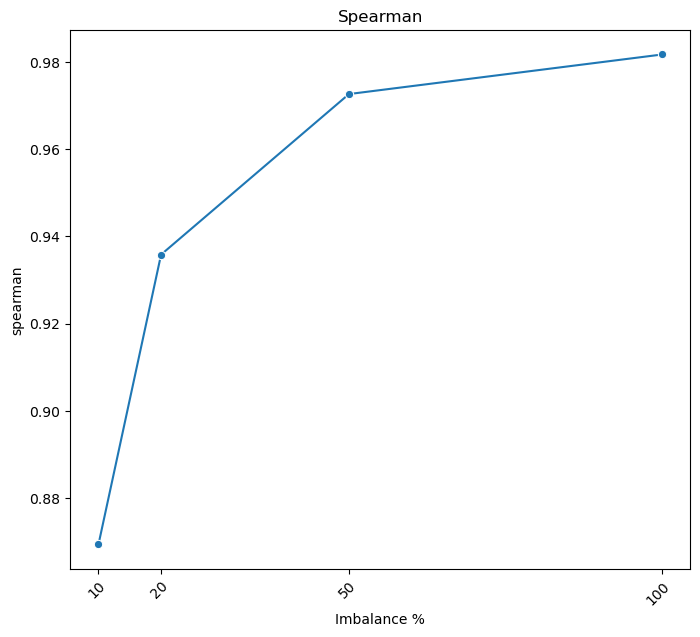

eraser_imbalance_cal_line.png


In [32]:
boxplot(df, ["spearman"], grouping = "Imbalance %", title=method)

median_plot(df, measures = ["spearman"], grouping = None, relative = False, title=None)

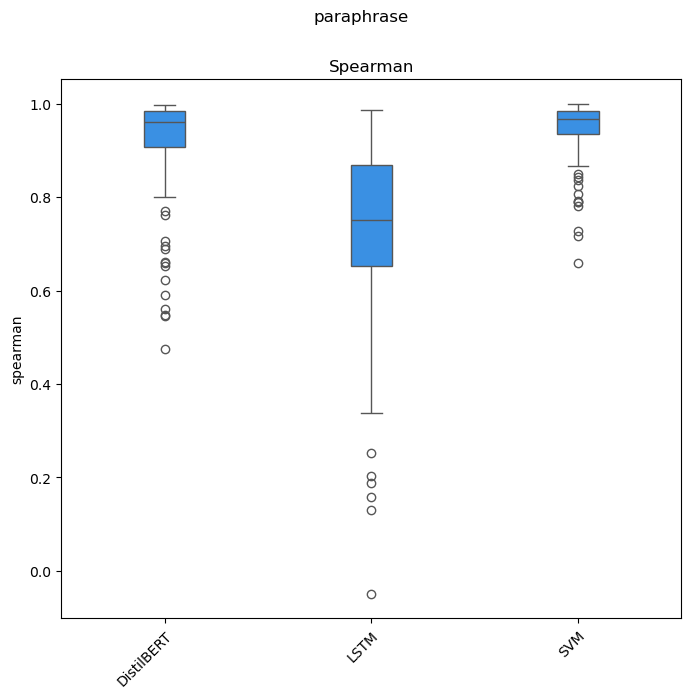

eraser_model_paraphrase_cal.png


In [33]:
boxplot(df, ["spearman"], grouping = "Model name", title=method)

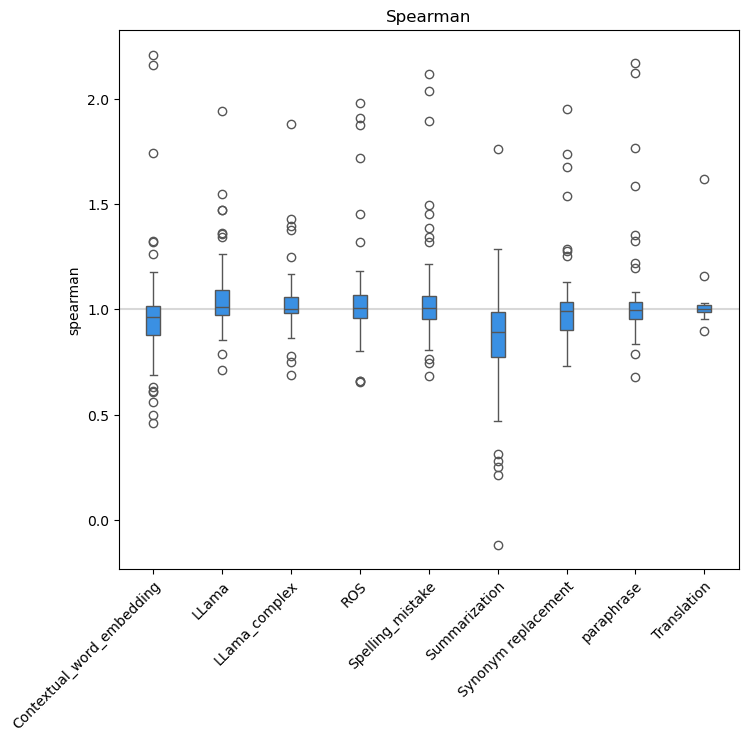

eraser_balancing_rel_cal.png


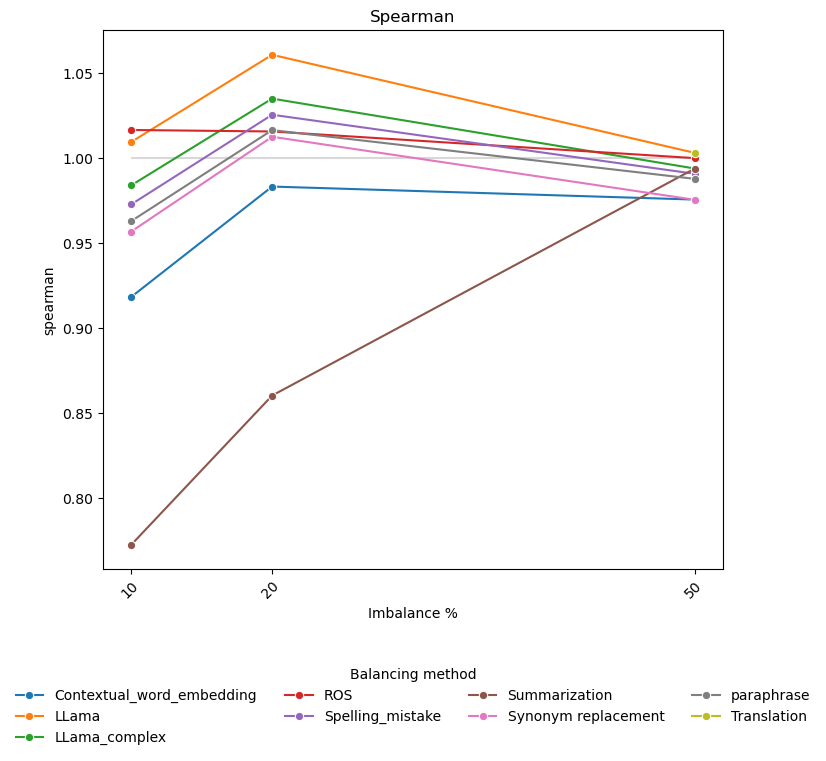

eraser_imbalance_rel_cal_line.png


In [34]:
boxplot(df_relative, ["spearman"], grouping = "Balancing method", relative = True)

median_plot(df_relative, measures = ["spearman"], grouping = "Balancing method", relative = True, title=None)

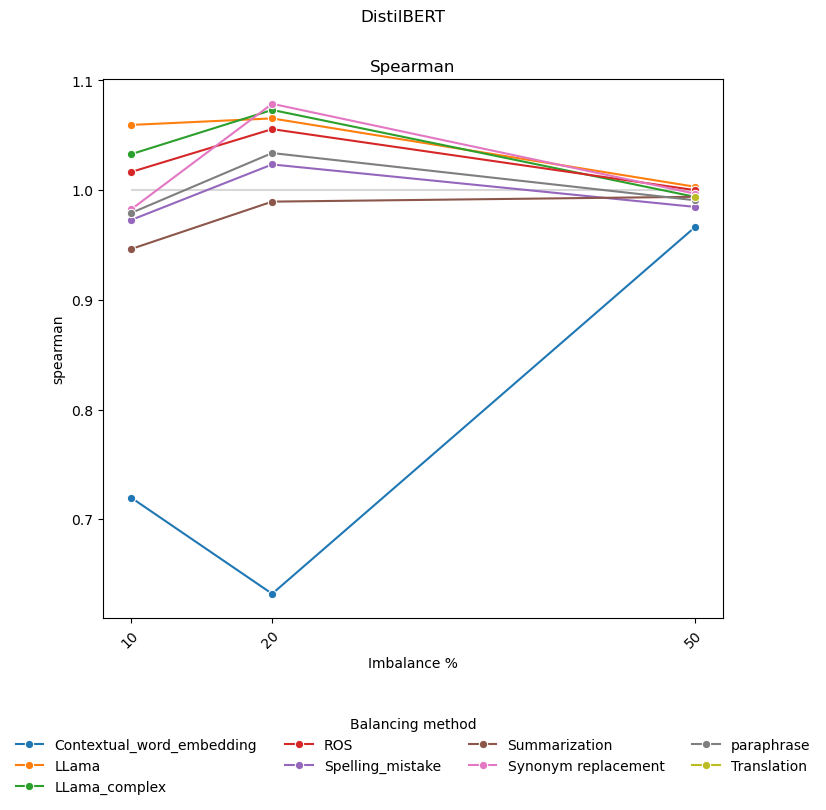

eraser_imbalance_distilbert_rel_cal_line.png


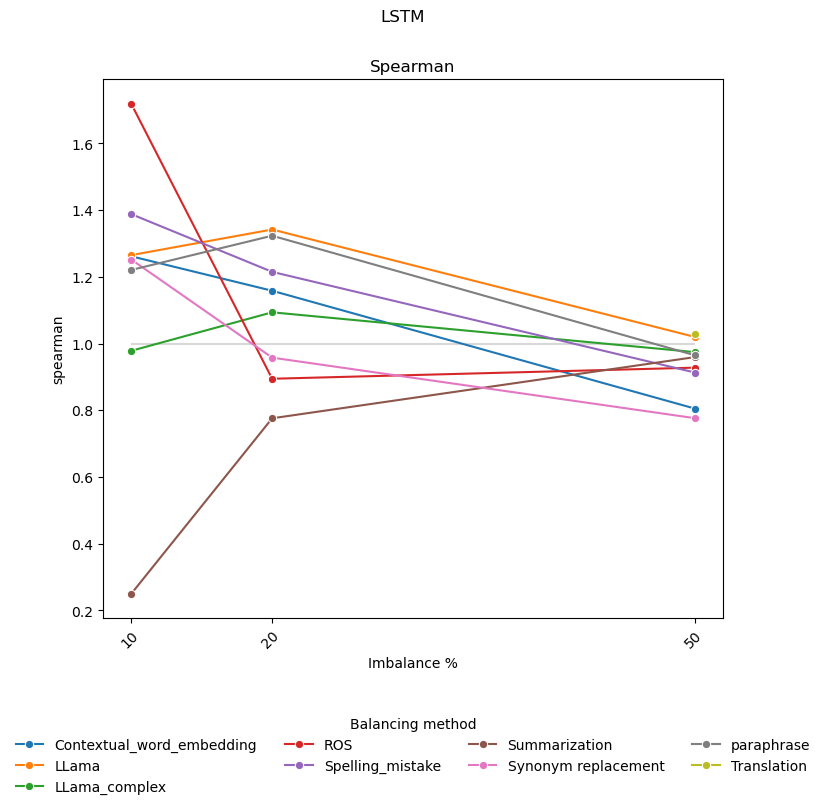

eraser_imbalance_lstm_rel_cal_line.png


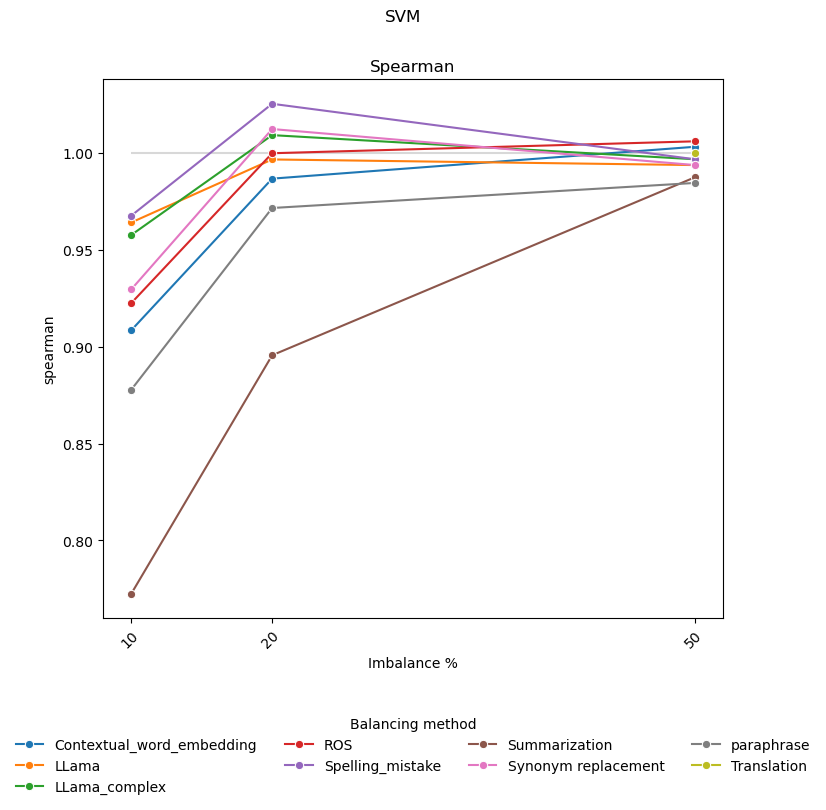

eraser_imbalance_svm_rel_cal_line.png


In [35]:
for model in np.unique(df["Model name"]):
    median_plot(df_relative[df_relative["Model name"]==model], measures = ["spearman"], grouping = "Balancing method", relative = True, title=model)

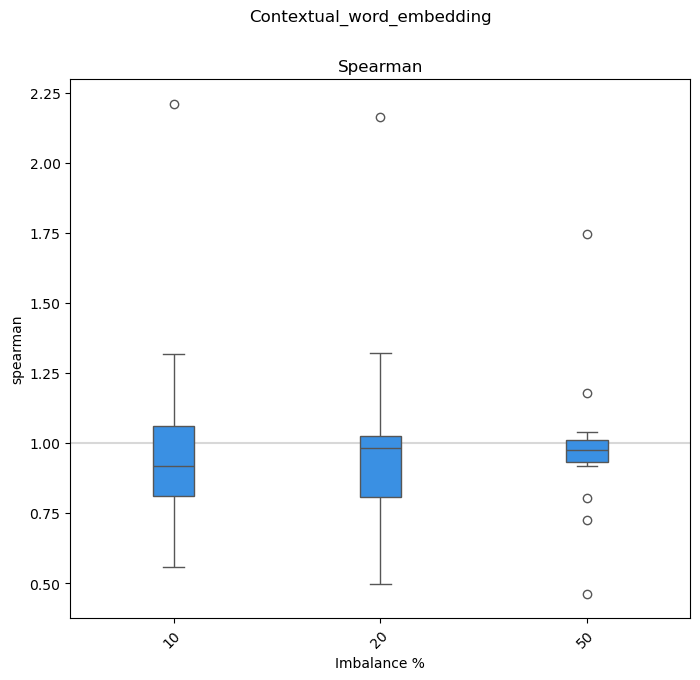

eraser_imbalance_contextual_word_embedding_rel_cal.png


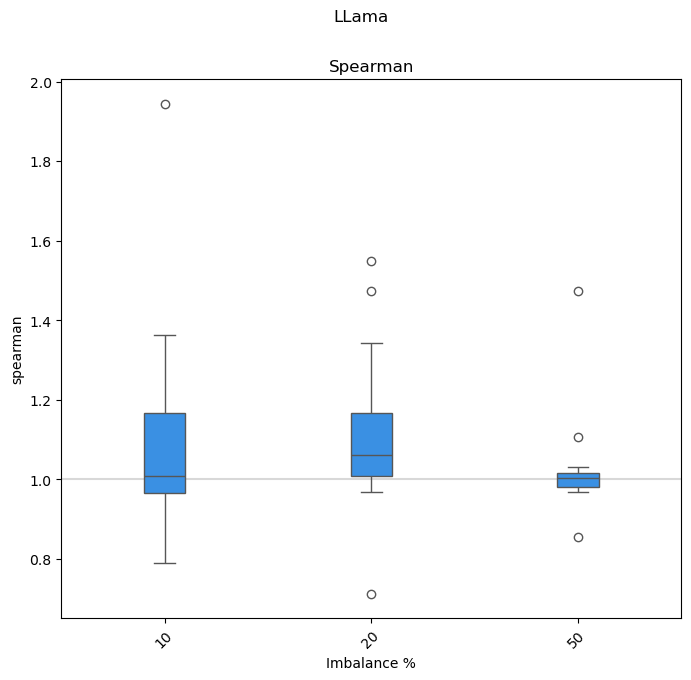

eraser_imbalance_llama_rel_cal.png


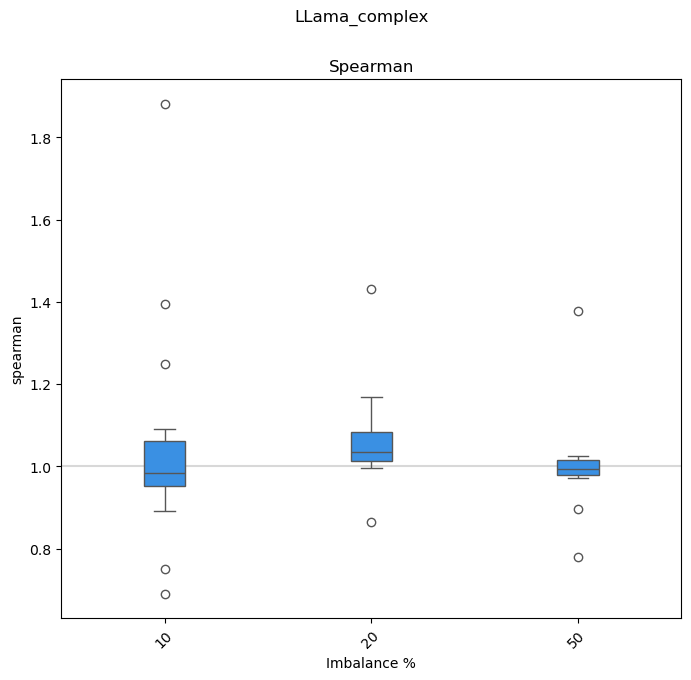

eraser_imbalance_llama_complex_rel_cal.png


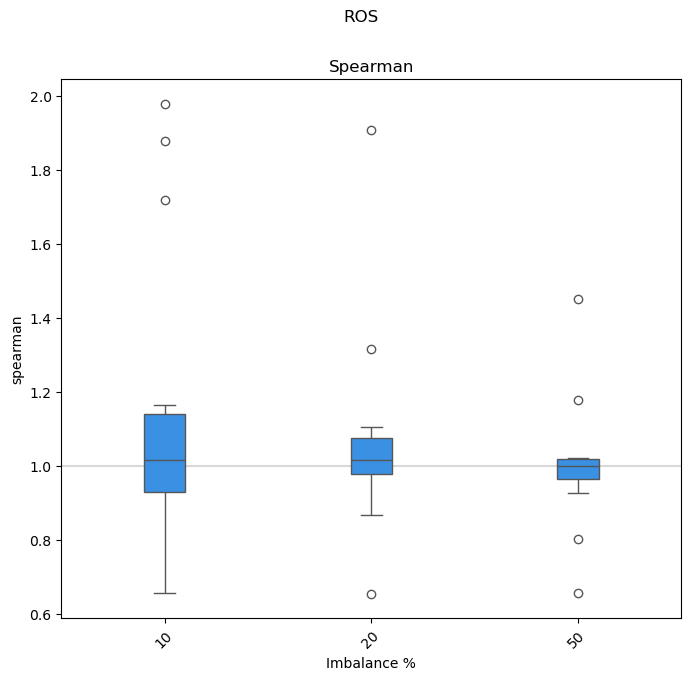

eraser_imbalance_ros_rel_cal.png


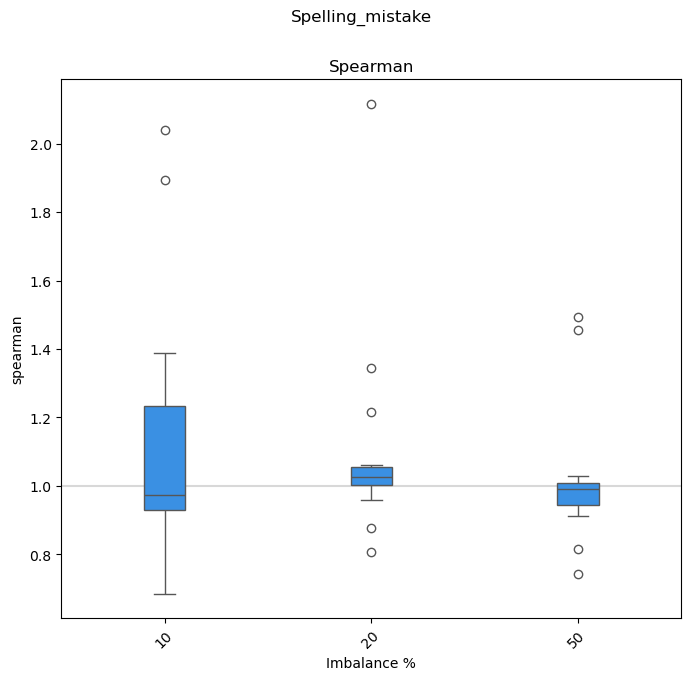

eraser_imbalance_spelling_mistake_rel_cal.png


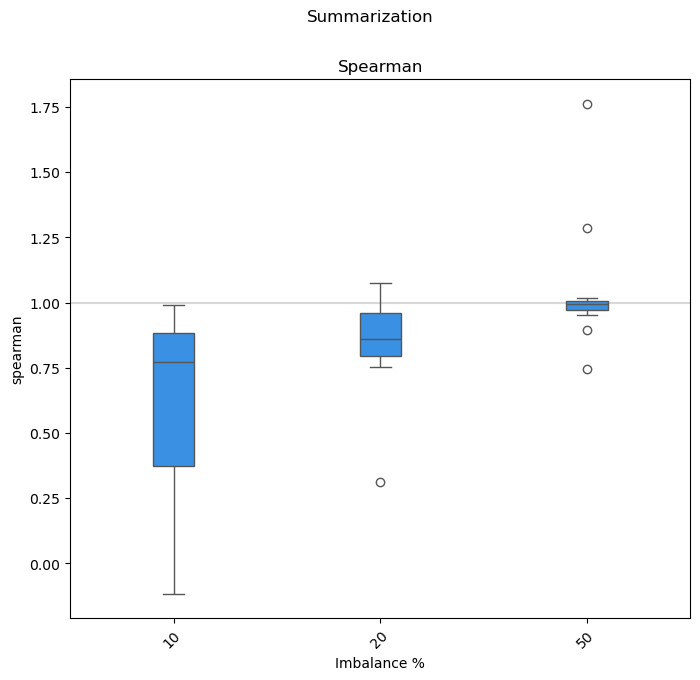

eraser_imbalance_summarization_rel_cal.png


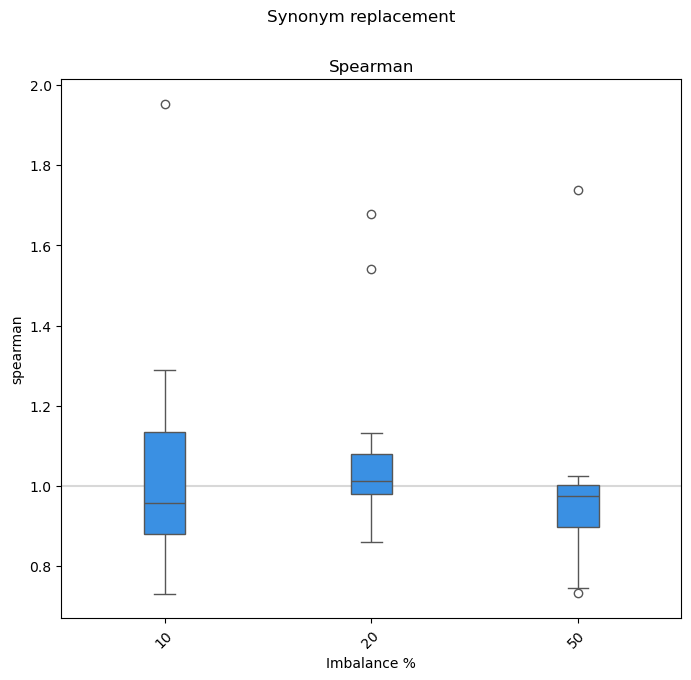

eraser_imbalance_synonym_rel_cal.png


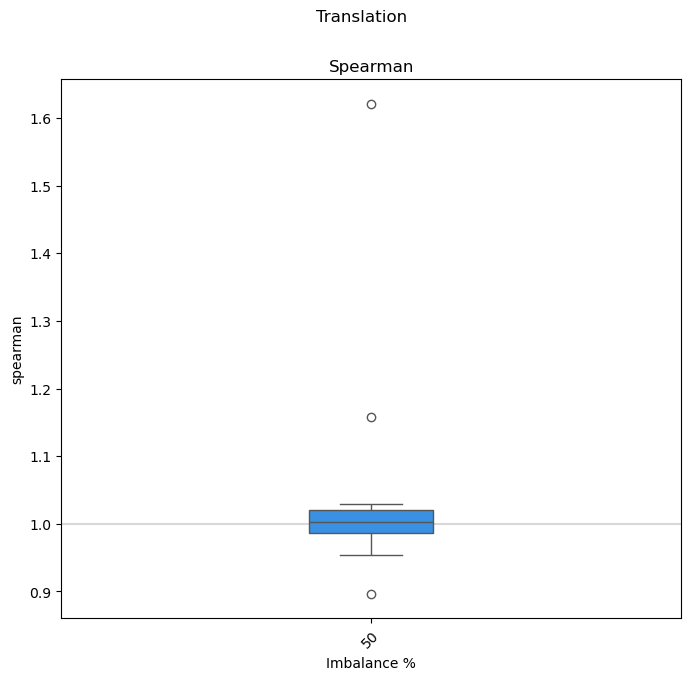

eraser_imbalance_translation_rel_cal.png


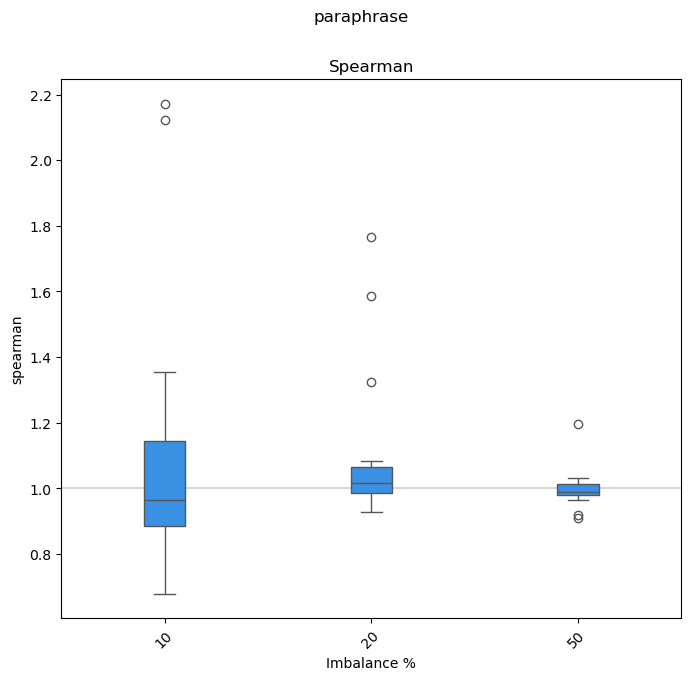

eraser_imbalance_paraphrase_rel_cal.png


In [36]:
for method in np.unique(df_relative["Balancing method"]):
    if method=="original":continue
    df_tmp = df_relative[df_relative["Balancing method"]==method].reset_index(drop=True)
    boxplot(df_tmp, ["spearman"], grouping = "Imbalance %", title=method, relative = True)

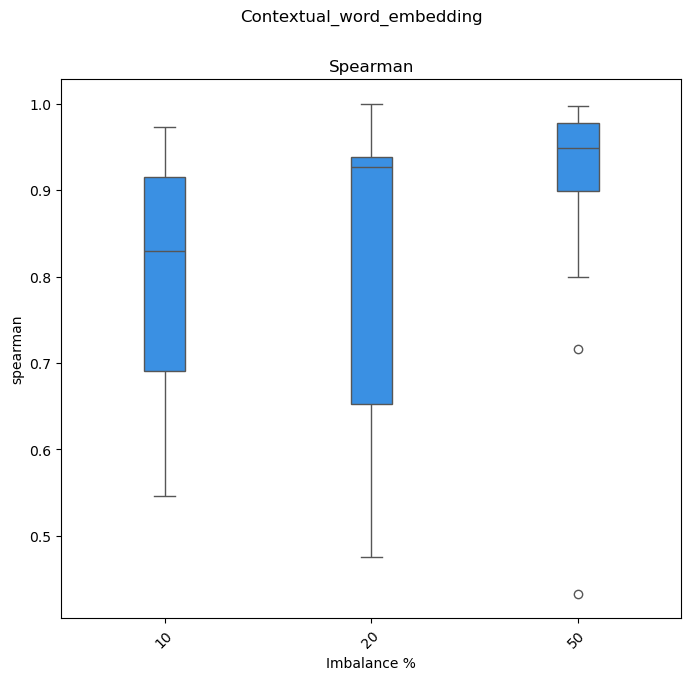

eraser_imbalance_contextual_word_embedding_good_cal.png


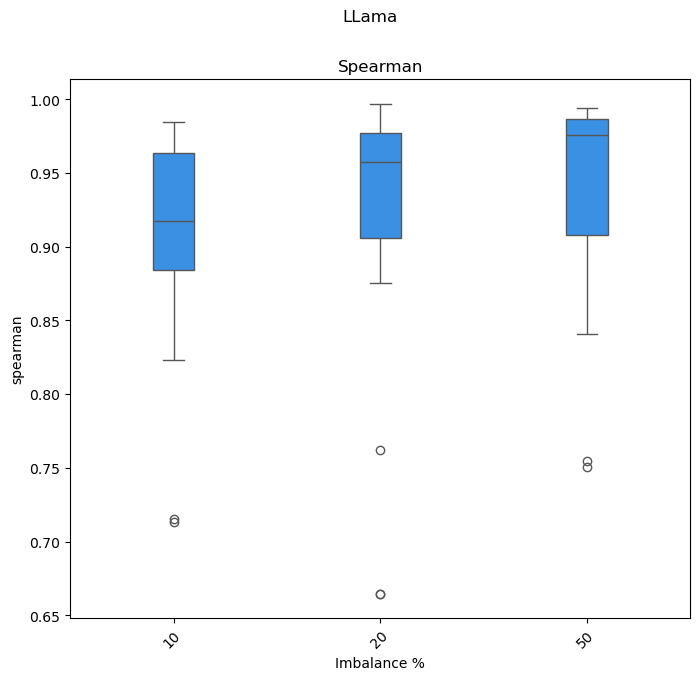

eraser_imbalance_llama_good_cal.png


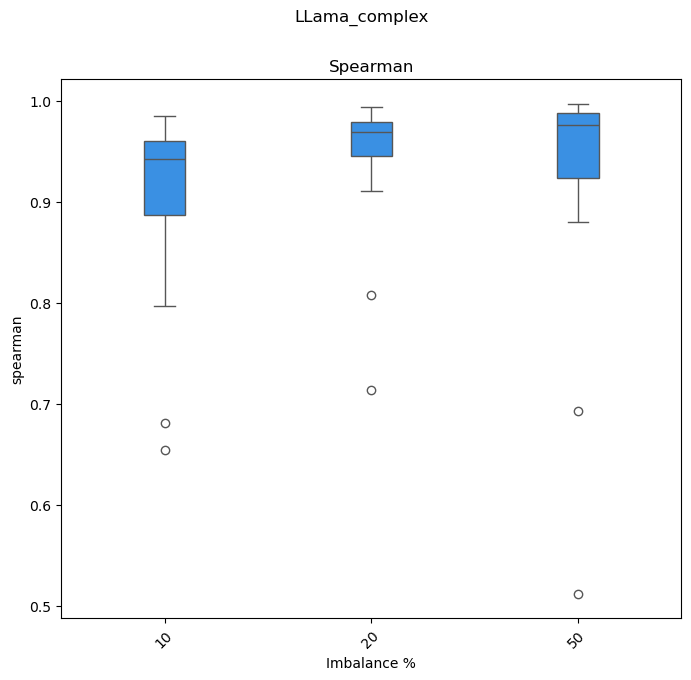

eraser_imbalance_llama_complex_good_cal.png


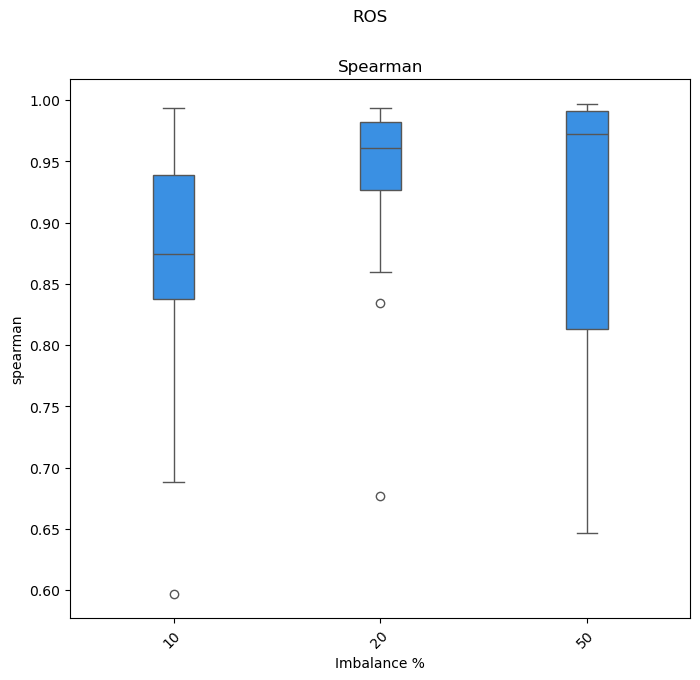

eraser_imbalance_ros_good_cal.png


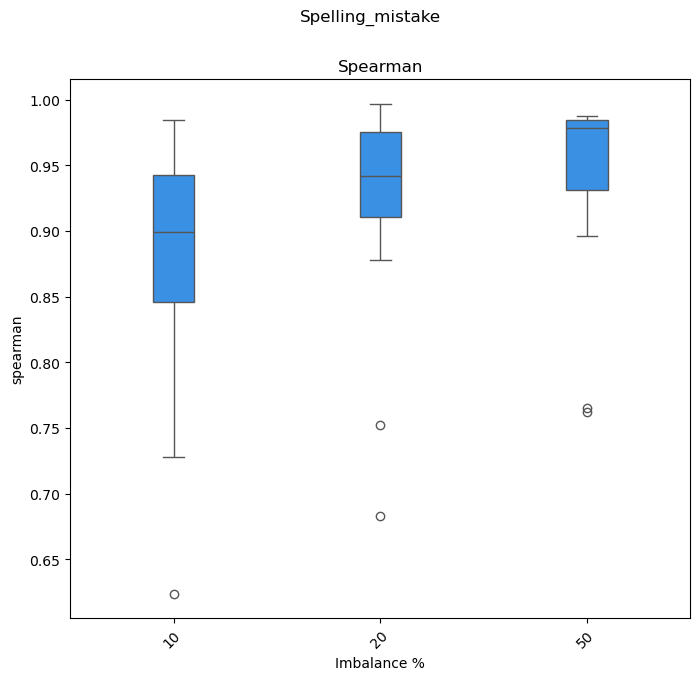

eraser_imbalance_spelling_mistake_good_cal.png


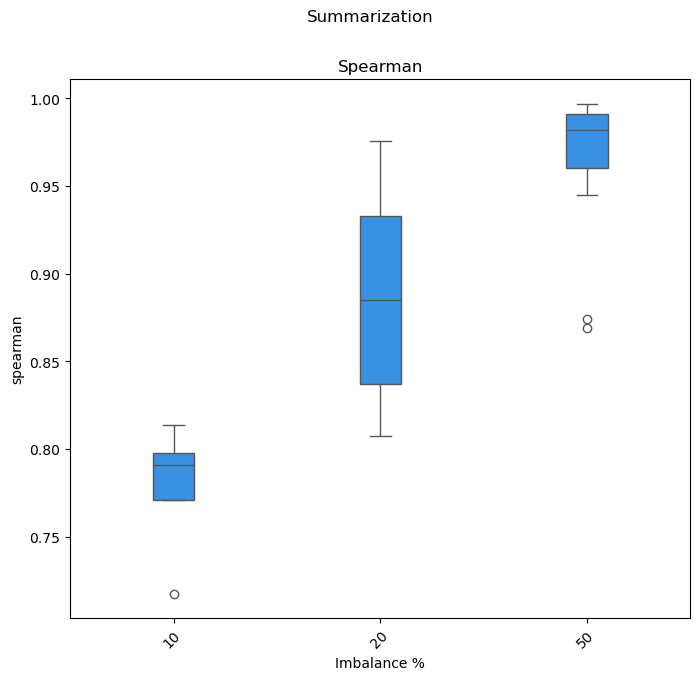

eraser_imbalance_summarization_good_cal.png


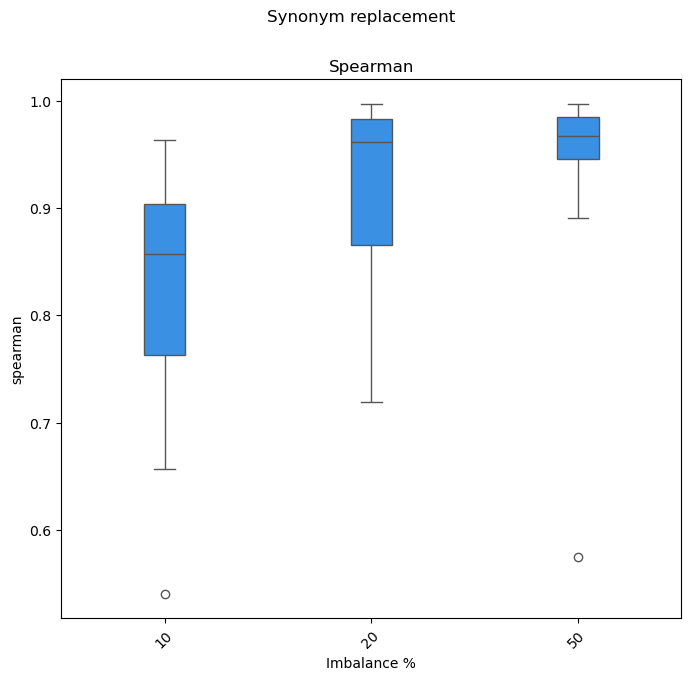

eraser_imbalance_synonym_good_cal.png


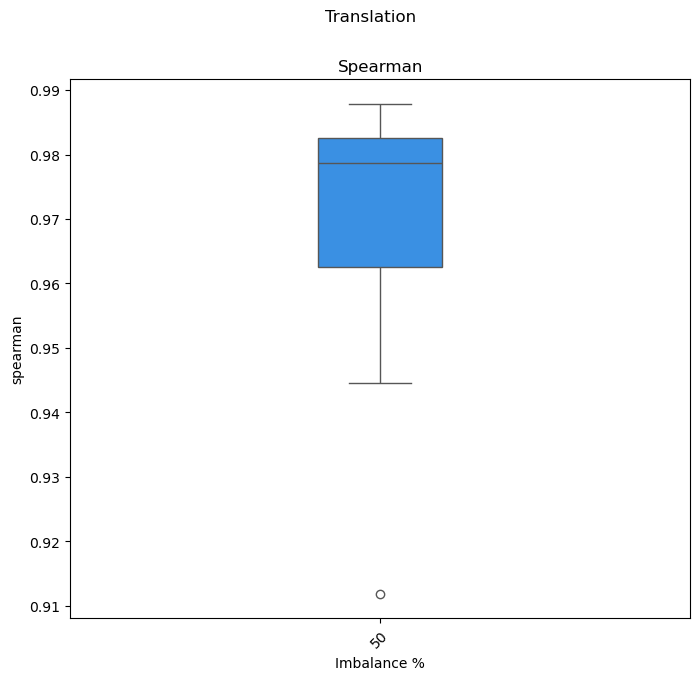

eraser_imbalance_translation_good_cal.png


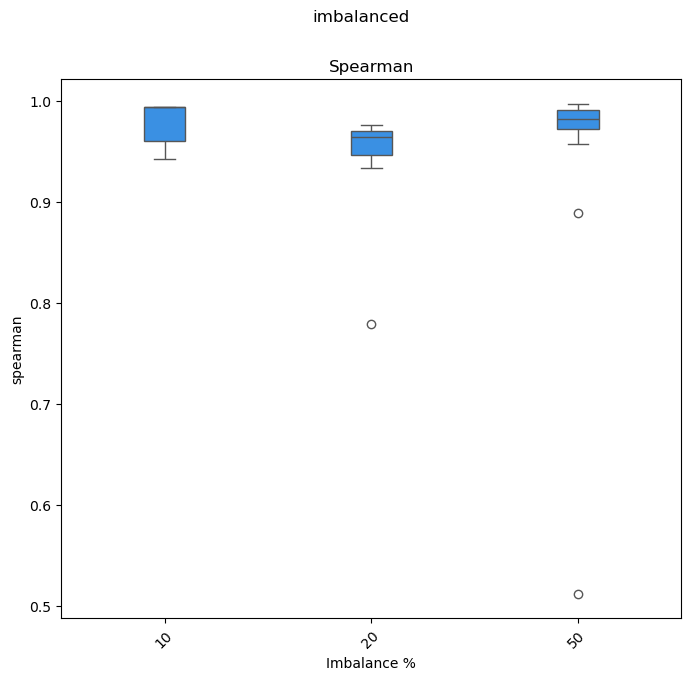

eraser_imbalance_imbalanced_good_cal.png


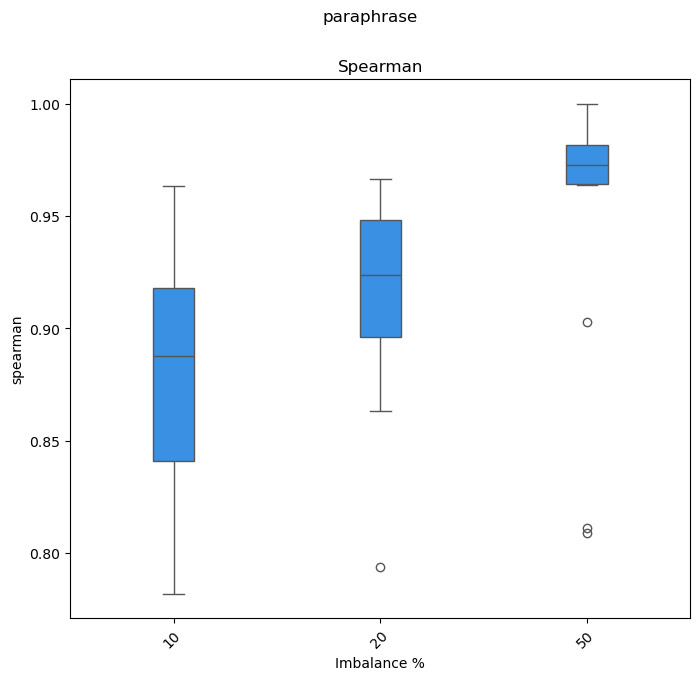

eraser_imbalance_paraphrase_good_cal.png


In [37]:
for method in np.unique(df_good["Balancing method"]):
    if method=="original":continue
    df_tmp = df_good[df_good["Balancing method"]==method].reset_index(drop=True)
    boxplot(df_tmp, ["spearman"], grouping = "Imbalance %", title=method, good=True)